# Rhabdomere volume and lamina connectivity
Insect ommatidia consistently contain a set of morphologically distinct and functionally divergent photoreceptor subtypes. By drawing comparisons between the morphological characteristics of *Megaphragma* photoreceptors with their synaptic connectivity downstream, we describe ways in which photoreceptor diversity and variability is reflected in the organization of the lamina circuit. 

Photoreceptor subtypes associated wih achromatic visual processes, such as motion detection, typically form larger rhabdomeres than photoreceptors responsible for chromatic sensing. By transducing more light, these photoreceptors can respond faster to smaller changes in light intensity compared to the subtypes with smaller rhabdomeres. Similar to most insects, each *Megaphragma* ommatidium contains a group of 'short' photoreceptors whose axons terminate in the lamina (R1-6), along with a group of 'long' photoreceptors whose axons may receive inputs in the lamina before terminating in the next optic neuropil, the medulla. We expected to see similar morphological characteristics that differentiate short and long photoreceptors in other insects, but were surpised to find that *Megaphragma's* six 'short' photoreceptors, whose axons terminate in the lamina cartridge (R1-6), form smaller rhabdomeres than most of the 'long' photoreceptors whose axons continue into the medulla. R1-6 R7, R8, and R7'. Similar to Drosophila, a vast majority of the synapses we observed in the lamina are R1-6 outputs, particular outputs to the anucleate LMC subtypes L1-4. We found that the number of presynaptic terminals belonging to R1-6, and consequently the number of output connections they form within the lamina cartridge, varies with respect to the cell's rhabdomere volume. More space in the eye is allocated towards R2 and R5, presumably to increase the temporal fidelity of their signal compared to the four smaller short photoreceptors. In order to take advantage of the increased temporal information provided by R2 and R5, a larger number of parallel output synapses are employed to transmit their outputs to postsynaptic targets in the lamina. By sampling from a larger number of synapses, a postsynaptic neuron reduces the noise associated with spontaneous synaptic release, preseving the bandwidth of the photoreceptor signal. 

Each R1-6 synapse we observed abutts a large number of postsynaptic neurites. Although R1-6 subtypes vary in rhabdomere volume and number of output connections, the average number of neurites postsynaptic to each R1-6 terminal was relatively constant and independent of rhabdomere volume. 

In the lamina, R7, R8, and R7' rarely form any output synapses; instead, these long photoreceptor axons form branches and receive synaptic inputs in the lamina cartridge, before projecting into various layers of the medulla. 

R2 and R5 consistently occupy a larger proportion of the rhabdom's volume compared to R1, R3, R4, and R6. Allocating more of the rhabdom's space towards R2 and R5 indicates a  , where R2 and R5 form a greater number of both presynaptic terminals and output connections than R1, R3, R4, and R5. 

absorb a larger fraction of the ommatidium's incoming light,    compared to subtypes that  of certain subtypes are larger, allowing for  larger rhabdomeres allow a photoreceptor to absorb a larger fraction of light entering the ommatidia. 
- Hypothesis: Photoreceptor subtypes associated with large rhabdomere volumes must form more synapses in the lamina to make use of their expanded dynamic range compared to photoreceptors with smaller rhabdomeres.
- Hypothesis: Within each ommatidium, differences in their photoreceptor's rhabdomere volumes would be reflected in differences between their lamina outputs. 
Note: E5's rhabdom was damaged in the imaging dataset, so the volumes recorded for this ommatidium are not accurate (could be significantly underestimated)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

import sys
from cx_analysis.dataframe_tools import assemble_cxvectors, extract_connector_table
from cx_analysis.vis.fig_tools import linear_cmap, subtype_cm
from cx_analysis.vis.hex_lattice import hexplot

In [2]:
cell_cm = subtype_cm()
plt.style.use('../cx_analysis/vis/lamina.mplstyle') # may not work if installed as a module
### SAVE FIGS? ###
savefigs=False
##################
# if save_figs:
#     fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/FNAME.svg')
#     fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/FNAME.png')

In [3]:
# Load/organize lamina connectome data
tp = '210809'
data_path = f"~/Data/{tp}_lamina/"

In [4]:
# Volume data from excel provided by AM. 
# Contains both the volume of each PR's cell body, and the volume of just their rhabdomeres
xl_path = data_path + 'optics/cell_rbd_volume.xlsx'
parsed_xl = pd.read_excel(xl_path, header=[0, 1], index_col=0, nrows=9)
# Currently we only want the rhabdom volumes, so remove cell body columns
data = dict.fromkeys(parsed_xl.columns.levels[0])
for om in parsed_xl.columns.levels[0]:
    data[om] = parsed_xl.loc[:, (om, 'rbd')]

vol_df = pd.DataFrame(data)
vol_df = vol_df.rename(mapper={"R7'": "R7p"}, axis=0).rename(mapper={"E5*": "E5"}, axis=1).T
vol_df.index = vol_df.index.rename('om')
vol_df.sort_values(by='om')

total_vol = vol_df.sum(axis=1)
frac_vol = (vol_df.T / total_vol).T

# Load/organize lamina connectome data
link_df = pd.read_pickle(data_path + f"{tp}_linkdf.pickle")
assert('UNKNOWN' not in link_df['post_type'])  # these should already be removed in preprocessing
cxvecs = assemble_cxvectors(link_df).astype(float)

# Summary connectivity data (cartridge totals, all R-16)
total_syn = cxvecs.sum(axis=1).rename_axis('Total synaptic outputs')
total_term = link_df.groupby('pre_om')['cx_id'].nunique()
spr_syn = cxvecs.filter(regex='R_\D+->').sum(axis=1).rename_axis('Total short PR outputs')
spr_term = link_df.loc[(link_df['pre_type'] == 'R_quartet') | (link_df['pre_type'] == 'R_duet')].groupby('pre_om')['cx_id'].nunique()
inputs_to_lmc = cxvecs.filter(regex='->LMC').sum(axis=1).rename_axis('Total inputs to LMCs')

## Relationship between total syn outputs and total rhabdom volume
- Limited eye space is unequally distributed between ommatidia. Hypothesis: ommatidia with larger rhabdoms have more synapses in the lamina cause of increased SNR

In [10]:
display(total_vol.mean())
display(total_vol.std())

40.99861596910346

15.378955115201537

Text(0, 0.5, 'Synaptic contacts')

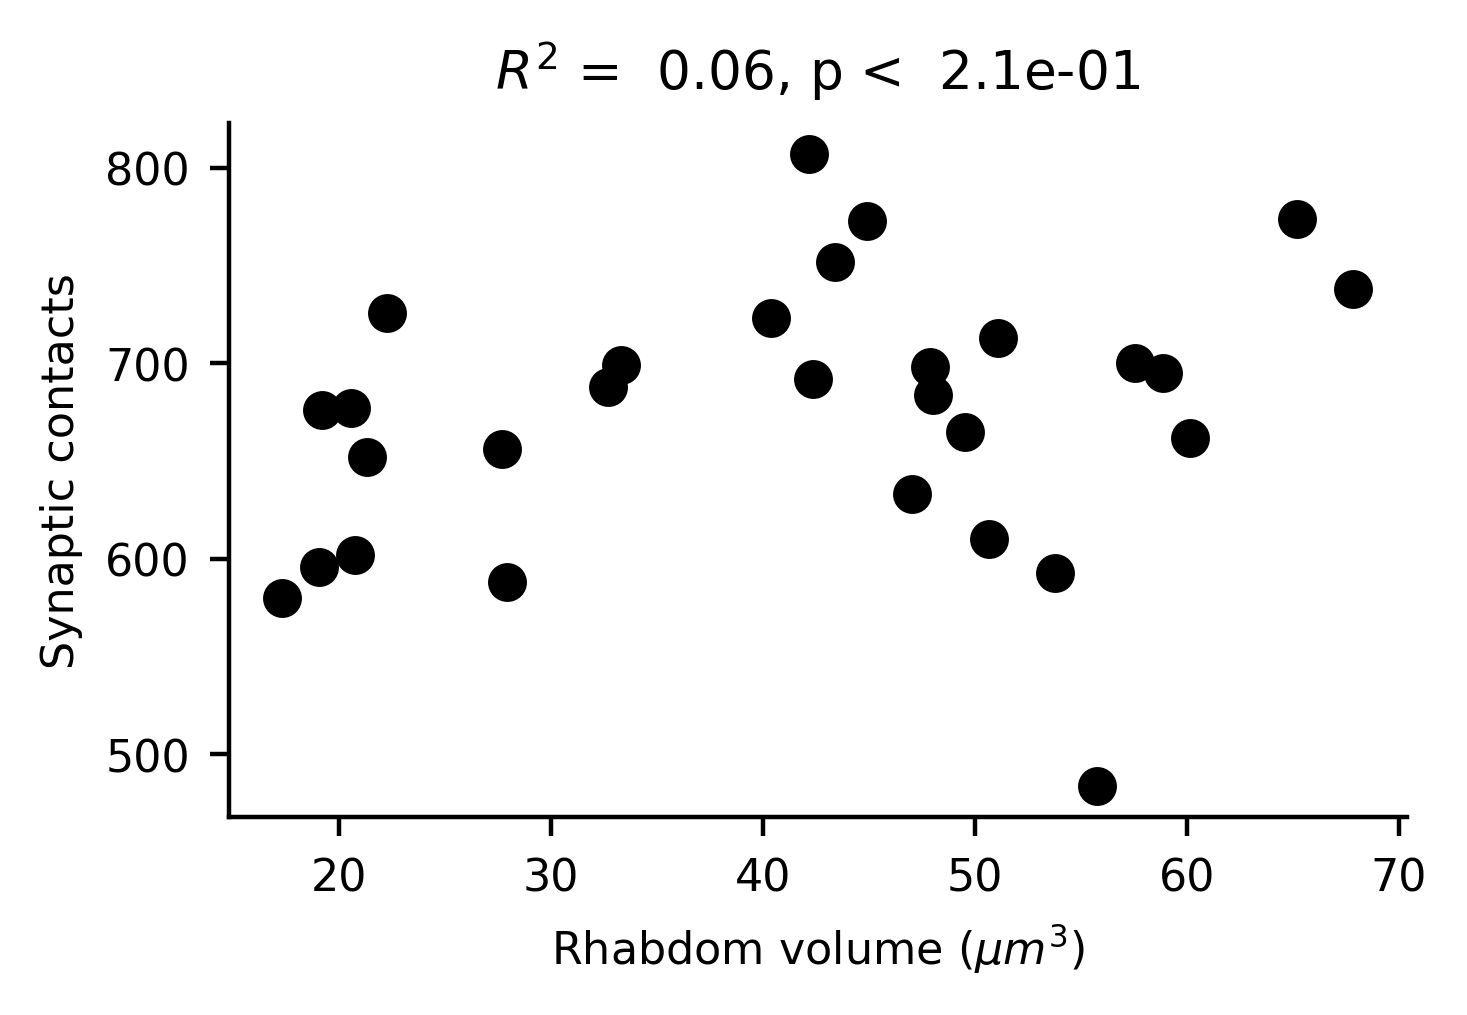

In [6]:
# OLS: total rhabdom volume vs. total synaptic contacts
Y = total_syn
_x = total_vol
X = sm.add_constant(_x)

model = sm.OLS(Y, X)
results = model.fit()
params = results.params
# ~~~~~~~~~~~~
fig, ax = plt.subplots(1)
ax.set_title(f'$R^{2}$ = {results.rsquared: .2f}, p < {results.f_pvalue: .1e}')
ax.scatter(x=_x, y=Y, c='k')
ax.set_xlabel('Rhabdom volume ($\mu{m}^{3}$)')
ax.set_ylabel("Synaptic contacts")

## Rhabdomere volume of PR subtypes vs. overall rhabdom volume

In [39]:
rnums = [r.split('_')[0] for r in vol_df.columns.unique()]
display(rnums)
rtypes = ['R_quartet', 'R_duet', 'R7', 'R8', 'R7p']
ommatidia = vol_df.index.unique()

ct_df = extract_connector_table(link_df) # DataFrame of connectors (presyn terminals)

['R1', 'R2', 'R3', 'R7p', 'R4', 'R5', 'R6', 'R7', 'R8']

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     85.25
Date:                Fri, 20 Aug 2021   Prob (F-statistic):           7.65e-10
Time:                        14:21:36   Log-Likelihood:                -99.237
No. Observations:                  29   AIC:                             202.5
Df Residuals:                      27   BIC:                             205.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.4373      3.114      4.957      0.000       9.047      21.827
R1             7.7338      0.838      9.233      0.000       6.015       9.452
==============================================================================
Omnibus:                        2.507   Durbin-Watson:                   1.359
Prob(Omnibus):                  0.285   Jarque-Bera (JB):                2.060
Skew:                           0.527   Prob(JB):                        0.357
Kurtosis:                       2.228   Cond. No.                         8.59
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.589
Method:                 Least Squares   F-statistic:                     41.07
Date:                Fri, 20 Aug 2021   Prob (F-statistic):           7.26e-07
Time:                        14:21:36   Log-Likelihood:                -106.49
No. Observations:                  29   AIC:                             217.0
Df Residuals:                      27   BIC:                             219.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.7818      5.645      1.201      0.240      -4.800      18.364
R2             7.1978      1.123      6.409      0.000       4.893       9.502
==============================================================================
Omnibus:                       26.156   Durbin-Watson:                   1.450
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.615
Skew:                           2.077   Prob(JB):                     2.05e-10
Kurtosis:                       7.434   Cond. No.                         16.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.499
Model:                            OLS   Adj. R-squared:                  0.481
Method:                 Least Squares   F-statistic:                     26.92
Date:                Fri, 20 Aug 2021   Prob (F-statistic):           1.83e-05
Time:                        14:21:36   Log-Likelihood:                -109.87
No. Observations:                  29   AIC:                             223.7
Df Residuals:                      27   BIC:                             226.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.3755      6.799      1.085      0.288      -6.574      21.325
R3            11.7144      2.258      5.189      0.000       7.082      16.347
==============================================================================
Omnibus:                        1.185   Durbin-Watson:                   1.807
Prob(Omnibus):                  0.553   Jarque-Bera (JB):                0.834
Skew:                           0.410   Prob(JB):                        0.659
Kurtosis:                       2.865   Cond. No.                         11.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     291.8
Date:                Fri, 20 Aug 2021   Prob (F-statistic):           5.32e-16
Time:                        14:21:36   Log-Likelihood:                -84.100
No. Observations:                  29   AIC:                             172.2
Df Residuals:                      27   BIC:                             174.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.1509      1.785      7.928      0.000      10.488      17.813
R7p            2.7691      0.162     17.083      0.000       2.437       3.102
==============================================================================
Omnibus:                        2.828   Durbin-Watson:                   1.622
Prob(Omnibus):                  0.243   Jarque-Bera (JB):                1.402
Skew:                           0.151   Prob(JB):                        0.496
Kurtosis:                       1.966   Cond. No.                         23.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.628
Method:                 Least Squares   F-statistic:                     48.23
Date:                Fri, 20 Aug 2021   Prob (F-statistic):           1.83e-07
Time:                        14:21:36   Log-Likelihood:                -105.04
No. Observations:                  29   AIC:                             214.1
Df Residuals:                      27   BIC:                             216.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.9649      4.134      3.620      0.001       6.483      23.446
R4             8.8047      1.268      6.945      0.000       6.203      11.406
==============================================================================
Omnibus:                        0.998   Durbin-Watson:                   1.189
Prob(Omnibus):                  0.607   Jarque-Bera (JB):                0.817
Skew:                          -0.390   Prob(JB):                        0.665
Kurtosis:                       2.741   Cond. No.                         8.34
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     226.8
Date:                Fri, 20 Aug 2021   Prob (F-statistic):           1.17e-14
Time:                        14:21:36   Log-Likelihood:                -87.408
No. Observations:                  29   AIC:                             178.8
Df Residuals:                      27   BIC:                             181.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.3959      3.224     -1.674      0.106     -12.010       1.218
R5             9.3424      0.620     15.059      0.000       8.070      10.615
==============================================================================
Omnibus:                        5.395   Durbin-Watson:                   1.724
Prob(Omnibus):                  0.067   Jarque-Bera (JB):                3.866
Skew:                          -0.581   Prob(JB):                        0.145
Kurtosis:                       4.360   Cond. No.                         18.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                     108.9
Date:                Fri, 20 Aug 2021   Prob (F-statistic):           5.67e-11
Time:                        14:21:36   Log-Likelihood:                -96.468
No. Observations:                  29   AIC:                             196.9
Df Residuals:                      27   BIC:                             199.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.9419      3.691      1.339      0.192      -2.631      12.515
R6            13.2674      1.272     10.434      0.000      10.658      15.876
==============================================================================
Omnibus:                        3.657   Durbin-Watson:                   1.429
Prob(Omnibus):                  0.161   Jarque-Bera (JB):                2.492
Skew:                          -0.708   Prob(JB):                        0.288
Kurtosis:                       3.239   Cond. No.                         9.14
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                    0.7119
Date:                Fri, 20 Aug 2021   Prob (F-statistic):              0.406
Time:                        14:21:36   Log-Likelihood:                -119.52
No. Observations:                  29   AIC:                             243.0
Df Residuals:                      27   BIC:                             245.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         34.5261      8.191      4.215      0.000      17.720      51.332
R7             1.2821      1.520      0.844      0.406      -1.836       4.400
==============================================================================
Omnibus:                        3.560   Durbin-Watson:                   0.997
Prob(Omnibus):                  0.169   Jarque-Bera (JB):                1.575
Skew:                           0.166   Prob(JB):                        0.455
Kurtosis:                       1.908   Cond. No.                         15.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     409.6
Date:                Fri, 20 Aug 2021   Prob (F-statistic):           7.54e-18
Time:                        14:21:36   Log-Likelihood:                -79.541
No. Observations:                  29   AIC:                             163.1
Df Residuals:                      27   BIC:                             165.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         18.5632      1.324     14.025      0.000      15.847      21.279
R8             4.7887      0.237     20.239      0.000       4.303       5.274
==============================================================================
Omnibus:                        9.501   Durbin-Watson:                   2.046
Prob(Omnibus):                  0.009   Jarque-Bera (JB):                8.136
Skew:                           1.008   Prob(JB):                       0.0171
Kurtosis:                       4.633   Cond. No.                         10.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0, 0.5, 'Rhabdom volume ($\\mu{m}^{3}$)')

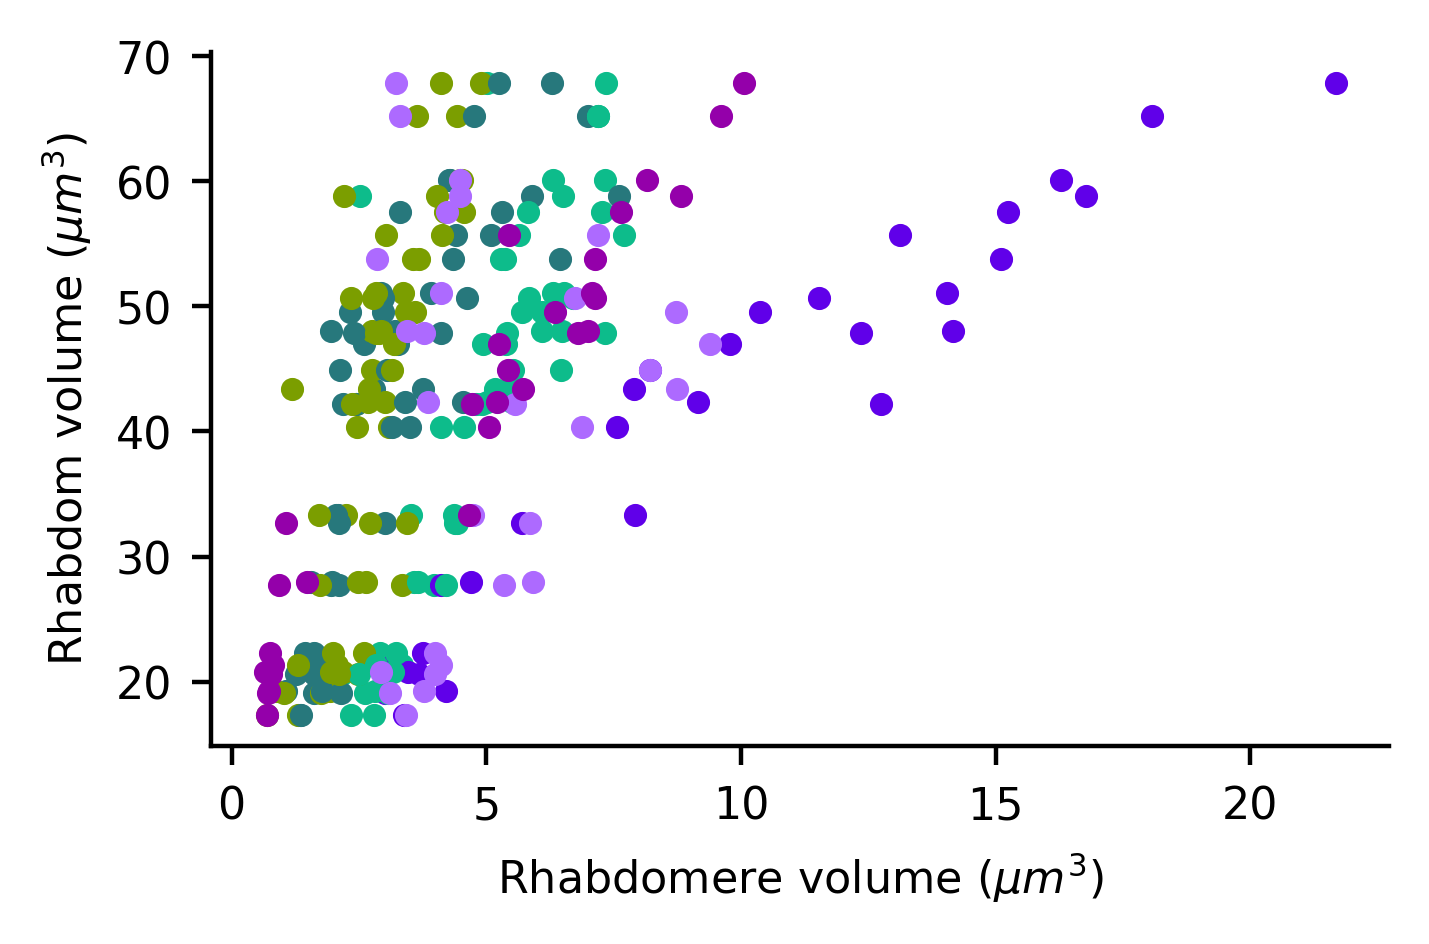

In [47]:
fig, ax = plt.subplots(1) 
for this_rtype, vol in vol_df.iteritems():
#     if this_rtype == 'R_quartet':
#         _x = pd.Series(vol_df.loc[''])
#     if this_rtype in ['R7', 'R8', 'R7p']:
#         continue
    Y = total_vol
    _x = vol_df[this_rtype]
    X = sm.add_constant(_x)

    model = sm.OLS(Y, X)
    results = model.fit()
    params = results.params
    display(results.summary())

    # raw data scatter
    ax.scatter(x=_x, y=Y, c=cell_cm[this_rtype], label=this_rtype, s=10)

    xx = np.arange(0, max(_x))
    #ax.plot(xx, params[])
ax.set_xlabel('Rhabdomere volume ($\mu{m}^{3}$)')
ax.set_ylabel('Rhabdom volume ($\mu{m}^{3}$)')
        
        

In [27]:
# We are interested in both the number of contacts and the number of terminals 
n_terminals = {om: dict.fromkeys(rtypes) for om in ommatidia}
n_contacts = {om: dict.fromkeys(rtypes) for om in ommatidia}
n_outs = link_df['pre_neuron'].value_counts().to_dict() # count of links associated with every neuron

# Filter out non-short PR contacts/terminals
# TODO: helper function to add column for sub sub type (e.g. 'R1' instead of R1R4)
# This can be done from link_df, TODO: MAKE MORE GENERAL AND PUT IN DATAFRAME TOOLS
for pre_name, these_rows in ct_df.groupby('pre_neuron'):
    
    # using our neuron name pattern to get ommatidium/rtypes of indv photoreceptors
    if pre_name[0:2] == 'om' and pre_name[5] == 'R':  
        #if len(pre_name) 
        om = pre_name[2: 4]
        r = pre_name.split('_')[1]
        assert(len(r) in (2, 3))
        n_terminals[om][r] = len(these_rows)
        n_contacts[om][r] = n_outs.get(pre_name, 0)
    else:
        continue

terms = pd.DataFrame(n_terminals).fillna(0).astype(int).T
ctx = pd.DataFrame(n_contacts).fillna(0).astype(int).T

terms.index.name = 'om'
ctx.index.name = 'om'

terms = terms.sort_values(by='om')
ctx = ctx.sort_values(by='om')

frac_ctx = (ctx.T/ctx.sum(axis=1)).T

In [7]:
svfs = ['R1', 'R2', 'R3', 'R4', 'R5', 'R6']
lvfs = ['R7', 'R8', 'R7p']

### Lamina connectivity data
- Before computing correlation, filter out: interommatidial connections, and connections with mean count < 1.0
- Should connections associated with L4, the only cell not present in every ommatidium, be filtered out? (keep for now)

In [8]:
display(f"Number of connections observed (all): {len(cxvecs.columns)}")
mean_thresh = 0.5
cxvecs = cxvecs.loc[:, cxvecs.mean() >= mean_thresh]
display(f"Number of connections observed (where mean count >= {mean_thresh}): {len(cxvecs.columns)}")

only_home_connections = True
if only_home_connections:
    cxvecs = cxvecs.loc[:, [i for i in cxvecs.columns if ('eLMC_4' not in i) and ('eLMC_2' not in i)]]
display(f"Number of connections after removing inter-ommatidial: {len(cxvecs.columns)}")

'Number of connections observed (all): 161'

'Number of connections observed (where mean count >= 0.5): 63'

'Number of connections after removing inter-ommatidial: 55'

## Rhabdomere volumes by subtype
- Long photoreceptor subtypes generally form larger rhabdomeres
- The smallest rhabdomeres belong to photoreceptor pairs R1&R4 and R3&R6

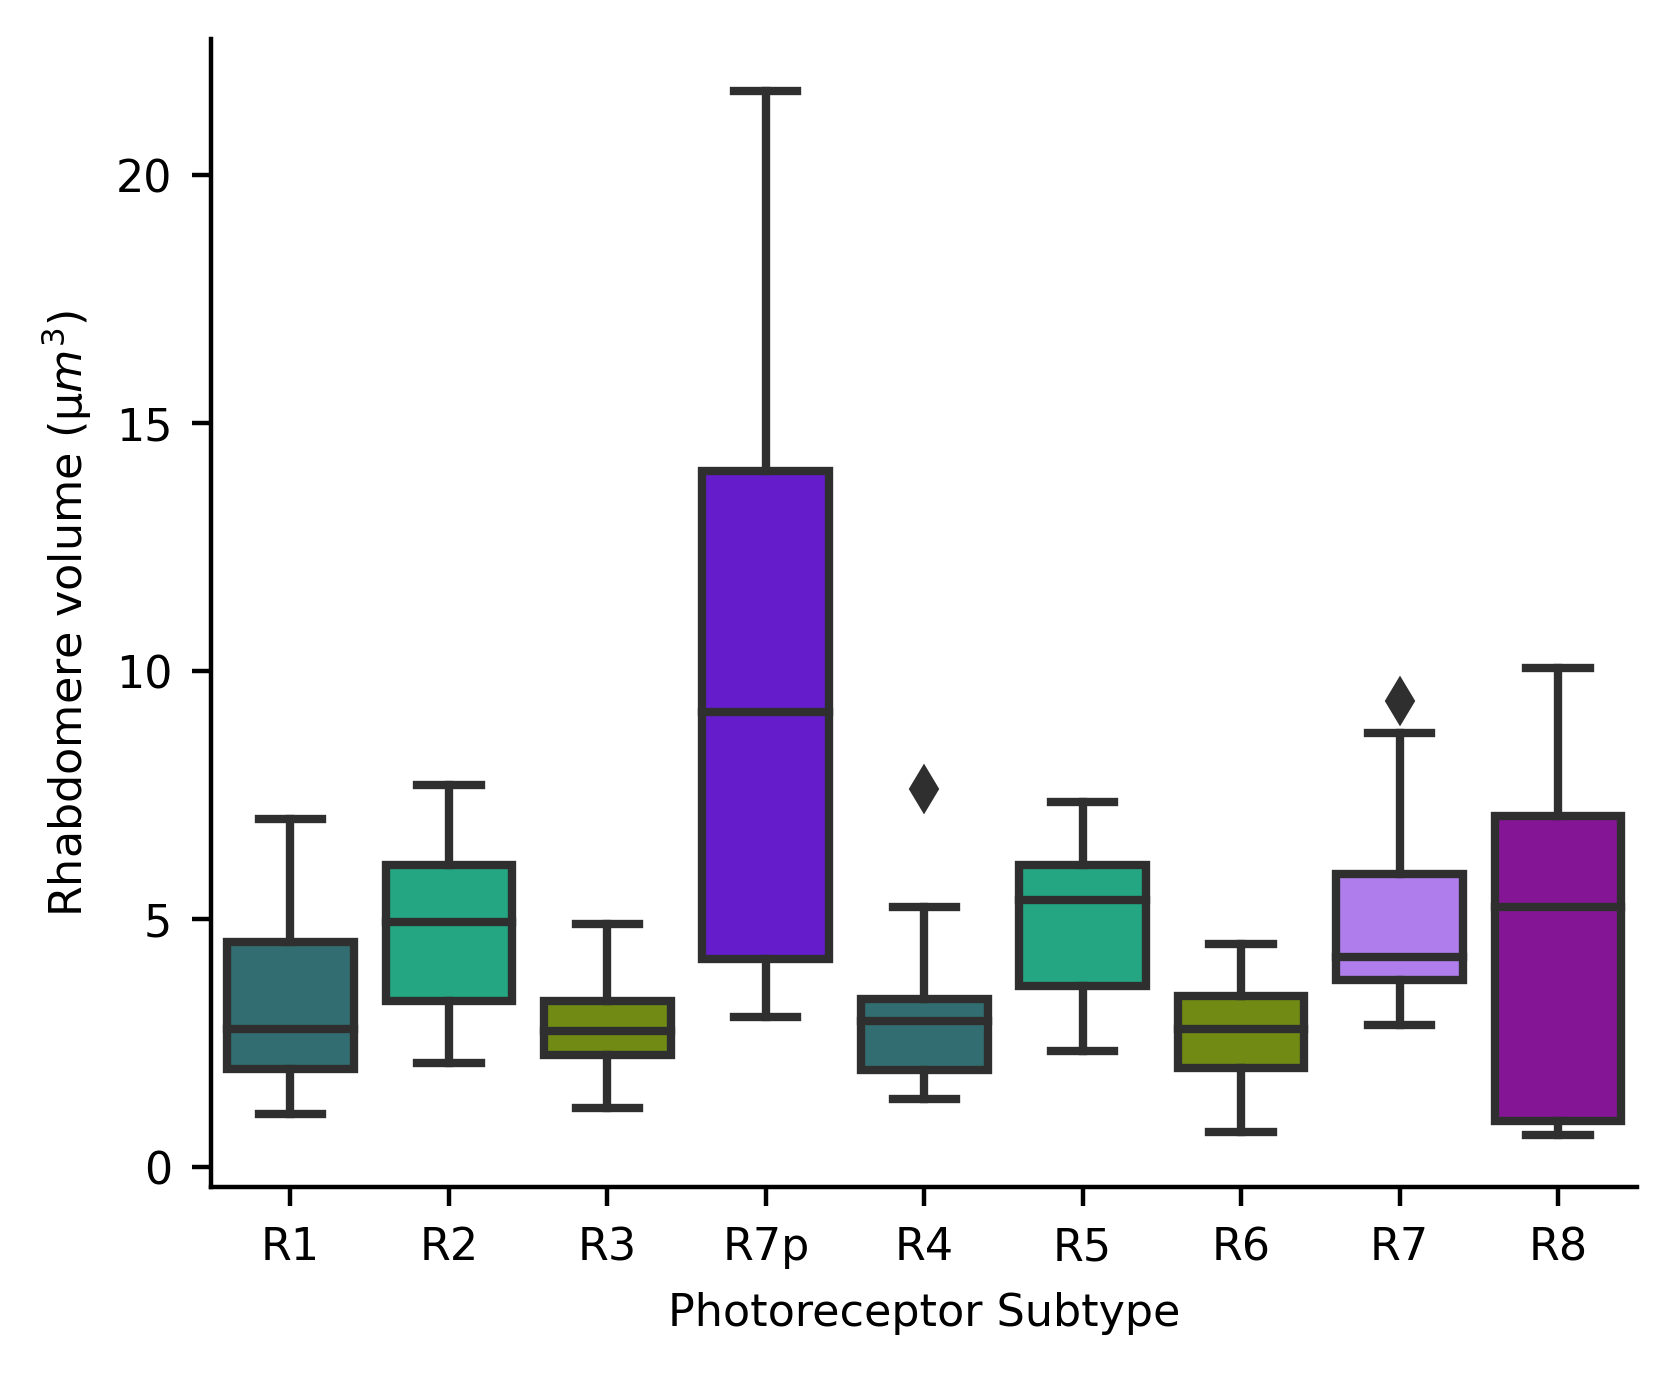

In [9]:
fig, ax = plt.subplots(1, figsize=[4.6, 3.8])
# cm = linear_cmap(n_vals=100, max_colour=(1.0, 1.0, 1.0), min_colour='r')
overall_max = vol_df.max().max()
cm = subtype_cm()

sts = [l.split('_')[0] for l in vol_df.columns]
hues = [cm[c] for c in sts]

#subtypes = sorted(subtypes)
ax = sns.boxplot(data=vol_df, palette=hues)
ax.set_xticklabels([l.split('_')[0] for l in vol_df.columns])
ax.set_xlabel('Photoreceptor Subtype')
ax.set_ylabel('Rhabdomere volume (\u03BC$m^3$)')


plt.show()
if savefigs:
    fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/rhab_vol_box.svg')
    fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/rhab_vol_box.png')


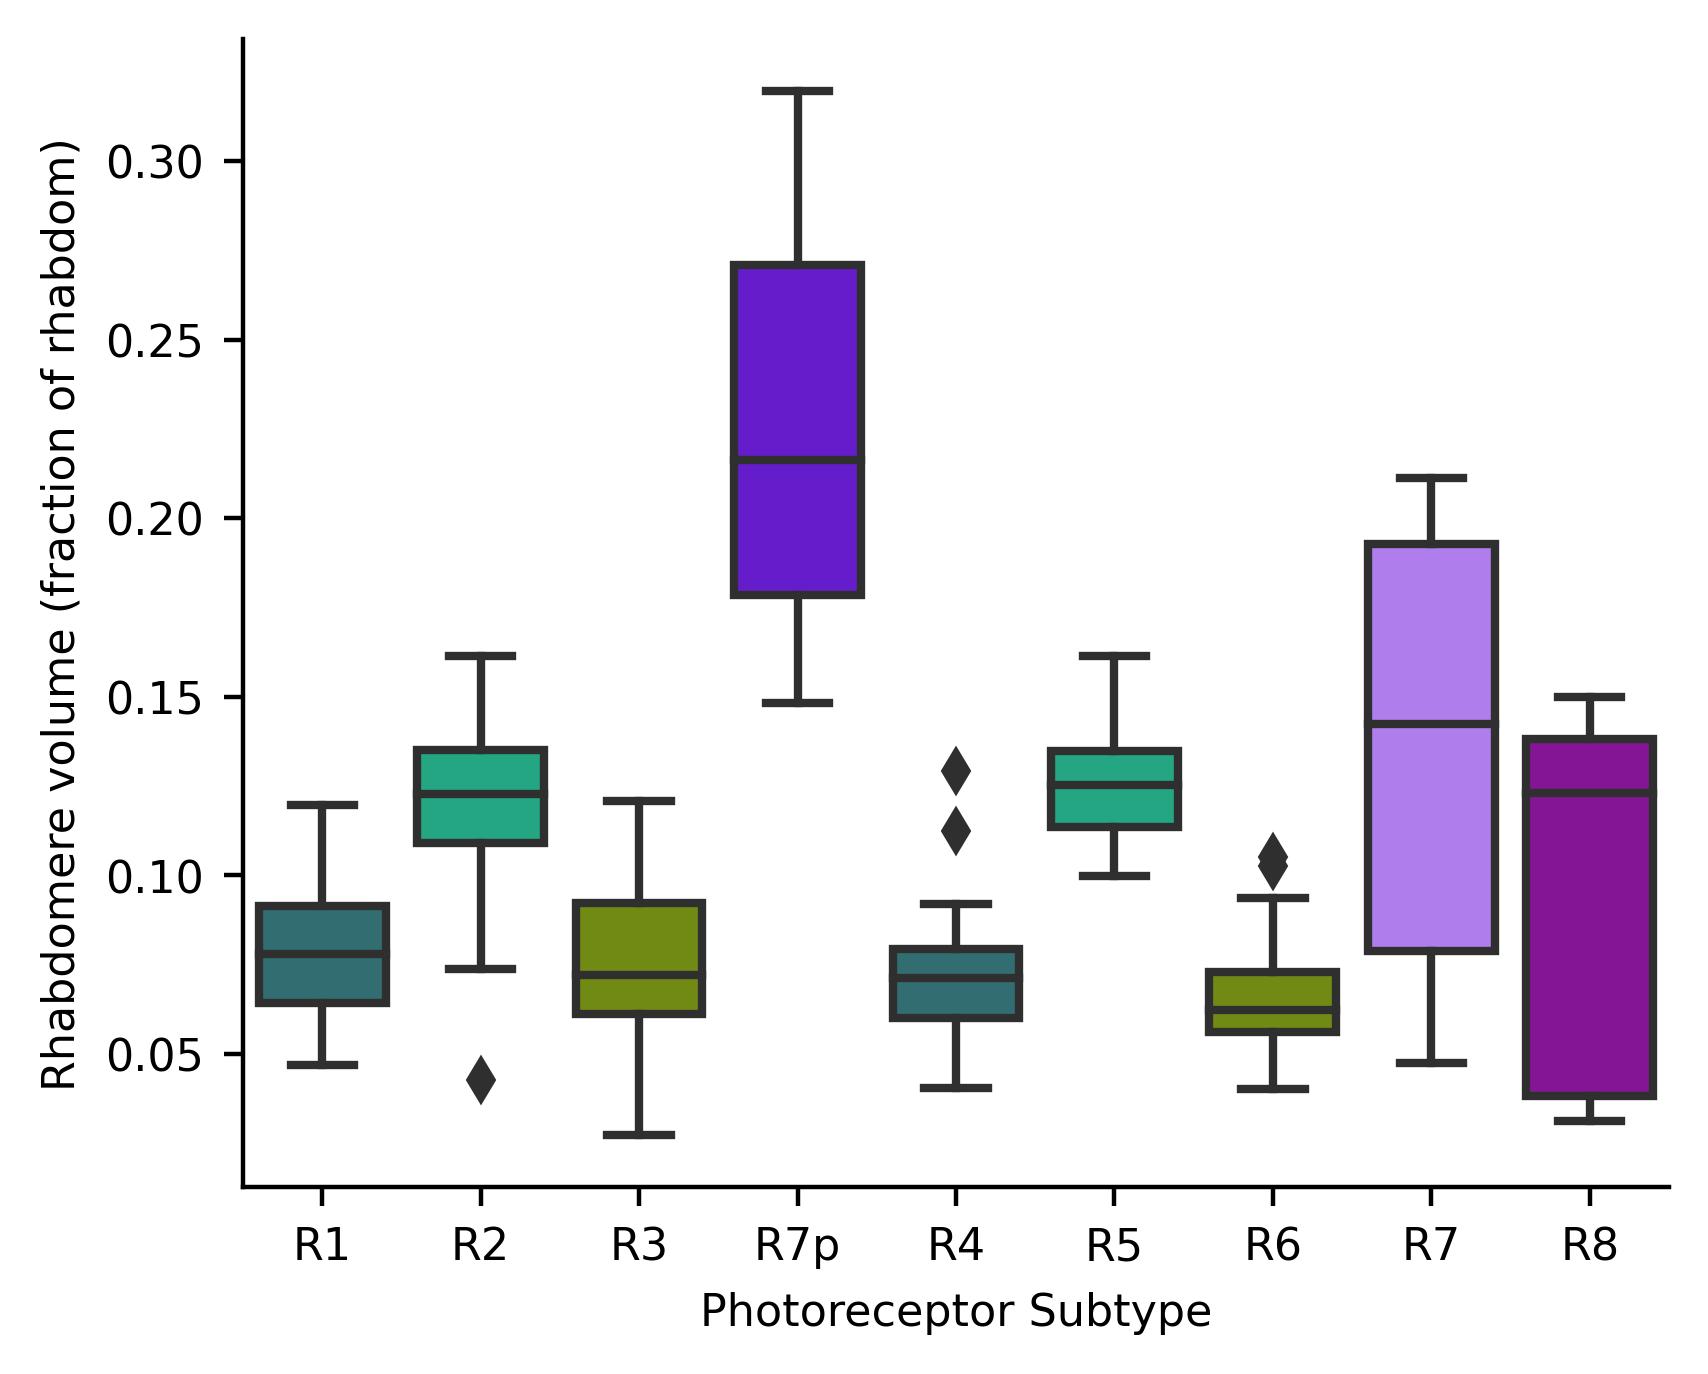

In [10]:
fig, ax = plt.subplots(1, figsize=[4.6, 3.8])
# cm = linear_cmap(n_vals=100, max_colour=(1.0, 1.0, 1.0), min_colour='r')
overall_max = frac_vol.max().max()
cm = subtype_cm()

sts = [l.split('_')[0] for l in frac_vol.columns]
hues = [cm[c] for c in sts]

#subtypes = sorted(subtypes)
ax = sns.boxplot(data=frac_vol, palette=hues)
ax.set_xticklabels([l.split('_')[0] for l in vol_df.columns])
ax.set_xlabel('Photoreceptor Subtype')
ax.set_ylabel('Rhabdomere volume (fraction of rhabdom)')


plt.show()
if savefigs:
    fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/rhab_fracvol_box.svg')
    fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/rhab_fracvol_box.png')


In [11]:
display(frac_vol[svfs].melt().mean())
display(frac_vol[svfs].melt().std(ddof=0))

value    0.090065
dtype: float64

value    0.030526
dtype: float64

In [12]:
display(frac_vol[lvfs].melt().mean())
display(frac_vol[lvfs].melt().std(ddof=0))

value    0.153203
dtype: float64

value    0.071944
dtype: float64

In [ ]:
fig, ax = plt.subplots(1)

for this_st in rtypes:
    ax.scatter()

['R1', 'R2', 'R3', 'R7p', 'R4', 'R5', 'R6', 'R7', 'R8']

/mnt/home/nchua/src/cx-analysis/vis/fig_tools.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  clist = np.array([min_colour, max_colour])


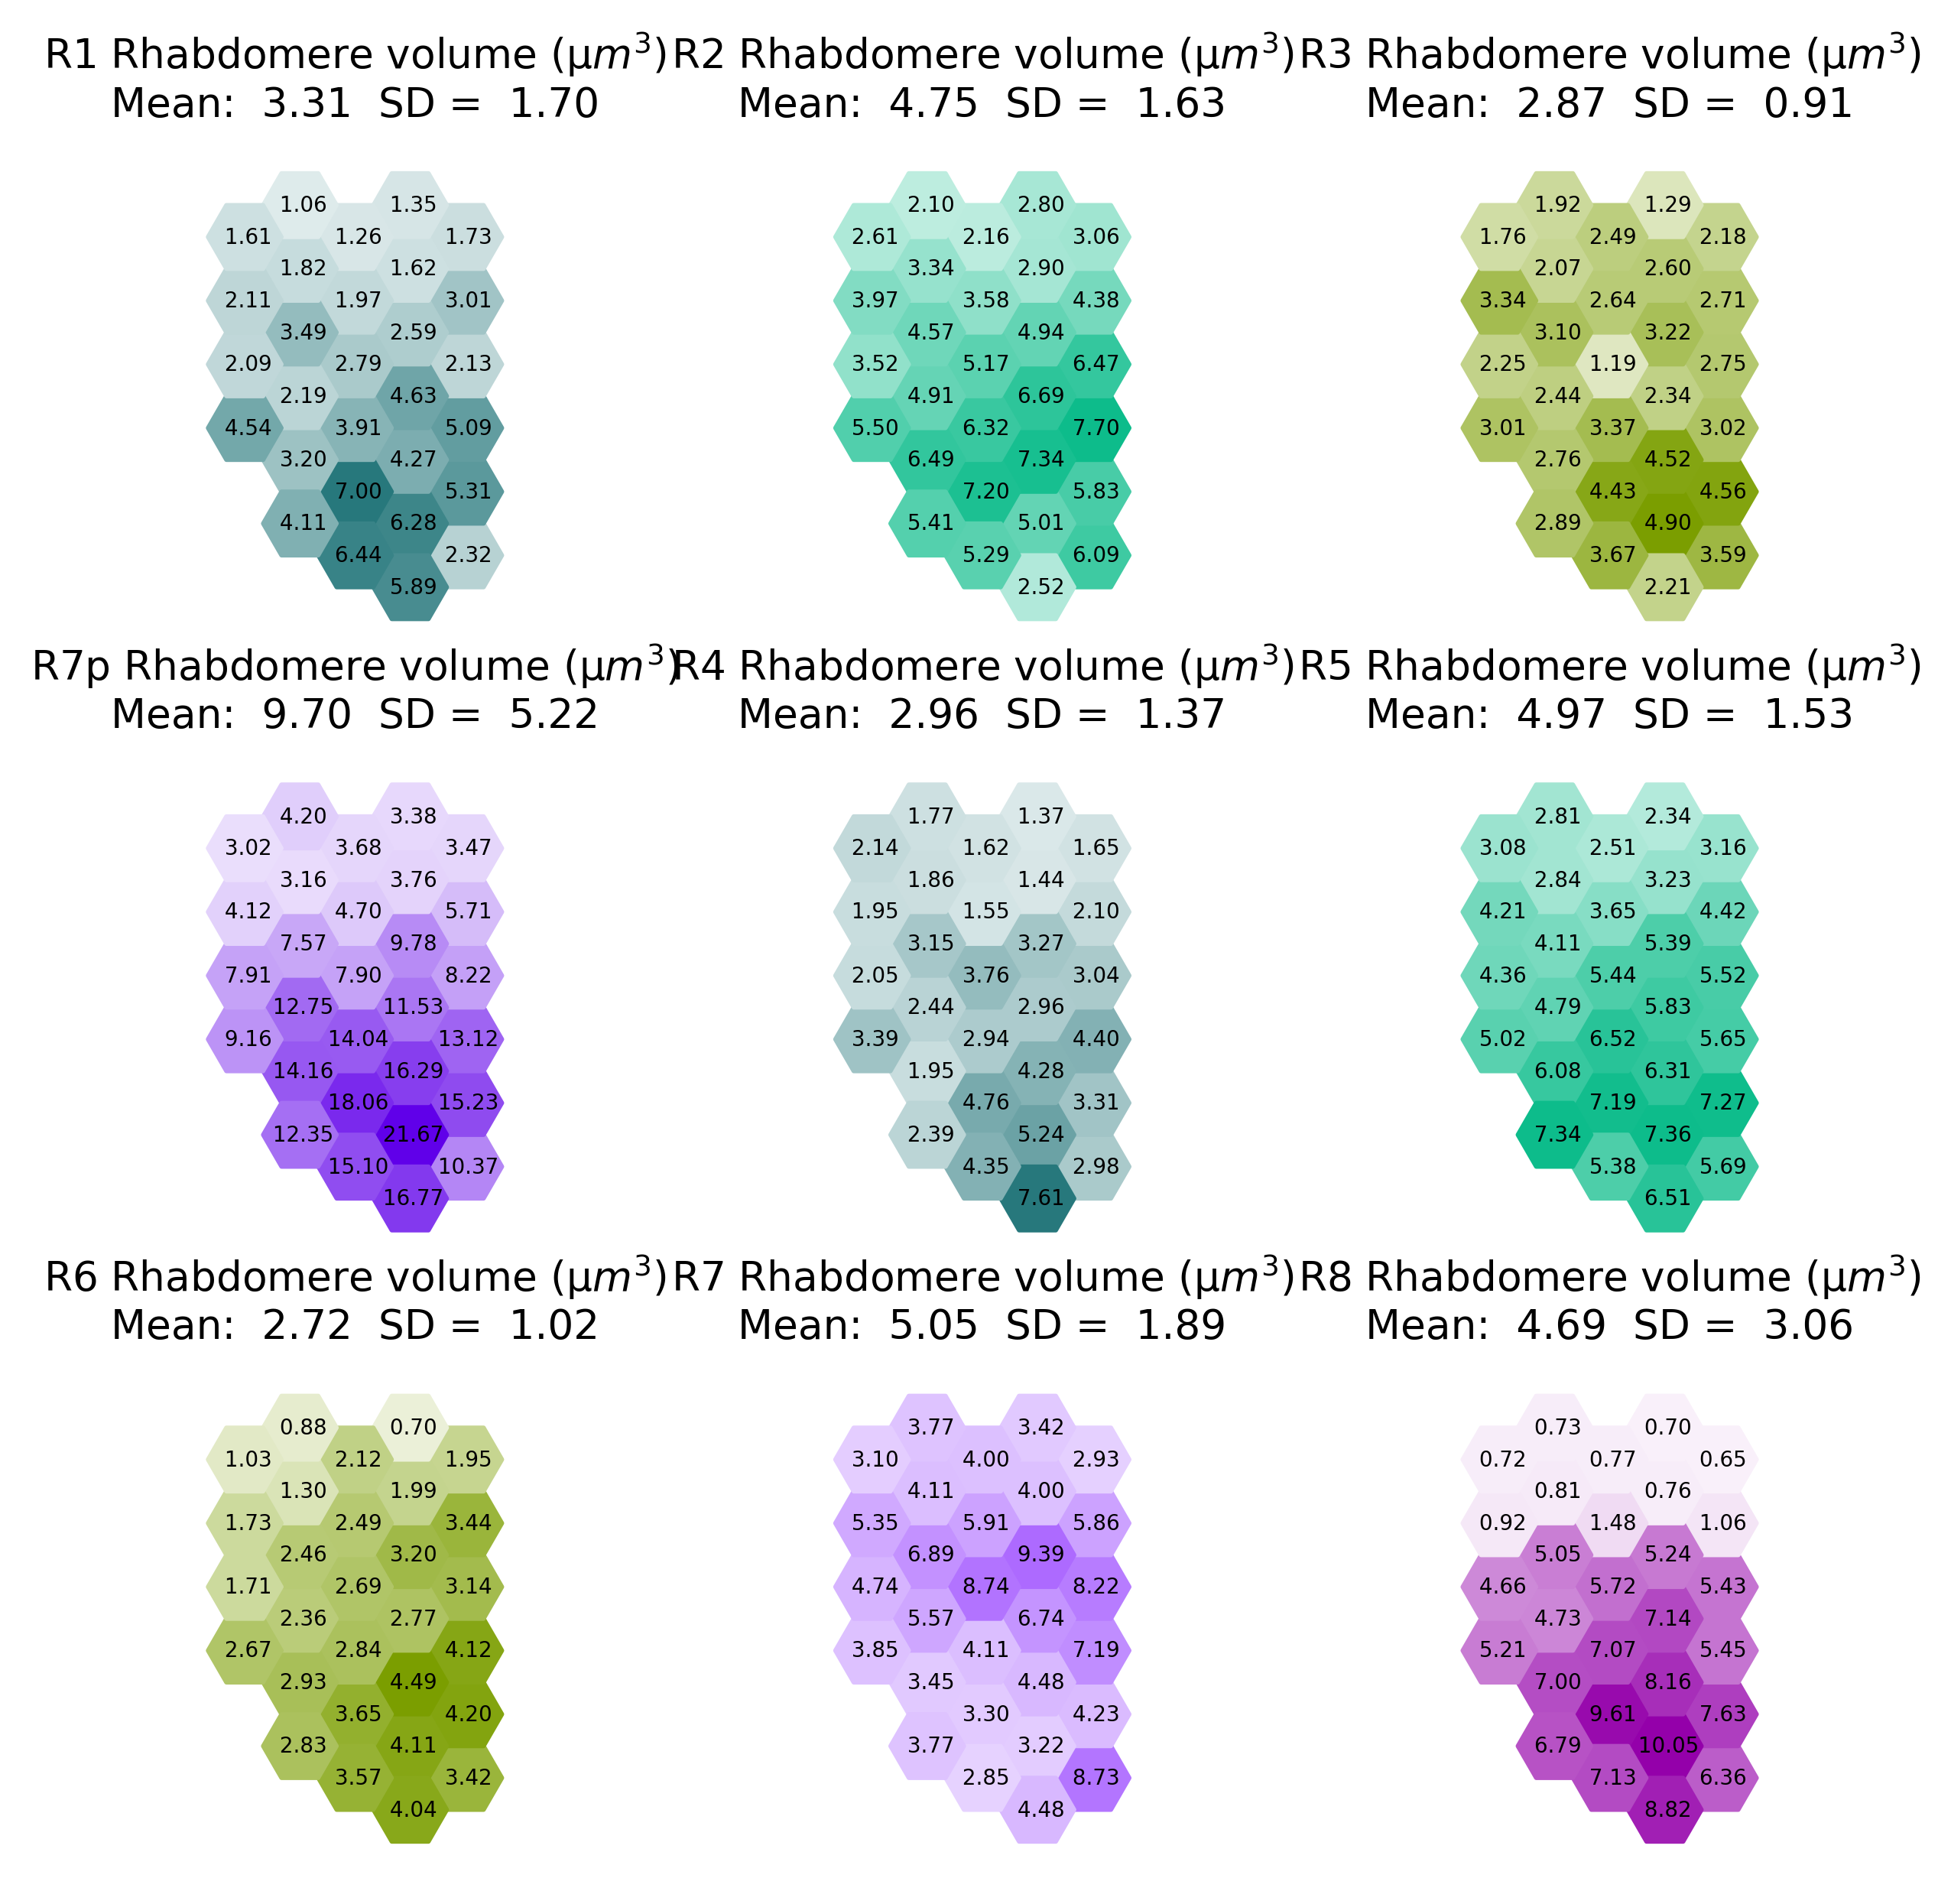

In [13]:
fig, axes = plt.subplots(3, 3, figsize=[2.5*3.0, 2.5*3.0])

display(rtypes)
for ax, this_st in zip(axes.flatten(), rtypes):
    
    node_data = dict.fromkeys(ommatidia)
    this_max = vol_df.loc[:, this_st].max()
    for om in ommatidia:
        x = vol_df.loc[om, this_st]
        # change divisor of colour to x/overall_max to normalize cmap across subtypes
        cm = linear_cmap(100, st_cm[this_st])
        node_data[om] = {'label': f"{x: .2f}",
                         'colour': cm(x/this_max)}
    ax.set_title(f"{this_st.split('_')[0]} Rhabdomere volume (\u03BC$m^3$)\n" + 
                 f"Mean: {vol_df[this_st].mean(): .2f}  " +
                 f"SD = {vol_df[this_st].std(ddof=0): .2f}")
    hexplot(node_data=node_data, ax=ax)
plt.show()
    
if savefigs:
    fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/pr_vol_hex.svg')
    fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/pr_vol_hex.png')

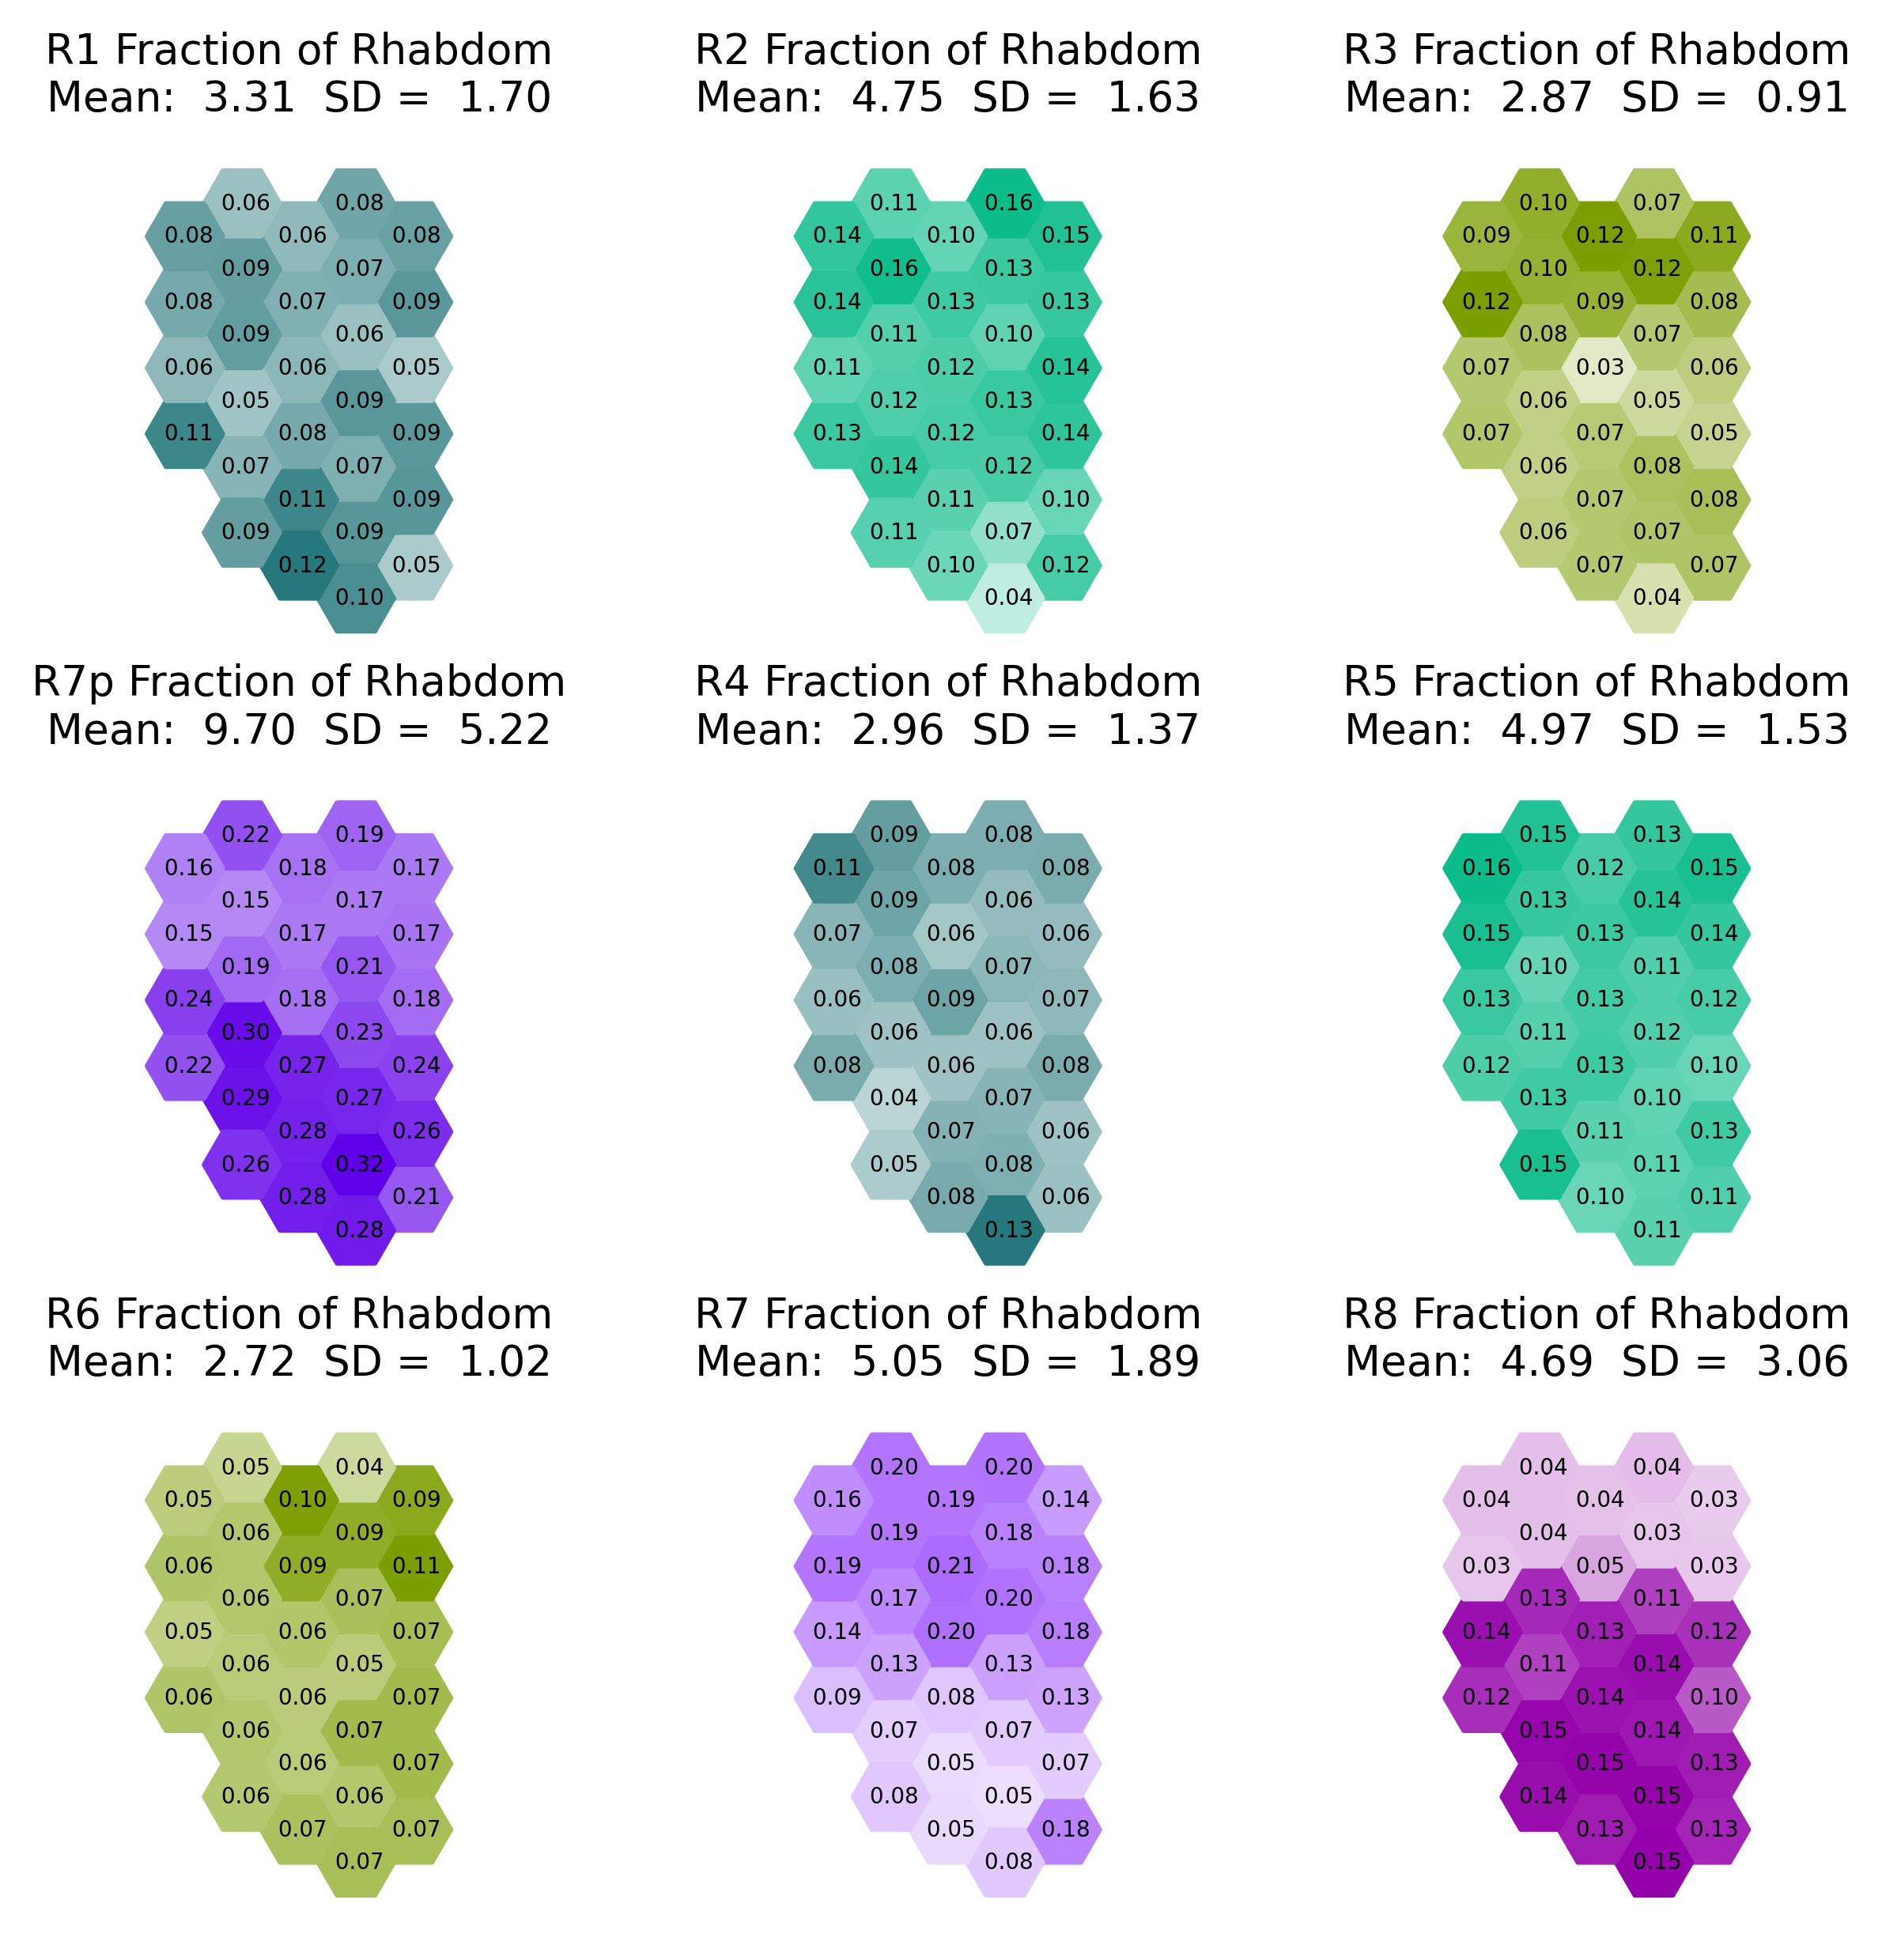

In [14]:
fig, axes = plt.subplots(3, 3, figsize=[2.5*3.0, 2.5*3.0])


for ax, this_st in zip(axes.flatten(), rtypes):
    
    node_data = dict.fromkeys(ommatidia)
    this_max = frac_vol.loc[:, this_st].max()
    for om in ommatidia:
        cm = linear_cmap(100, st_cm[this_st])
        x = frac_vol.loc[om, this_st]
        # change divisor of colour to x/overall_max to normalize cmap across subtypes
        node_data[om] = {'label': f"{x: .2f}",
                         'colour': cm(x/this_max)}
    ax.set_title(f"{this_st.split('_')[0]} Fraction of Rhabdom\n" + 
                 f"Mean: {vol_df[this_st].mean(): .2f}  " +
                 f"SD = {vol_df[this_st].std(ddof=0): .2f}")
    hexplot(node_data=node_data, ax=ax)
plt.show()
    
if savefigs:
    fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/pr_vol_hex.svg')
    fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/pr_vol_hex.png')

In [15]:
display(frac_vol['R7p'])
for om in ommatidia:
    if frac_vol.loc[om, 'R7p'] < frac_vol.loc[om].max():
        display(om)
    


om
A0    0.209237
A1    0.264646
A2    0.235304
A3    0.183033
A4    0.174527
A5    0.167030
B0    0.284969
B1    0.319478
B2    0.270884
B3    0.227702
B4    0.207963
B5    0.168506
B6    0.194668
C1    0.280712
C2    0.277013
C3    0.274624
C4    0.182064
C5    0.167910
C6    0.178595
D2    0.257910
D3    0.294847
D4    0.302168
D5    0.187391
D6    0.148299
D7    0.218347
E4    0.216346
E5    0.237504
E6    0.148508
E7    0.158342
Name: R7p, dtype: float64

'A3'

'A4'

'B5'

'B6'

'C4'

'C5'

'C6'

'D6'

'E6'

'E7'

<ipython-input-16-80039168bb8b>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(frac_vol.index, fontsize=5)


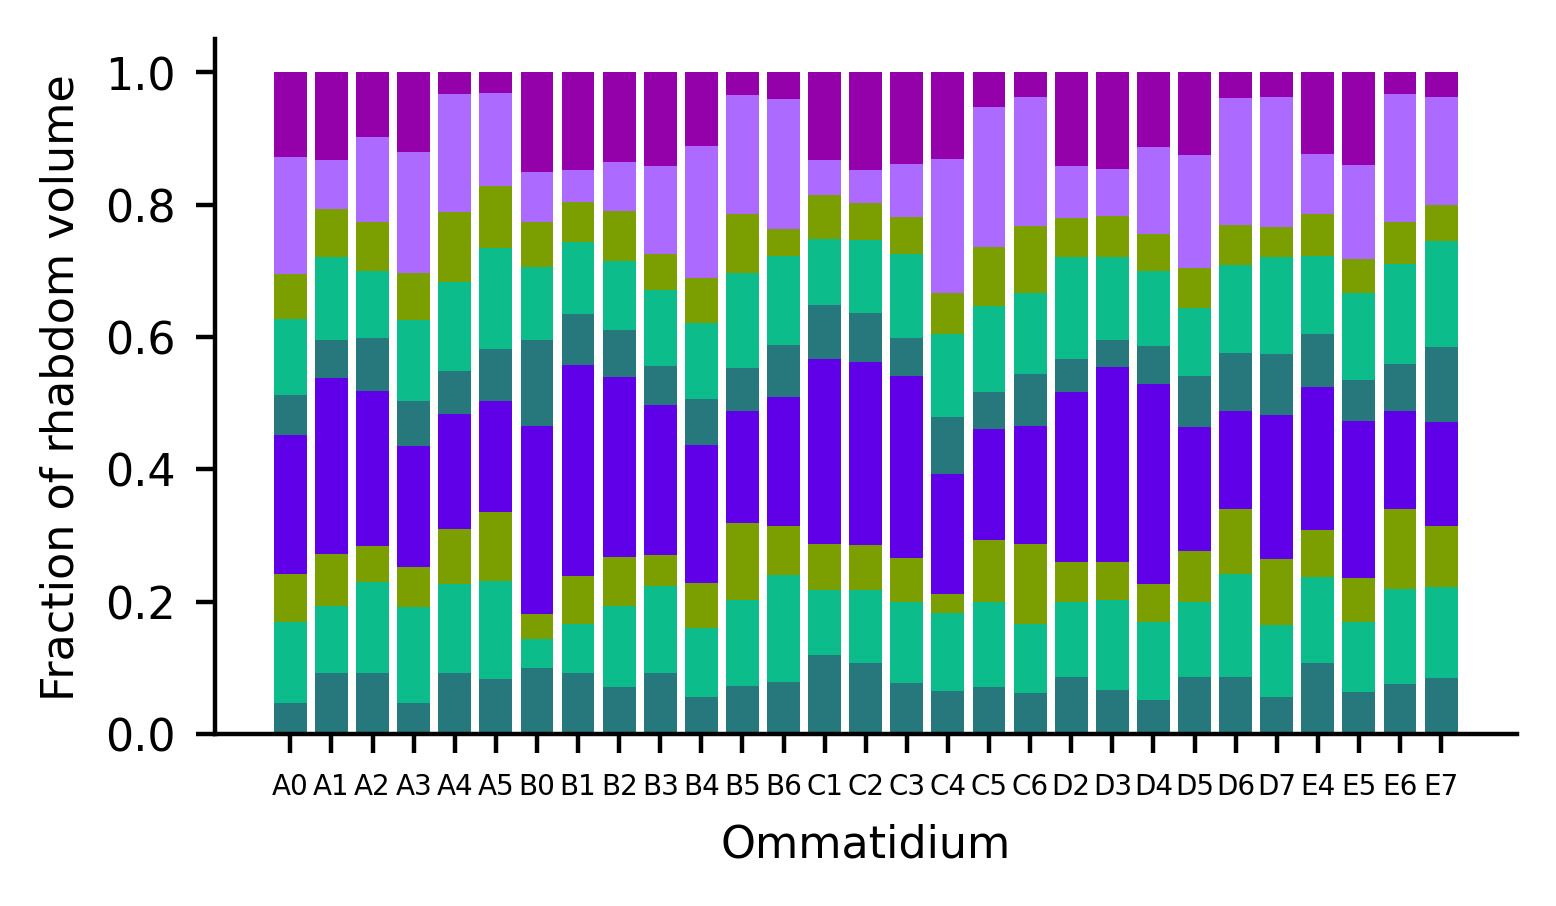

In [16]:
fig, ax = plt.subplots(1, figsize=[4.2, 2.3])

btm = 0.0
for r in rtypes:
    ax.bar(frac_vol.index, frac_vol[r], bottom=btm, color=st_cm[r], label=r)
    btm += frac_vol[r]

ax.set_xlabel('Ommatidium')
ax.set_ylabel('Fraction of rhabdom volume')
ax.set_xticklabels(frac_vol.index, fontsize=5)
        
if savefigs:
    fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/pr_fvol_bars.svg')
    fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/pr_fvol_bars.png')

## Total rhabdom volume varies considerably
- R1-6 and R7' rhabdomere volumes follow closely with total rhabdom volume
- R7 and R8 vary according to retinotopic position

Text(0.5, 1.0, 'Total rhabdom volume (μ$m^3$)\nMean:  41.0\nSD =  15.4\n')

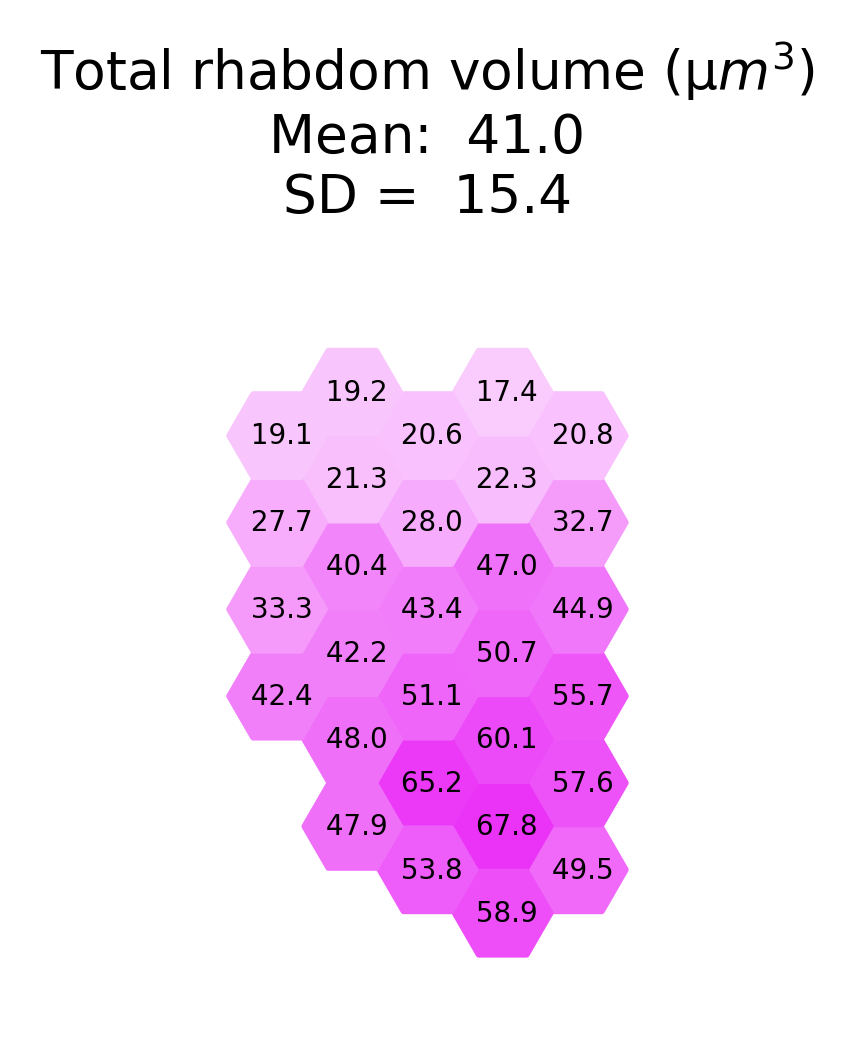

In [17]:
fig, ax = plt.subplots(1)
cm = linear_cmap(100, st_cm['LMC_1'])

total_vol = vol_df.sum(axis=1).rename('Total volume')
#display(total_vol)
max_total = total_vol.max()
node_data = dict.fromkeys(ommatidia)

for k, v in node_data.items():
    
    x = total_vol[k]
    node_data[k] = {"colour": cm(x/max_total),
                    "label": f"{x: .1f}"}

hexplot(node_data, ax=ax, scale_factor=0.05)
ax.set_title(f"Total rhabdom volume (\u03BC$m^3$)\n" + 
             f"Mean: {total_vol.mean(): .1f}\n" +
             f"SD = {total_vol.std(): .1f}\n")
             

Text(0.5, 1.0, 'Total synaptic connections\nMean:  672\nSD =  72\n')

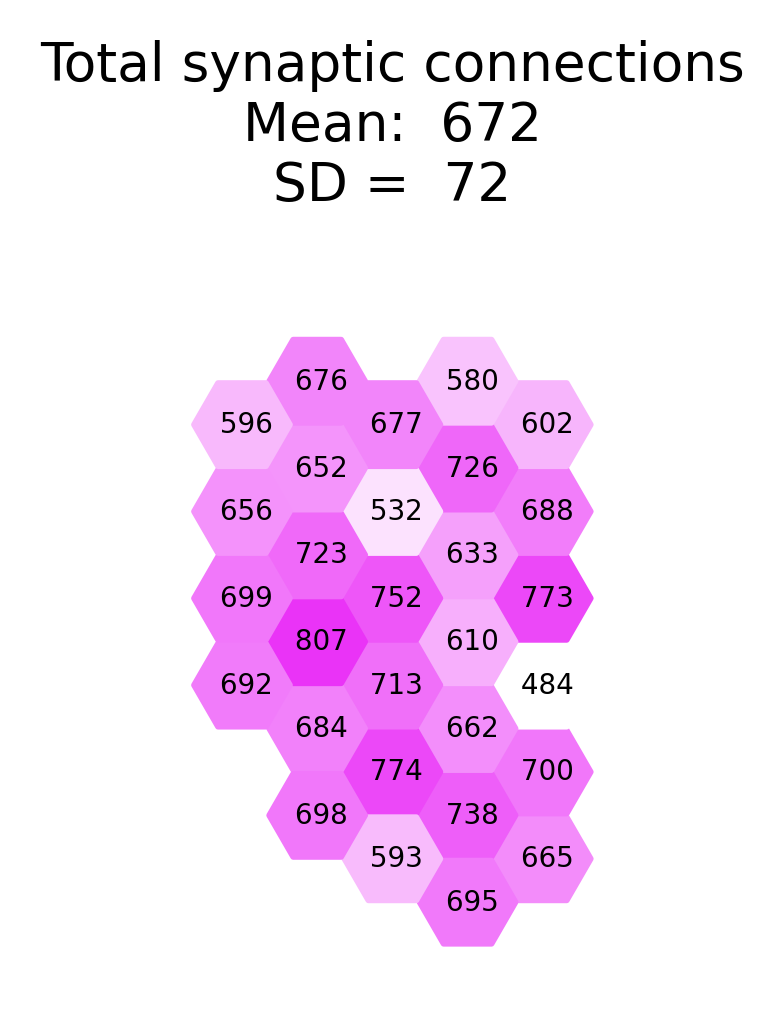

In [18]:
fig, ax = plt.subplots(1)
total_range = total_syn.max() - total_syn.min()

node_data = dict.fromkeys(ommatidia)
for k, v in node_data.items():
    x = total_syn[k]
    node_data[k] = {"colour": cm((x-total_syn.min())/total_range),
                    "label": f"{x: .0f}"}
hexplot(node_data, ax=ax, scale_factor=0.05)
ax.set_title(f"Total synaptic connections\n" + 
             f"Mean: {total_syn.mean(): .0f}\n" +
             f"SD = {total_syn.std(): .0f}\n")
             

## Total number of lamina synapses does not corelate significantly with total rhabdom volume

In [19]:
X = total_vol
X = sm.add_constant(X)
Y = total_syn

model = sm.OLS(Y, X)
results = model.fit()

display(results.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     1.812
Date:                Fri, 22 Jan 2021   Prob (F-statistic):              0.190
Time:                        12:21:23   Log-Likelihood:                -163.89
No. Observations:                  29   AIC:                             331.8
Df Residuals:                      27   BIC:                             334.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          623.3162     38.332     16.261      0.000     544.666     701.966
Total volume     1.1807      0.877      1.346      0.190      -0.619       2.981
==============================================================================
Omnibus:                        6.216   Durbin-Watson:                   2.334
Prob(Omnibus):                  0.045   Jarque-Bera (JB):                4.408
Skew:                          -0.784   Prob(JB):                        0.110
Kurtosis:                       4.089   Cond. No.                         126.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## R1-6 rhabdomere volumes correlate with the the number of output synapses they form in the lamina

In [20]:
X = vol_df.loc[:, svfs].values.flatten()
X = sm.add_constant(X)

Y = ctx.loc[:, svfs].values.flatten()

model = sm.OLS(Y, X)
results = model.fit()

display(results.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.315
Model:                            OLS   Adj. R-squared:                  0.311
Method:                 Least Squares   F-statistic:                     79.08
Date:                Fri, 22 Jan 2021   Prob (F-statistic):           7.95e-16
Time:                        12:21:23   Log-Likelihood:                -752.05
No. Observations:                 174   AIC:                             1508.
Df Residuals:                     172   BIC:                             1514.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         54.7401      3.305     16.561      0.000      48.216      61.264
x1             7.4182      0.834      8.893      0.000       5.772       9.065
==============================================================================
Omnibus:                        0.076   Durbin-Watson:                   1.827
Prob(Omnibus):                  0.963   Jarque-Bera (JB):                0.062
Skew:                           0.042   Prob(JB):                        0.970
Kurtosis:                       2.962   Cond. No.                         9.92
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

['R1', 'R4']

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.209
Model:                            OLS   Adj. R-squared:                  0.195
Method:                 Least Squares   F-statistic:                     14.81
Date:                Fri, 22 Jan 2021   Prob (F-statistic):           0.000307
Time:                        12:21:23   Log-Likelihood:                -239.06
No. Observations:                  58   AIC:                             482.1
Df Residuals:                      56   BIC:                             486.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         55.3098      4.478     12.352      0.000      46.339      64.280
x1             4.9287      1.281      3.849      0.000       2.363       7.494
==============================================================================
Omnibus:                        0.818   Durbin-Watson:                   1.720
Prob(Omnibus):                  0.664   Jarque-Bera (JB):                0.407
Skew:                          -0.195   Prob(JB):                        0.816
Kurtosis:                       3.130   Cond. No.                         8.38
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

array([55.30982989,  4.92867851])

['R2', 'R5']

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                    0.5598
Date:                Fri, 22 Jan 2021   Prob (F-statistic):              0.457
Time:                        12:21:24   Log-Likelihood:                -230.55
No. Observations:                  58   AIC:                             465.1
Df Residuals:                      56   BIC:                             469.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        100.0656      5.555     18.013      0.000      88.937     111.194
x1             0.8131      1.087      0.748      0.457      -1.364       2.990
==============================================================================
Omnibus:                        1.319   Durbin-Watson:                   1.785
Prob(Omnibus):                  0.517   Jarque-Bera (JB):                1.266
Skew:                          -0.341   Prob(JB):                        0.531
Kurtosis:                       2.760   Cond. No.                         17.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

array([100.06559541,   0.81311158])

['R3', 'R6']

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     6.118
Date:                Fri, 22 Jan 2021   Prob (F-statistic):             0.0164
Time:                        12:21:24   Log-Likelihood:                -238.11
No. Observations:                  58   AIC:                             480.2
Df Residuals:                      56   BIC:                             484.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         55.4925      5.980      9.280      0.000      43.513      67.472
x1             5.0011      2.022      2.473      0.016       0.951       9.052
==============================================================================
Omnibus:                        0.625   Durbin-Watson:                   1.421
Prob(Omnibus):                  0.732   Jarque-Bera (JB):                0.282
Skew:                           0.164   Prob(JB):                        0.869
Kurtosis:                       3.095   Cond. No.                         9.95
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

array([55.49247144,  5.001146  ])

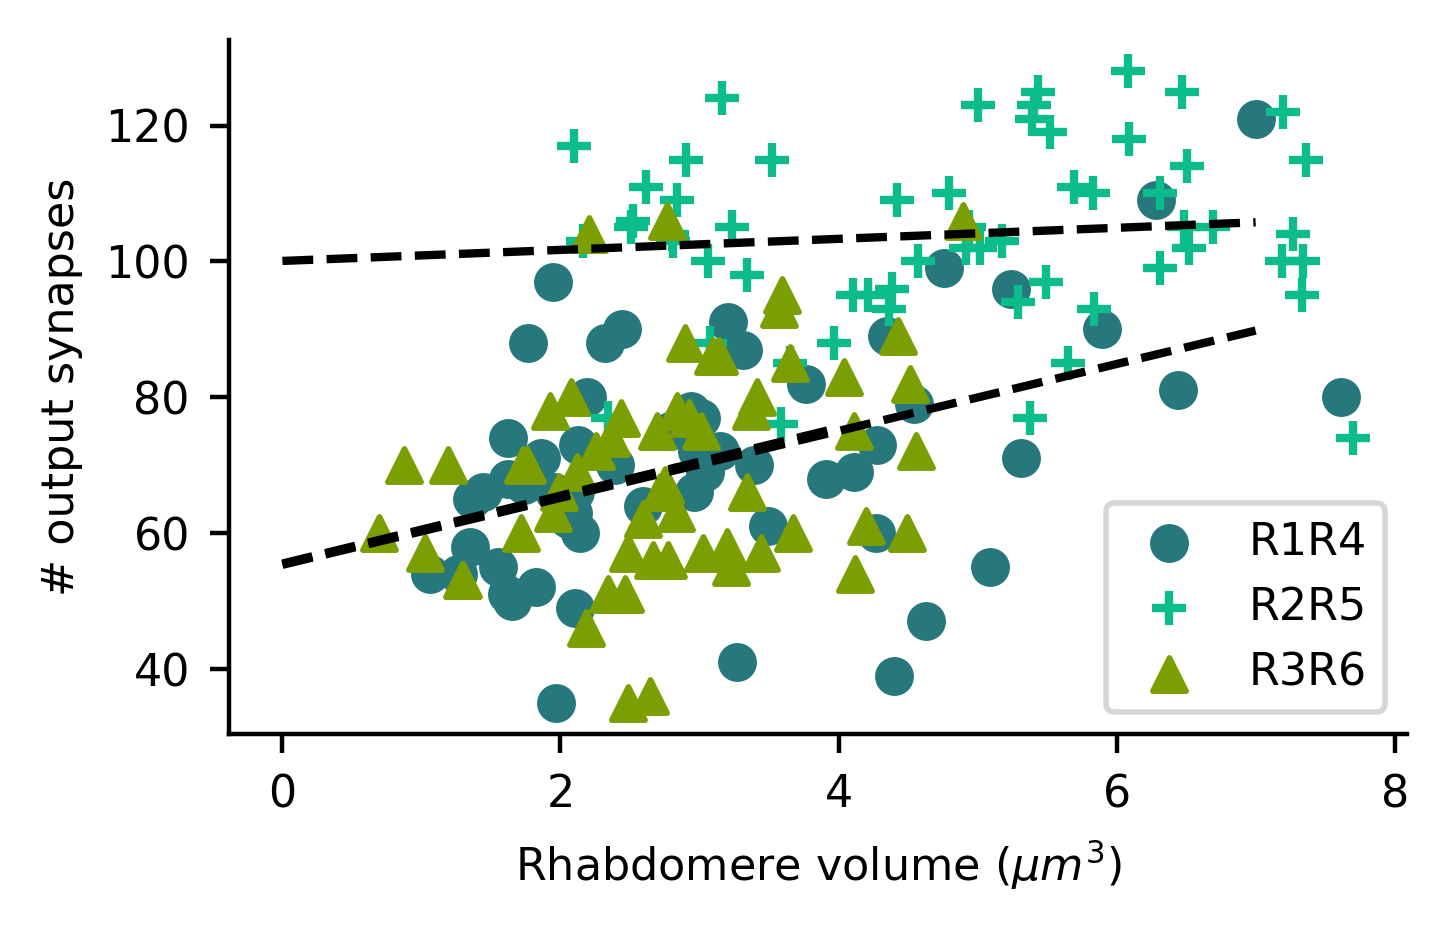

In [21]:
fig, ax = plt.subplots(1)

pairs = [['R1', 'R4'], ['R2', 'R5'], ['R3', 'R6']]
markers = ('o', '+', '^')

for p, m in zip(pairs, markers):
    display(p)
    st_label = p[0] + p[1] # e.g. 'R1R4'
    
    _x = vol_df.loc[:, p].values.flatten()
    X = sm.add_constant(_x)

    Y = ctx.loc[:, p].values.flatten()
    
    model = sm.OLS(Y, X)
    results = model.fit()
    display(results.summary())
    params = results.params
    
    display(params)
    
    #ax.scatter(x=optics_df['cone length (from the tip)'] + optics_df['lense thickness'], y=optics_df["f-image"], c=c)
    ax.scatter(x=_x, y=Y, c=st_cm[st_label], marker=m, label=st_label)
    #ax.set_title(f'$R^{2}$ = {results.rsquared: .2f}, p < {results.f_pvalue: .1e}')
    ax.set_xlabel('Rhabdomere volume ($\mu{m}^3$)')
    ax.set_ylabel("# output synapses")

#xx = np.arange(min(_x), max(_x))
    xx = np.arange(0, max(_x))
    ax.plot(xx, params[0] + params[1] * xx, c='k', ls='--')
ax.legend()
plt.show()
    
    

['R1', 'R4']

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.8335
Date:                Fri, 22 Jan 2021   Prob (F-statistic):              0.365
Time:                        12:21:24   Log-Likelihood:                -245.44
No. Observations:                  58   AIC:                             494.9
Df Residuals:                      56   BIC:                             499.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         62.2933      9.517      6.545      0.000      43.228      81.359
x1           111.4665    122.091      0.913      0.365    -133.111     356.044
==============================================================================
Omnibus:                        1.825   Durbin-Watson:                   1.352
Prob(Omnibus):                  0.402   Jarque-Bera (JB):                1.240
Skew:                           0.348   Prob(JB):                        0.538
Kurtosis:                       3.170   Cond. No.                         55.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

array([ 62.29329201, 111.46652842])

['R2', 'R5']

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     1.362
Date:                Fri, 22 Jan 2021   Prob (F-statistic):              0.248
Time:                        12:21:24   Log-Likelihood:                -230.14
No. Observations:                  58   AIC:                             464.3
Df Residuals:                      56   BIC:                             468.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        115.9135     10.337     11.213      0.000      95.206     136.621
x1           -96.6739     82.848     -1.167      0.248    -262.638      69.290
==============================================================================
Omnibus:                        0.999   Durbin-Watson:                   1.857
Prob(Omnibus):                  0.607   Jarque-Bera (JB):                0.891
Skew:                          -0.294   Prob(JB):                        0.640
Kurtosis:                       2.849   Cond. No.                         49.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

array([115.91347371, -96.67387867])

['R3', 'R6']

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     3.071
Date:                Fri, 22 Jan 2021   Prob (F-statistic):             0.0852
Time:                        12:21:24   Log-Likelihood:                -239.56
No. Observations:                  58   AIC:                             483.1
Df Residuals:                      56   BIC:                             487.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         82.1207      7.496     10.955      0.000      67.104      97.137
x1          -177.3699    101.211     -1.752      0.085    -380.119      25.380
==============================================================================
Omnibus:                        0.851   Durbin-Watson:                   1.507
Prob(Omnibus):                  0.654   Jarque-Bera (JB):                0.915
Skew:                           0.263   Prob(JB):                        0.633
Kurtosis:                       2.681   Cond. No.                         50.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

array([  82.1207315 , -177.36990965])

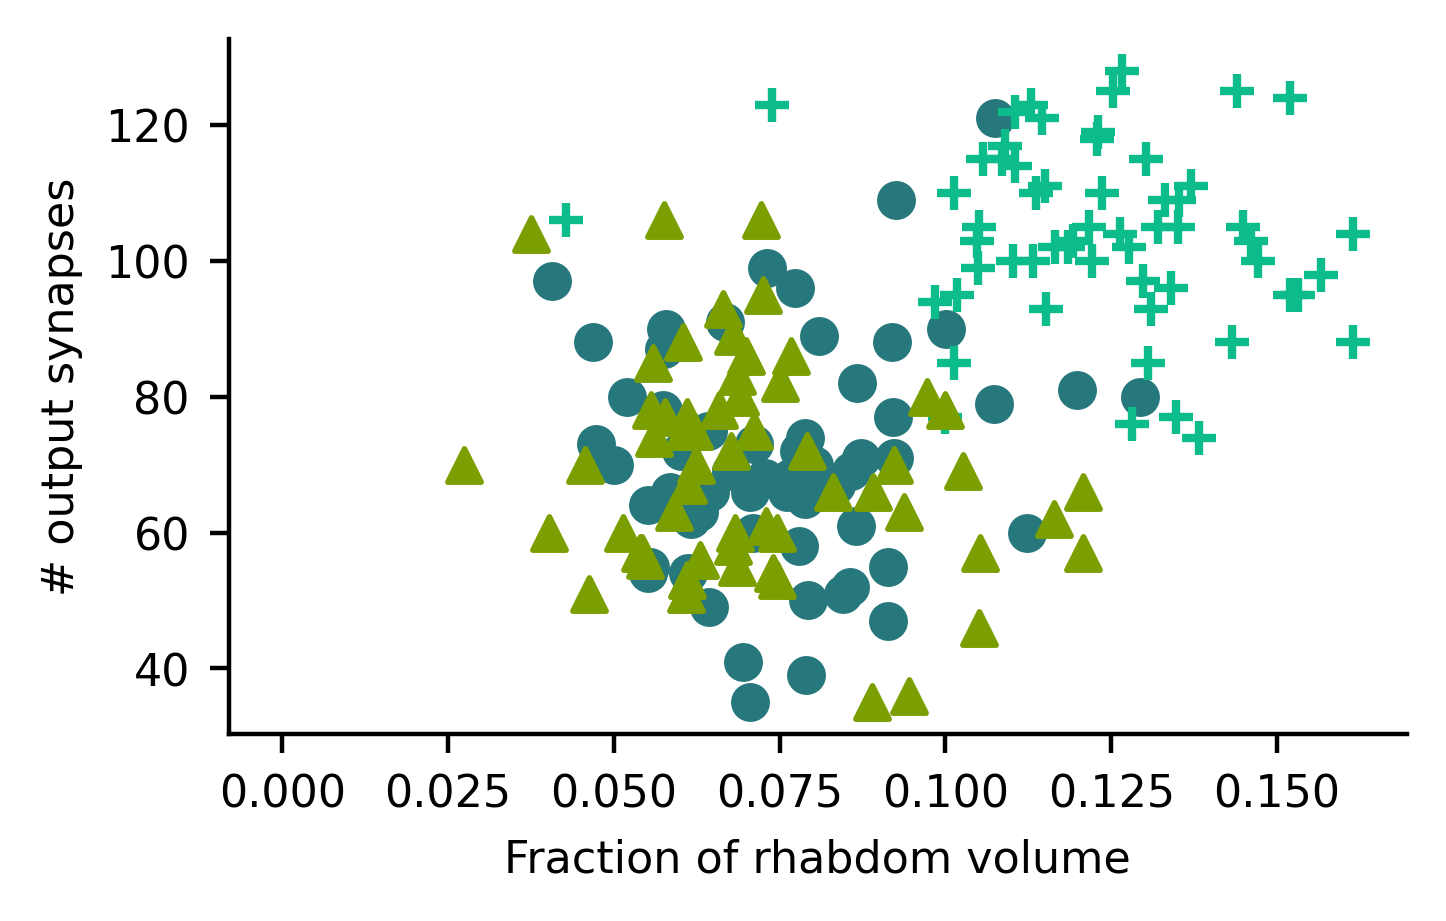

In [22]:
fig, ax = plt.subplots(1)

pairs = [['R1', 'R4'], ['R2', 'R5'], ['R3', 'R6']]
markers = ('o', '+', '^')

for p, m in zip(pairs, markers):
    display(p)
    st_label = p[0] + p[1] # e.g. 'R1R4'
    
    _x = frac_vol.loc[:, p].values.flatten()
    X = sm.add_constant(_x)

    Y = ctx.loc[:, p].values.flatten()
    
    model = sm.OLS(Y, X)
    results = model.fit()
    display(results.summary())
    params = results.params
    
    display(params)
    
    #ax.scatter(x=optics_df['cone length (from the tip)'] + optics_df['lense thickness'], y=optics_df["f-image"], c=c)
    ax.scatter(x=_x, y=Y, c=st_cm[st_label], marker=m)
    #ax.set_title(f'$R^{2}$ = {results.rsquared: .2f}, p < {results.f_pvalue: .1e}')
    ax.set_xlabel('Fraction of rhabdom volume')
    ax.set_ylabel("# output synapses")

#xx = np.arange(min(_x), max(_x))
    xx = np.arange(0, max(_x))
    ax.plot(xx, params[0] + params[1] * xx, c='k', ls='--')

plt.show()
    
    

['R1', 'R4']

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     1.452
Date:                Fri, 22 Jan 2021   Prob (F-statistic):              0.233
Time:                        12:21:24   Log-Likelihood:                 142.18
No. Observations:                  58   AIC:                            -280.4
Df Residuals:                      56   BIC:                            -276.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1297      0.012     10.885      0.000       0.106       0.154
x1             0.1842      0.153      1.205      0.233      -0.122       0.490
==============================================================================
Omnibus:                        0.909   Durbin-Watson:                   2.307
Prob(Omnibus):                  0.635   Jarque-Bera (JB):                0.995
Skew:                          -0.251   Prob(JB):                        0.608
Kurtosis:                       2.601   Cond. No.                         55.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

array([0.12968582, 0.18418469])

['R2', 'R5']

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     3.689
Date:                Fri, 22 Jan 2021   Prob (F-statistic):             0.0599
Time:                        12:21:24   Log-Likelihood:                 133.78
No. Observations:                  58   AIC:                            -263.6
Df Residuals:                      56   BIC:                            -259.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1777      0.019      9.128      0.000       0.139       0.217
x1             0.2998      0.156      1.921      0.060      -0.013       0.612
==============================================================================
Omnibus:                        0.705   Durbin-Watson:                   1.552
Prob(Omnibus):                  0.703   Jarque-Bera (JB):                0.632
Skew:                           0.245   Prob(JB):                        0.729
Kurtosis:                       2.852   Cond. No.                         49.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

array([0.17774987, 0.29975832])

['R3', 'R6']

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                    0.4551
Date:                Fri, 22 Jan 2021   Prob (F-statistic):              0.503
Time:                        12:21:24   Log-Likelihood:                 144.52
No. Observations:                  58   AIC:                            -285.0
Df Residuals:                      56   BIC:                            -280.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1478      0.010     14.820      0.000       0.128       0.168
x1            -0.0908      0.135     -0.675      0.503      -0.361       0.179
==============================================================================
Omnibus:                        2.632   Durbin-Watson:                   2.577
Prob(Omnibus):                  0.268   Jarque-Bera (JB):                2.319
Skew:                           0.386   Prob(JB):                        0.314
Kurtosis:                       2.398   Cond. No.                         50.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

array([ 0.14781119, -0.09084299])

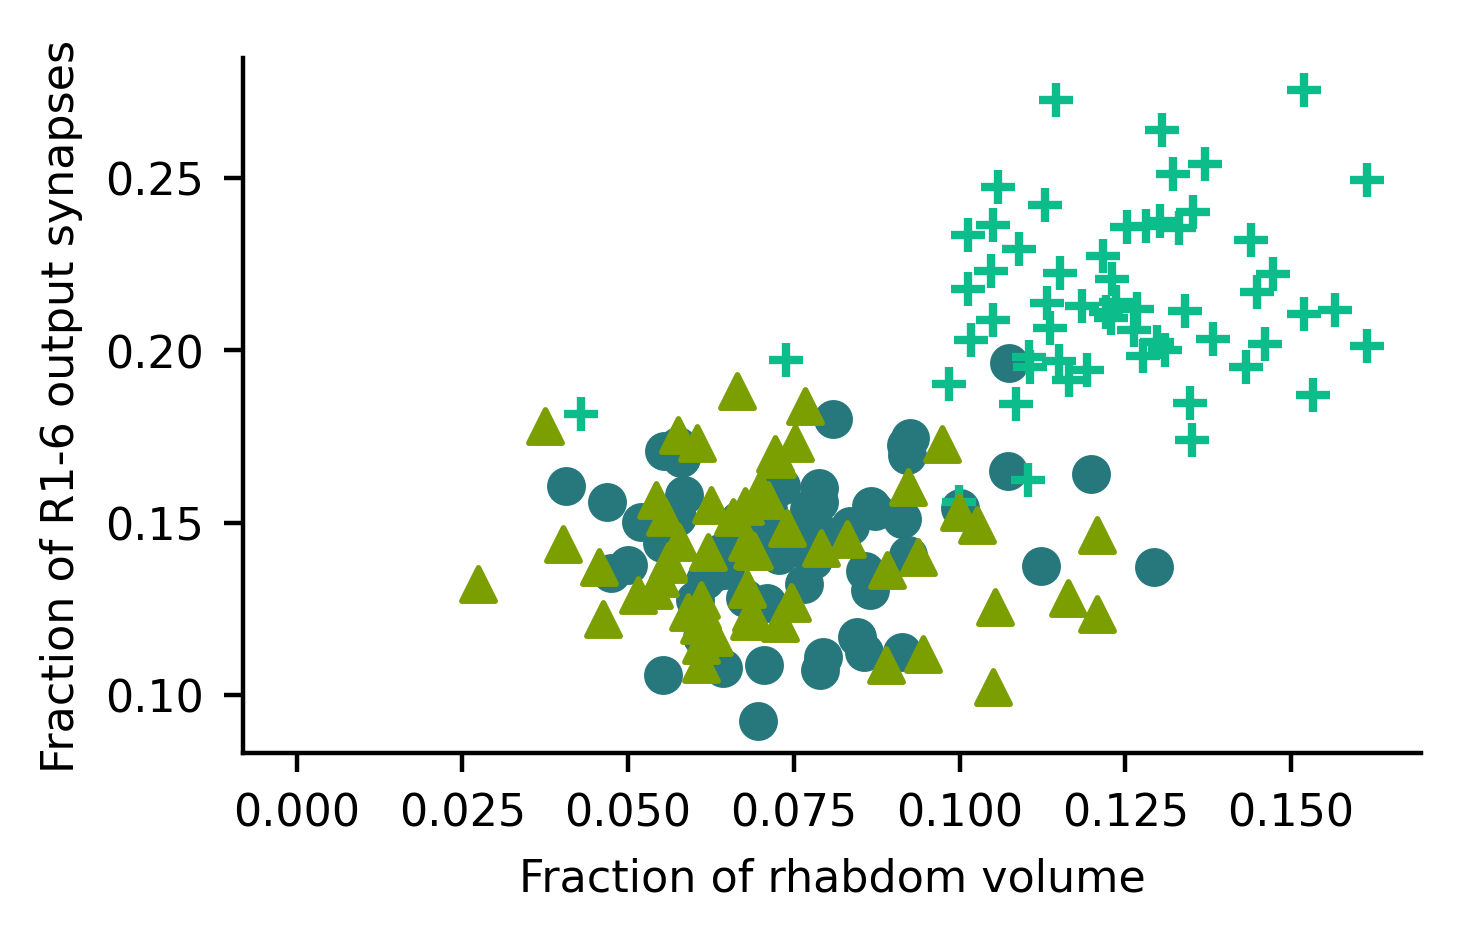

In [23]:
fig, ax = plt.subplots(1)

pairs = [['R1', 'R4'], ['R2', 'R5'], ['R3', 'R6']]
markers = ('o', '+', '^')

for p, m in zip(pairs, markers):
    display(p)
    st_label = p[0] + p[1] # e.g. 'R1R4'
    
    _x = frac_vol.loc[:, p].values.flatten()
    X = sm.add_constant(_x)

    Y = frac_ctx.loc[:, p].values.flatten()
    
    model = sm.OLS(Y, X)
    results = model.fit()
    display(results.summary())
    params = results.params
    
    display(params)
    
    #ax.scatter(x=optics_df['cone length (from the tip)'] + optics_df['lense thickness'], y=optics_df["f-image"], c=c)
    ax.scatter(x=_x, y=Y, c=st_cm[st_label], marker=m)
    #ax.set_title(f'$R^{2}$ = {results.rsquared: .2f}, p < {results.f_pvalue: .1e}')
    ax.set_xlabel('Fraction of rhabdom volume')
    ax.set_ylabel("Fraction of R1-6 output synapses")

#xx = np.arange(min(_x), max(_x))
    xx = np.arange(0, max(_x))
    ax.plot(xx, params[0] + params[1] * xx, c='k', ls='--')

plt.show()
    
    

'R7'

/mnt/home/nchua/miniconda3/envs/wasp-lite/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/mnt/home/nchua/miniconda3/envs/wasp-lite/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1804: RuntimeWarning: invalid value encountered in double_scalars
  return self.mse_model/self.mse_resid
/mnt/home/nchua/miniconda3/envs/wasp-lite/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/mnt/home/nchua/miniconda3/envs/wasp-lite/lib/python3.8/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Fri, 22 Jan 2021   Prob (F-statistic):                nan
Time:                        12:21:24   Log-Likelihood:                    inf
No. Observations:                  29   AIC:                              -inf
Df Residuals:                      27   BIC:                              -inf
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const               0          0        nan        nan           0           0
x1                  0          0        nan        nan           0           0
==============================================================================
Omnibus:                      407.726   Durbin-Watson:                     nan
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               10.875
Skew:                           0.000   Prob(JB):                      0.00435
Kurtosis:                       0.000   Cond. No.                         18.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

array([0., 0.])

'R8'

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.033
Method:                 Least Squares   F-statistic:                   0.09999
Date:                Fri, 22 Jan 2021   Prob (F-statistic):              0.754
Time:                        12:21:24   Log-Likelihood:                -28.467
No. Observations:                  29   AIC:                             60.93
Df Residuals:                      27   BIC:                             63.67
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2568      0.294      0.872      0.391      -0.347       0.861
x1            -0.8497      2.687     -0.316      0.754      -6.363       4.664
==============================================================================
Omnibus:                       50.758   Durbin-Watson:                   2.174
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              239.658
Skew:                           3.656   Prob(JB):                     9.10e-53
Kurtosis:                      15.037   Cond. No.                         21.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

array([ 0.25676986, -0.84965833])

'R7p'

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     1.593
Date:                Fri, 22 Jan 2021   Prob (F-statistic):              0.218
Time:                        12:21:24   Log-Likelihood:                -47.415
No. Observations:                  29   AIC:                             98.83
Df Residuals:                      27   BIC:                             101.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.0863      1.079     -1.007      0.323      -3.300       1.127
x1             5.9801      4.739      1.262      0.218      -3.743      15.703
==============================================================================
Omnibus:                       65.295   Durbin-Watson:                   2.102
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              643.788
Skew:                           4.647   Prob(JB):                    1.60e-140
Kurtosis:                      24.128   Cond. No.                         20.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

array([-1.08631708,  5.98012187])

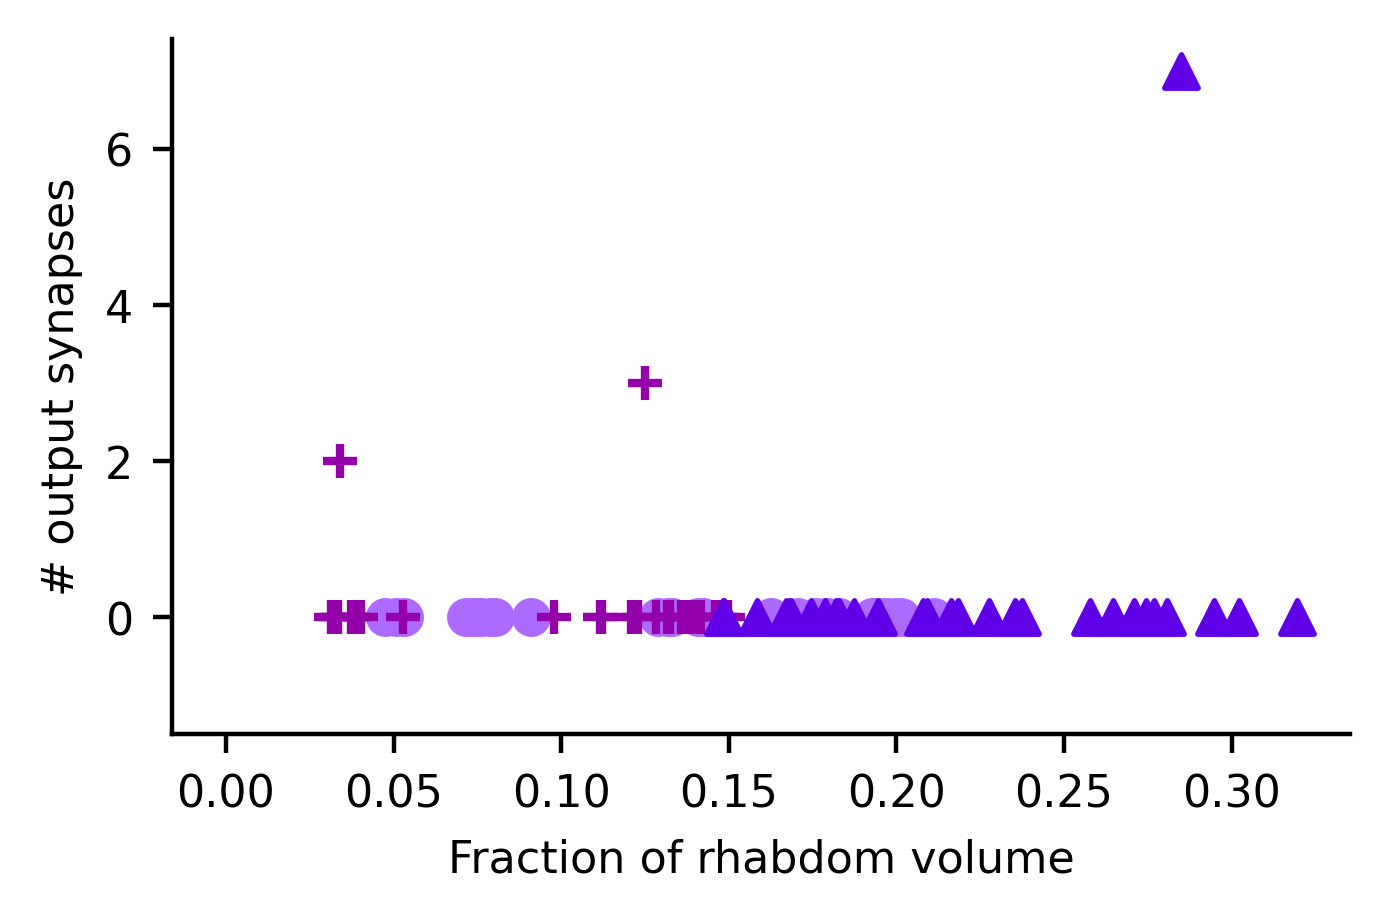

In [24]:
fig, ax = plt.subplots(1)

prs = ["R7", "R8", "R7p"]
markers = ('o', '+', '^')

for p, m in zip(prs, markers):
    display(p)
    st_label = p
    
    _x = frac_vol.loc[:, p].values.flatten()
    X = sm.add_constant(_x)

    Y = ctx.loc[:, p].values.flatten()
    
    model = sm.OLS(Y, X)
    results = model.fit()
    display(results.summary())
    params = results.params
    
    display(params)
    
    #ax.scatter(x=optics_df['cone length (from the tip)'] + optics_df['lense thickness'], y=optics_df["f-image"], c=c)
    ax.scatter(x=_x, y=Y, c=st_cm[st_label], marker=m)
    #ax.set_title(f'$R^{2}$ = {results.rsquared: .2f}, p < {results.f_pvalue: .1e}')
    ax.set_xlabel('Fraction of rhabdom volume')
    ax.set_ylabel("# output synapses")

#xx = np.arange(min(_x), max(_x))
    xx = np.arange(0, max(_x))
    ax.plot(xx, params[0] + params[1] * xx, c='k', ls='--')

plt.show()



In [25]:
X = vol_df.loc[:, 'R1'] - vol_df.loc[:, 'R4']
X = sm.add_constant(X)

Y = ctx.loc[:, 'R1'] - ctx.loc[:, 'R4']

display(X)

model = sm.OLS(Y, X)
results = model.fit()

display(results.summary())

const         0
om                 
A0    1.0 -0.655110
A1    1.0  2.000522
A2    1.0  0.692082
A3    1.0 -0.914104
A4    1.0  0.908693
A5    1.0  0.086129
B0    1.0 -1.718917
B1    1.0  1.038487
B2    1.0 -0.012749
B3    1.0  1.665379
B4    1.0 -0.677747
B5    1.0  0.184079
B6    1.0 -0.014480
C1    1.0  2.092447
C2    1.0  2.241909
C3    1.0  0.974130
C4    1.0 -0.977262
C5    1.0  0.420689
C6    1.0 -0.364061
D2    1.0  1.713116
D3    1.0  1.253798
D4    1.0 -0.253414
D5    1.0  0.346716
D6    1.0 -0.035003
D7    1.0 -0.705539
E4    1.0  1.149004
E5    1.0  0.037376
E6    1.0  0.154046
E7    1.0 -0.527983

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.036
Method:                 Least Squares   F-statistic:                   0.03850
Date:                Fri, 22 Jan 2021   Prob (F-statistic):              0.846
Time:                        12:21:25   Log-Likelihood:                -119.81
No. Observations:                  29   AIC:                             243.6
Df Residuals:                      27   BIC:                             246.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.8885      3.071     -0.615      0.544      -8.190       4.413
0              0.5709      2.910      0.196      0.846      -5.399       6.541
==============================================================================
Omnibus:                        0.897   Durbin-Watson:                   1.627
Prob(Omnibus):                  0.638   Jarque-Bera (JB):                0.817
Skew:                           0.152   Prob(JB):                        0.665
Kurtosis:                       2.236   Cond. No.                         1.42
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
X = total_vol
X = sm.add_constant(X)
Y = spr_syn

model = sm.OLS(Y, X)
results = model.fit()

display(results.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.212
Model:                            OLS   Adj. R-squared:                  0.183
Method:                 Least Squares   F-statistic:                     7.258
Date:                Fri, 22 Jan 2021   Prob (F-statistic):             0.0120
Time:                        12:21:25   Log-Likelihood:                -153.32
No. Observations:                  29   AIC:                             310.6
Df Residuals:                      27   BIC:                             313.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          389.2437     26.626     14.619      0.000     334.611     443.876
Total volume     1.6417      0.609      2.694      0.012       0.391       2.892
==============================================================================
Omnibus:                        7.481   Durbin-Watson:                   2.220
Prob(Omnibus):                  0.024   Jarque-Bera (JB):                5.702
Skew:                          -0.993   Prob(JB):                       0.0578
Kurtosis:                       3.882   Cond. No.                         126.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
X = vol_df.filter(items = [v for v in vol_df.columns if int(v[1]) < 7]).sum(axis=1)
#display(X)
X = sm.add_constant(X)
Y = spr_syn



model = sm.OLS(Y, X)
results = model.fit()

display(results.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.119
Method:                 Least Squares   F-statistic:                     4.782
Date:                Fri, 22 Jan 2021   Prob (F-statistic):             0.0376
Time:                        12:21:25   Log-Likelihood:                -154.41
No. Observations:                  29   AIC:                             312.8
Df Residuals:                      27   BIC:                             315.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        391.9853     31.035     12.630      0.000     328.307     455.664
0              2.9934      1.369      2.187      0.038       0.185       5.802
==============================================================================
Omnibus:                        5.623   Durbin-Watson:                   2.213
Prob(Omnibus):                  0.060   Jarque-Bera (JB):                3.924
Skew:                          -0.834   Prob(JB):                        0.141
Kurtosis:                       3.683   Cond. No.                         73.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Rhabdomere volume as a fraction of total rhabdom volume
- i.e. the fraction of the fused rhabdom occupied by each photoreceptor's rhabdomere
- For most subtypes, this looks more uniformly distributed across the eye
- 

## Subtypes with correlated rhabdomere volumes

In [28]:
# vol_corr = vol_df.corr()  # correlation between PR subtypes
# colors = [st_cm[y.split('_')[0]] for y in vol_corr.columns]

# clus = sns.clustermap(vol_corr, cmap='vlag', col_colors=colors, row_colors=colors, vmin=-1.0, vmax=1.0)

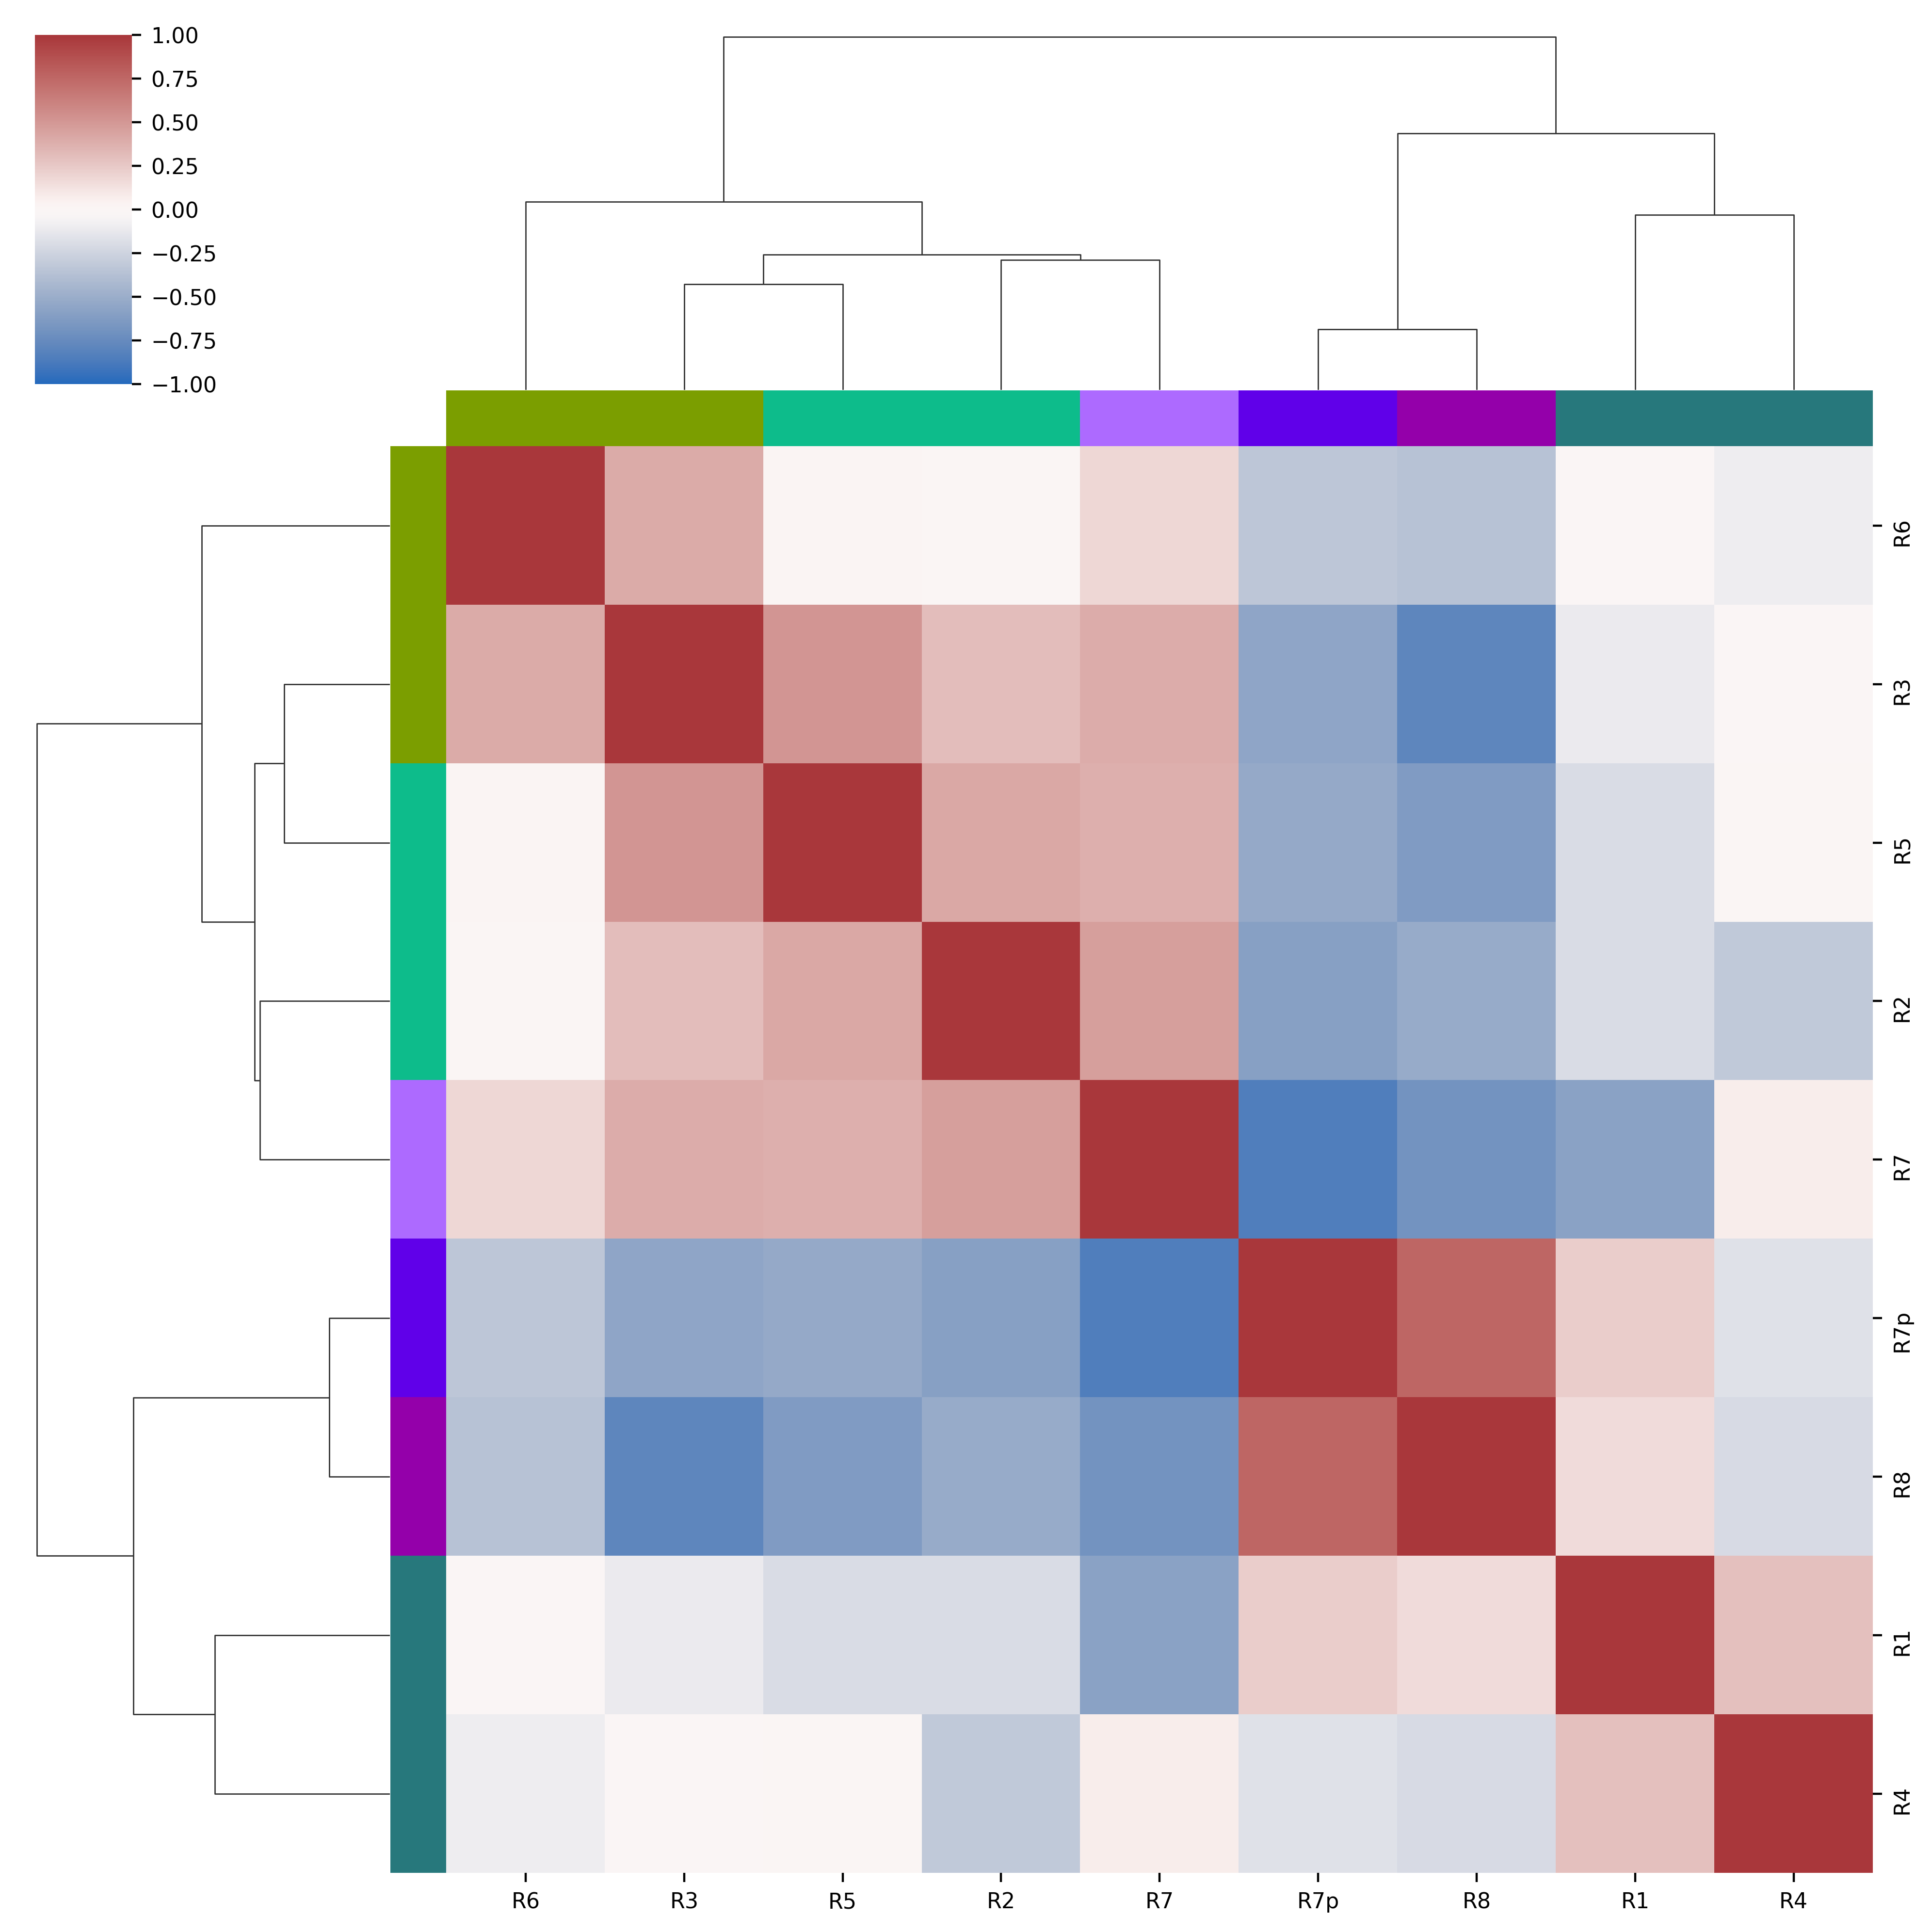

In [29]:
fvol_corr = frac_vol.corr()  # correlation between PR subtypes
colors = [st_cm[y.split('_')[0]] for y in fvol_corr.columns]

clus = sns.clustermap(fvol_corr, cmap='vlag', col_colors=colors, row_colors=colors, 
                      vmin=-1.0, vmax=1.0)
#                       xticklabels=[a.split('_')[0] + '_f' + a.split('_')[1] for a in fvol_corr.columns], 
#                       yticklabels=[a.split('_')[0] + '_f' + a.split('_')[1] for a in fvol_corr.columns])

## Clustering connection counts and rhabdomere volumes by their correlations
- Weird observation:
    - Clustering PRs by the correlations between their *rhabdomere volume* and the connection counts of their lamina cartridge puts photoreceptors on either side of the R1-3/4-6 equator closer together in the heirarchy. Opposing pairs R1 and R4 have the most similar correlations with connection counts, but opposing pairs R2 and R5 are the most dissimilar of R1-6 pairs. 
    - Clustering PRs by the correlations between their *fractional volume* and the connection counts of their lamina cartridge puts photoreceptors with similar microvilli orientation together. 
    

- Using cosine or euclidean distance doesn't visibly change clustering of PR volume variables (this seems to make a difference for fractional volume below). The clustering of connection types looks more interpretable with euclidean distance. 

- Distance between clusters calculated with [UPGMA](https://en.wikipedia.org/wiki/UPGMA), aka 'average' assignment.

In [30]:
# Correlation matrix (cx types x PR types)
combined = pd.concat([cxvecs, vol_df], axis=1)
corr = combined.corr().dropna(axis=0).loc[cxvecs.columns, cxvecs.columns]

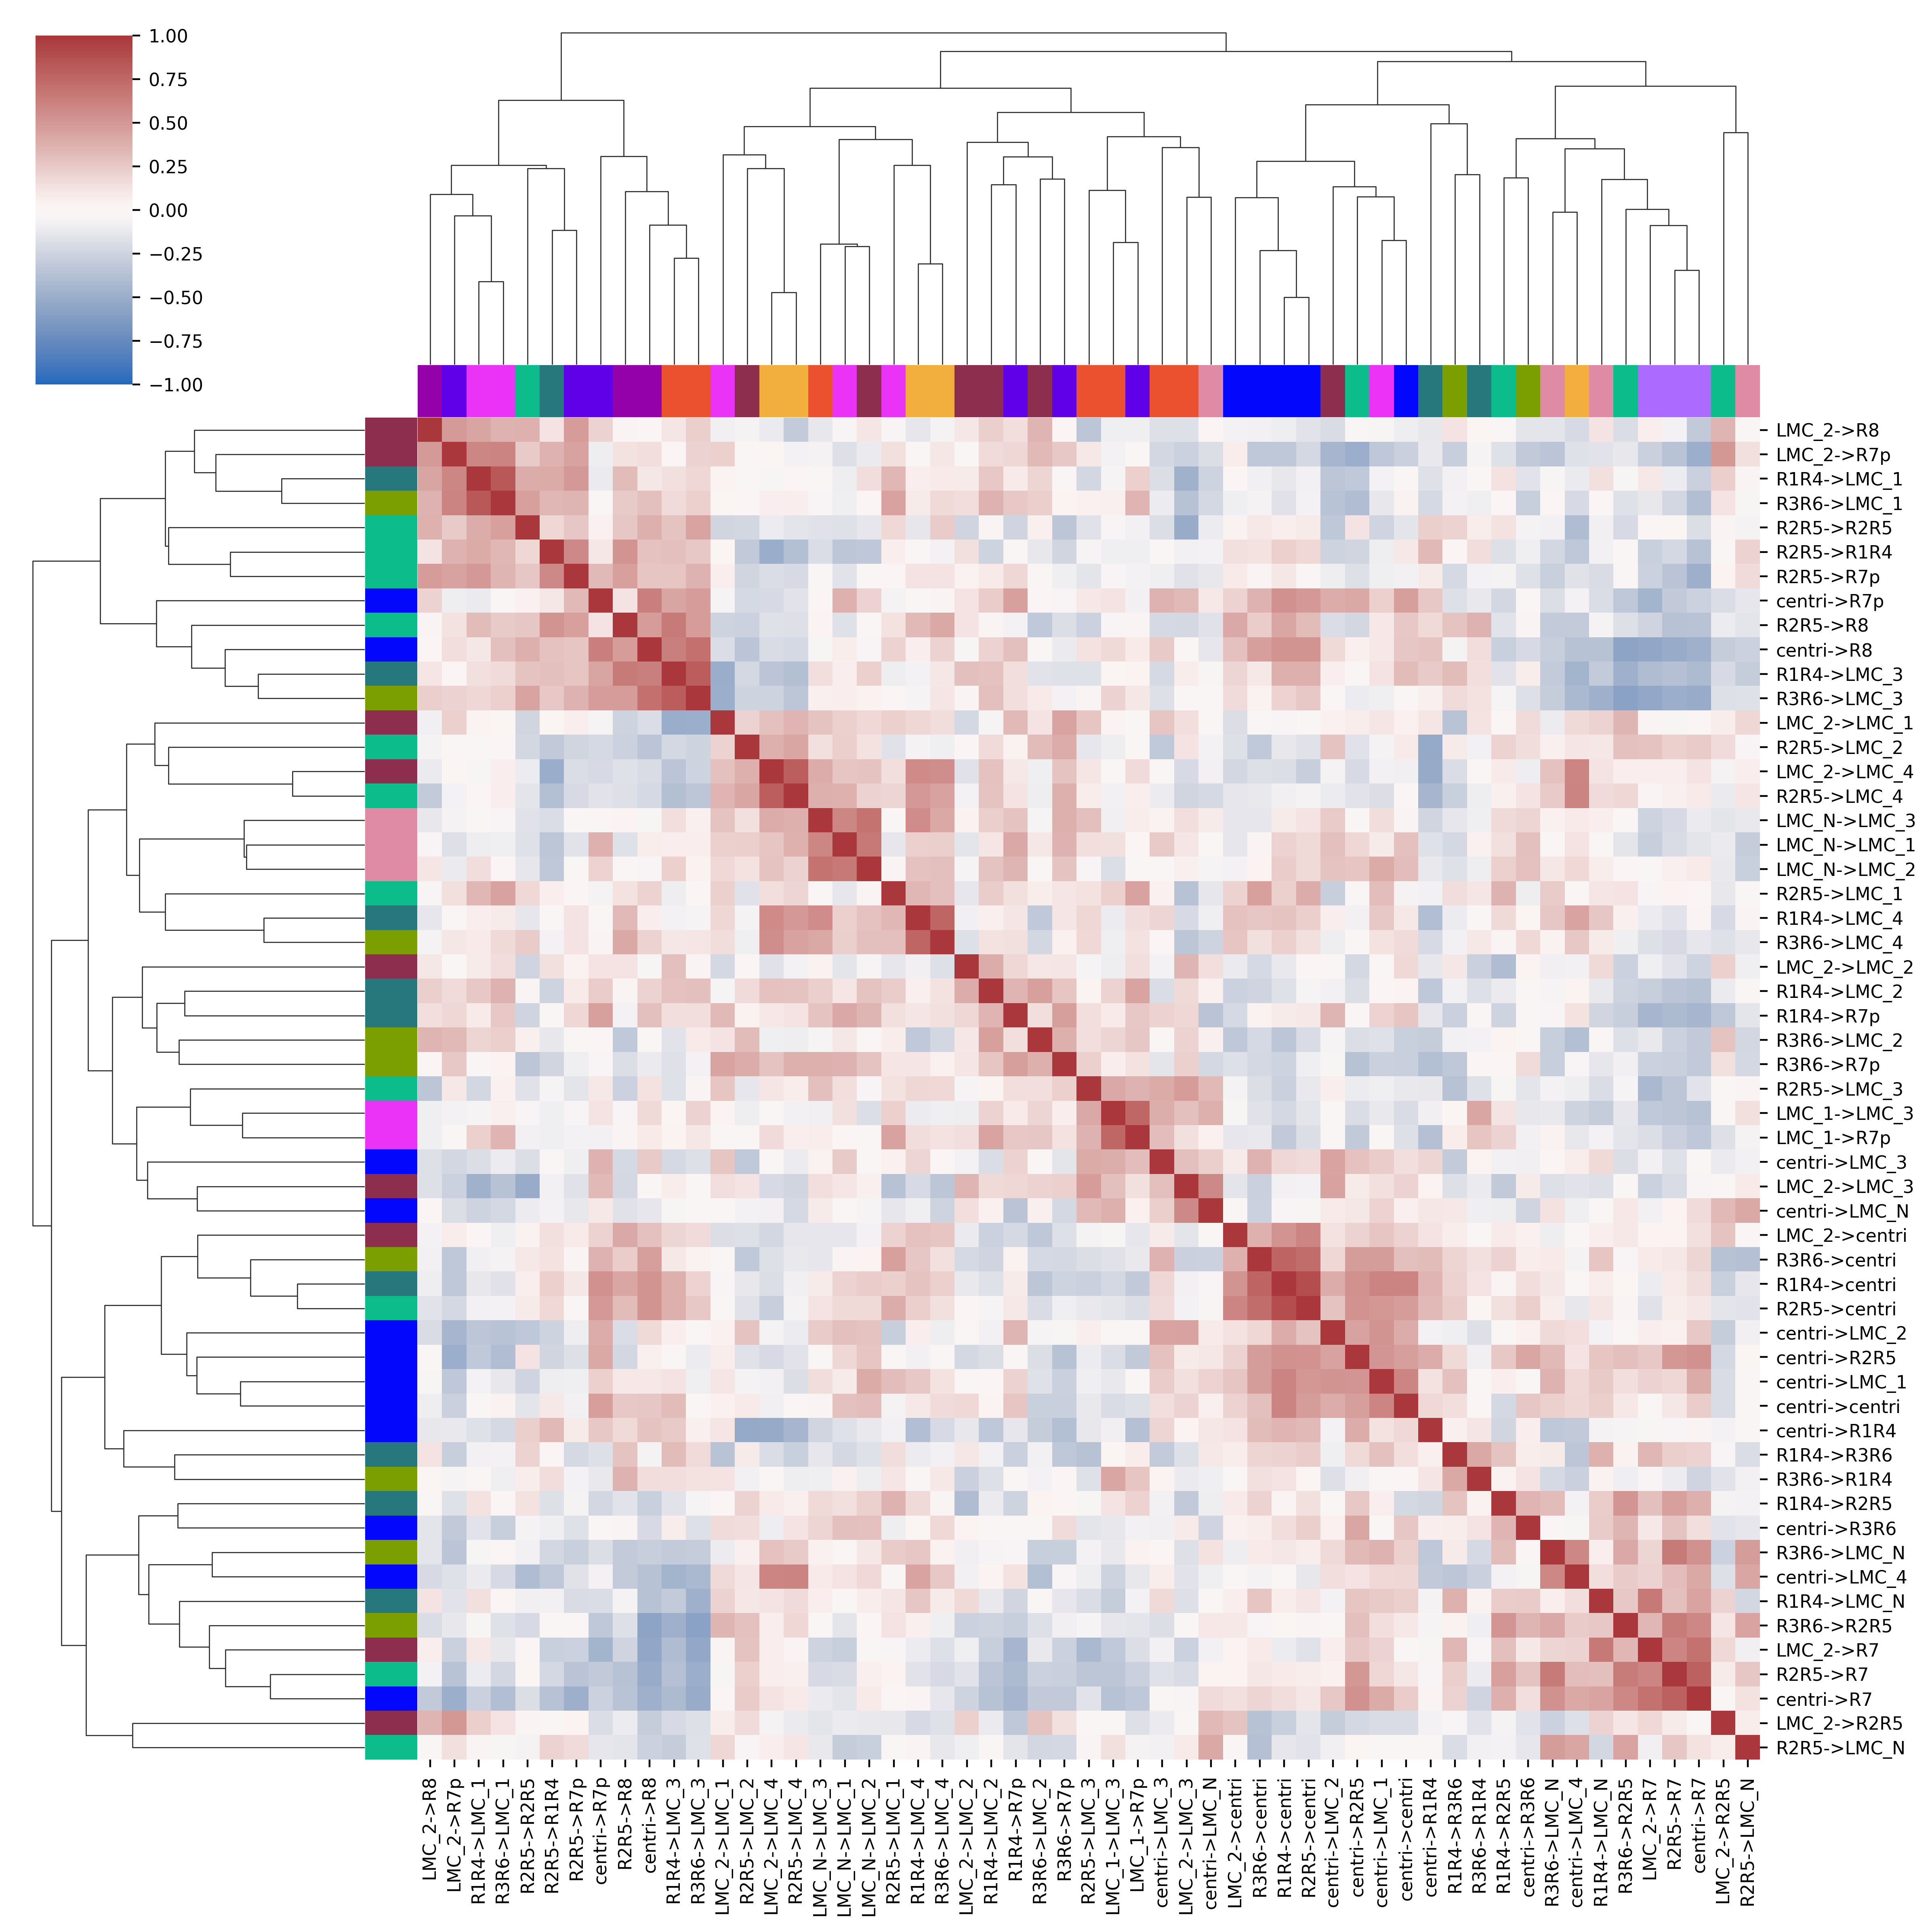

In [31]:
row_colors = [st_cm[x.split('->')[0]] for x in corr.index]
col_colors = [st_cm[y.split('->')[1]] for y in corr.columns]

clus = sns.clustermap(corr, yticklabels=corr.index, figsize=[12, 12], vmin=-1.0, vmax=1.0,
                      cmap='vlag', row_colors=row_colors, col_colors=col_colors, method='average', metric='euclidean')

In [32]:
# from itertools import product
# svfs = ['R1R4', 'R2R5', 'R3R6']
# lmcs = ['LMC_1', 'LMC_2', 'LMC_3', 'LMC_4']
# these_cx = [pre + '->' + post for pre, post in product(svfs, lmcs)]

# svf_corr = corr.loc[these_cx, vol_df.columns]

# row_colors = [st_cm[x.split('->')[0]] for x in svf_corr.index]
# col_colors = [st_cm[y.split('_')[0]] for y in svf_corr.columns]

# clus = sns.clustermap(svf_corr, yticklabels=svf_corr.index, figsize=[12, 12], vmin=-1.0, vmax=1.0,
#                       cmap='vlag', row_colors=row_colors, col_colors=col_colors, method='average', metric='euclidean')

## Correlations between connection counts and fraction of rhabdom volume

In [33]:
# Load/organize lamina connectome data
# Correlation matrix (cx types x PR types)
frac_combined = pd.concat([cxvecs, frac_vol], axis=1)
frac_corr = frac_combined.corr().dropna(axis=0).loc[cxvecs.columns, frac_vol.columns]

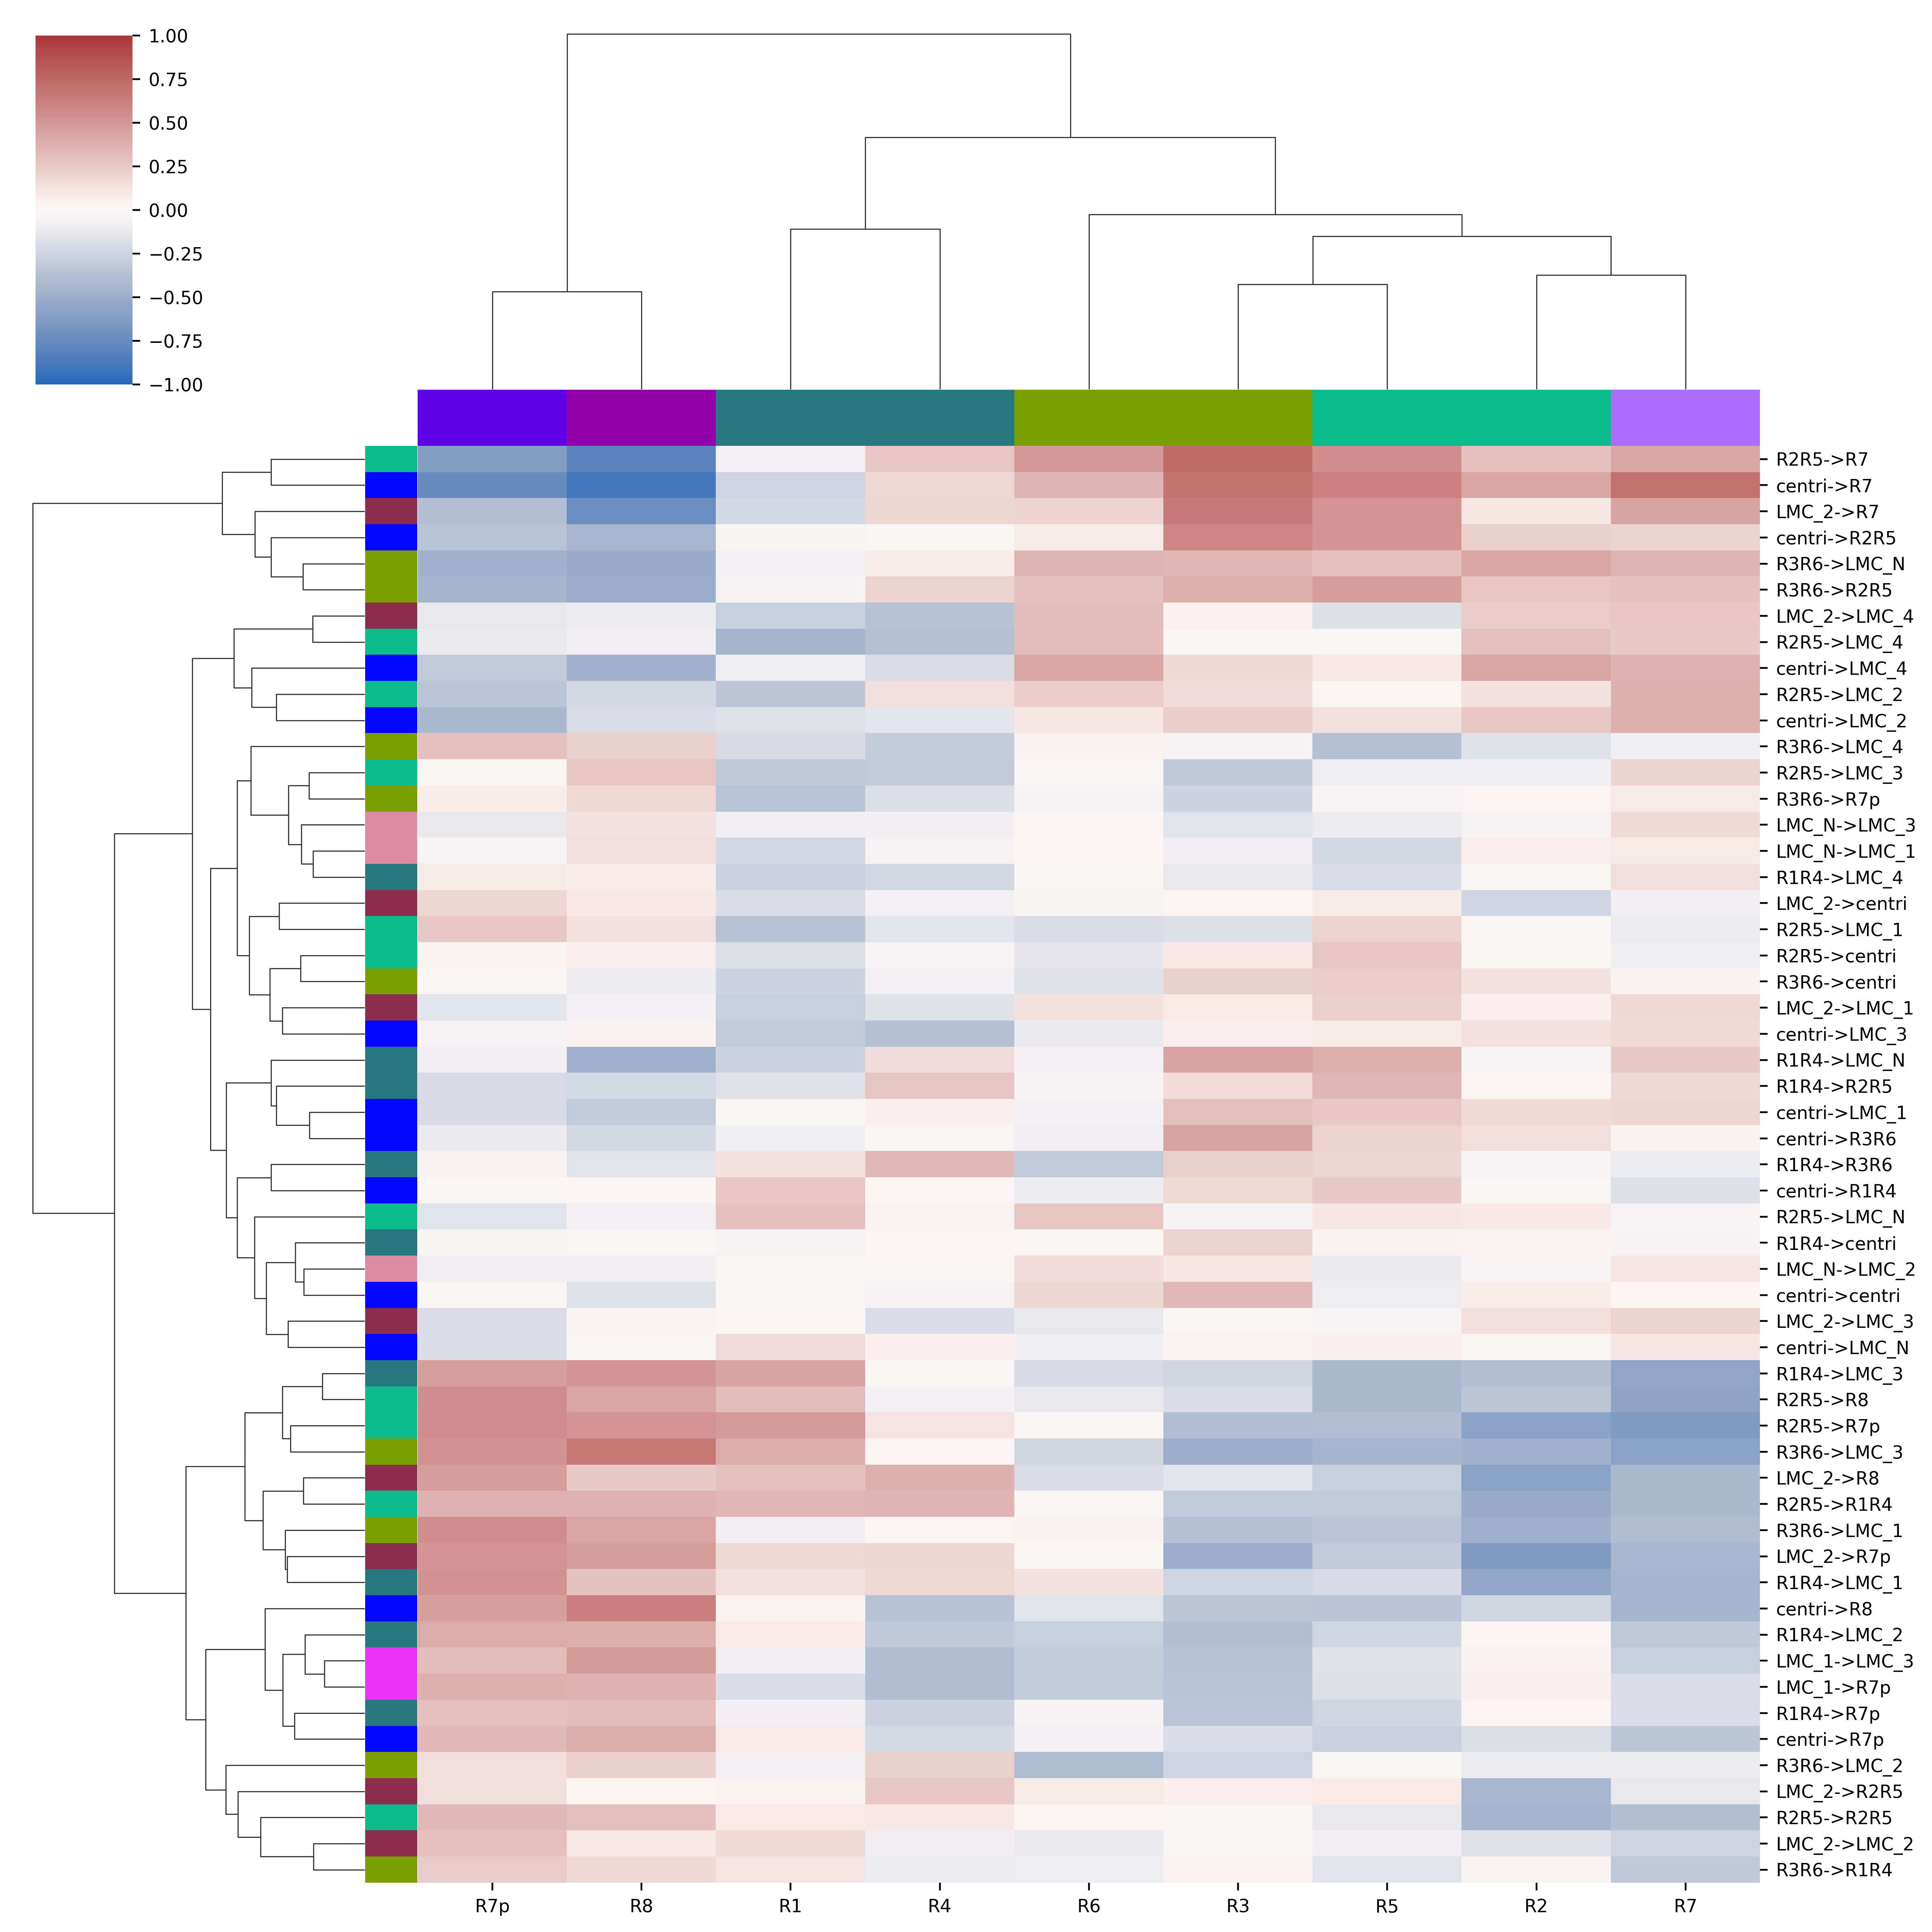

In [34]:
row_colors = [st_cm[x.split('->')[0]] for x in frac_corr.index]
col_colors = [st_cm[y.split('_')[0]] for y in frac_corr.columns]

clus = sns.clustermap(frac_corr, yticklabels=frac_corr.index, figsize=[12, 12], vmin=-1.0, vmax=1.0,
                      cmap='vlag', row_colors=row_colors, col_colors=col_colors, method='average', metric='euclidean')

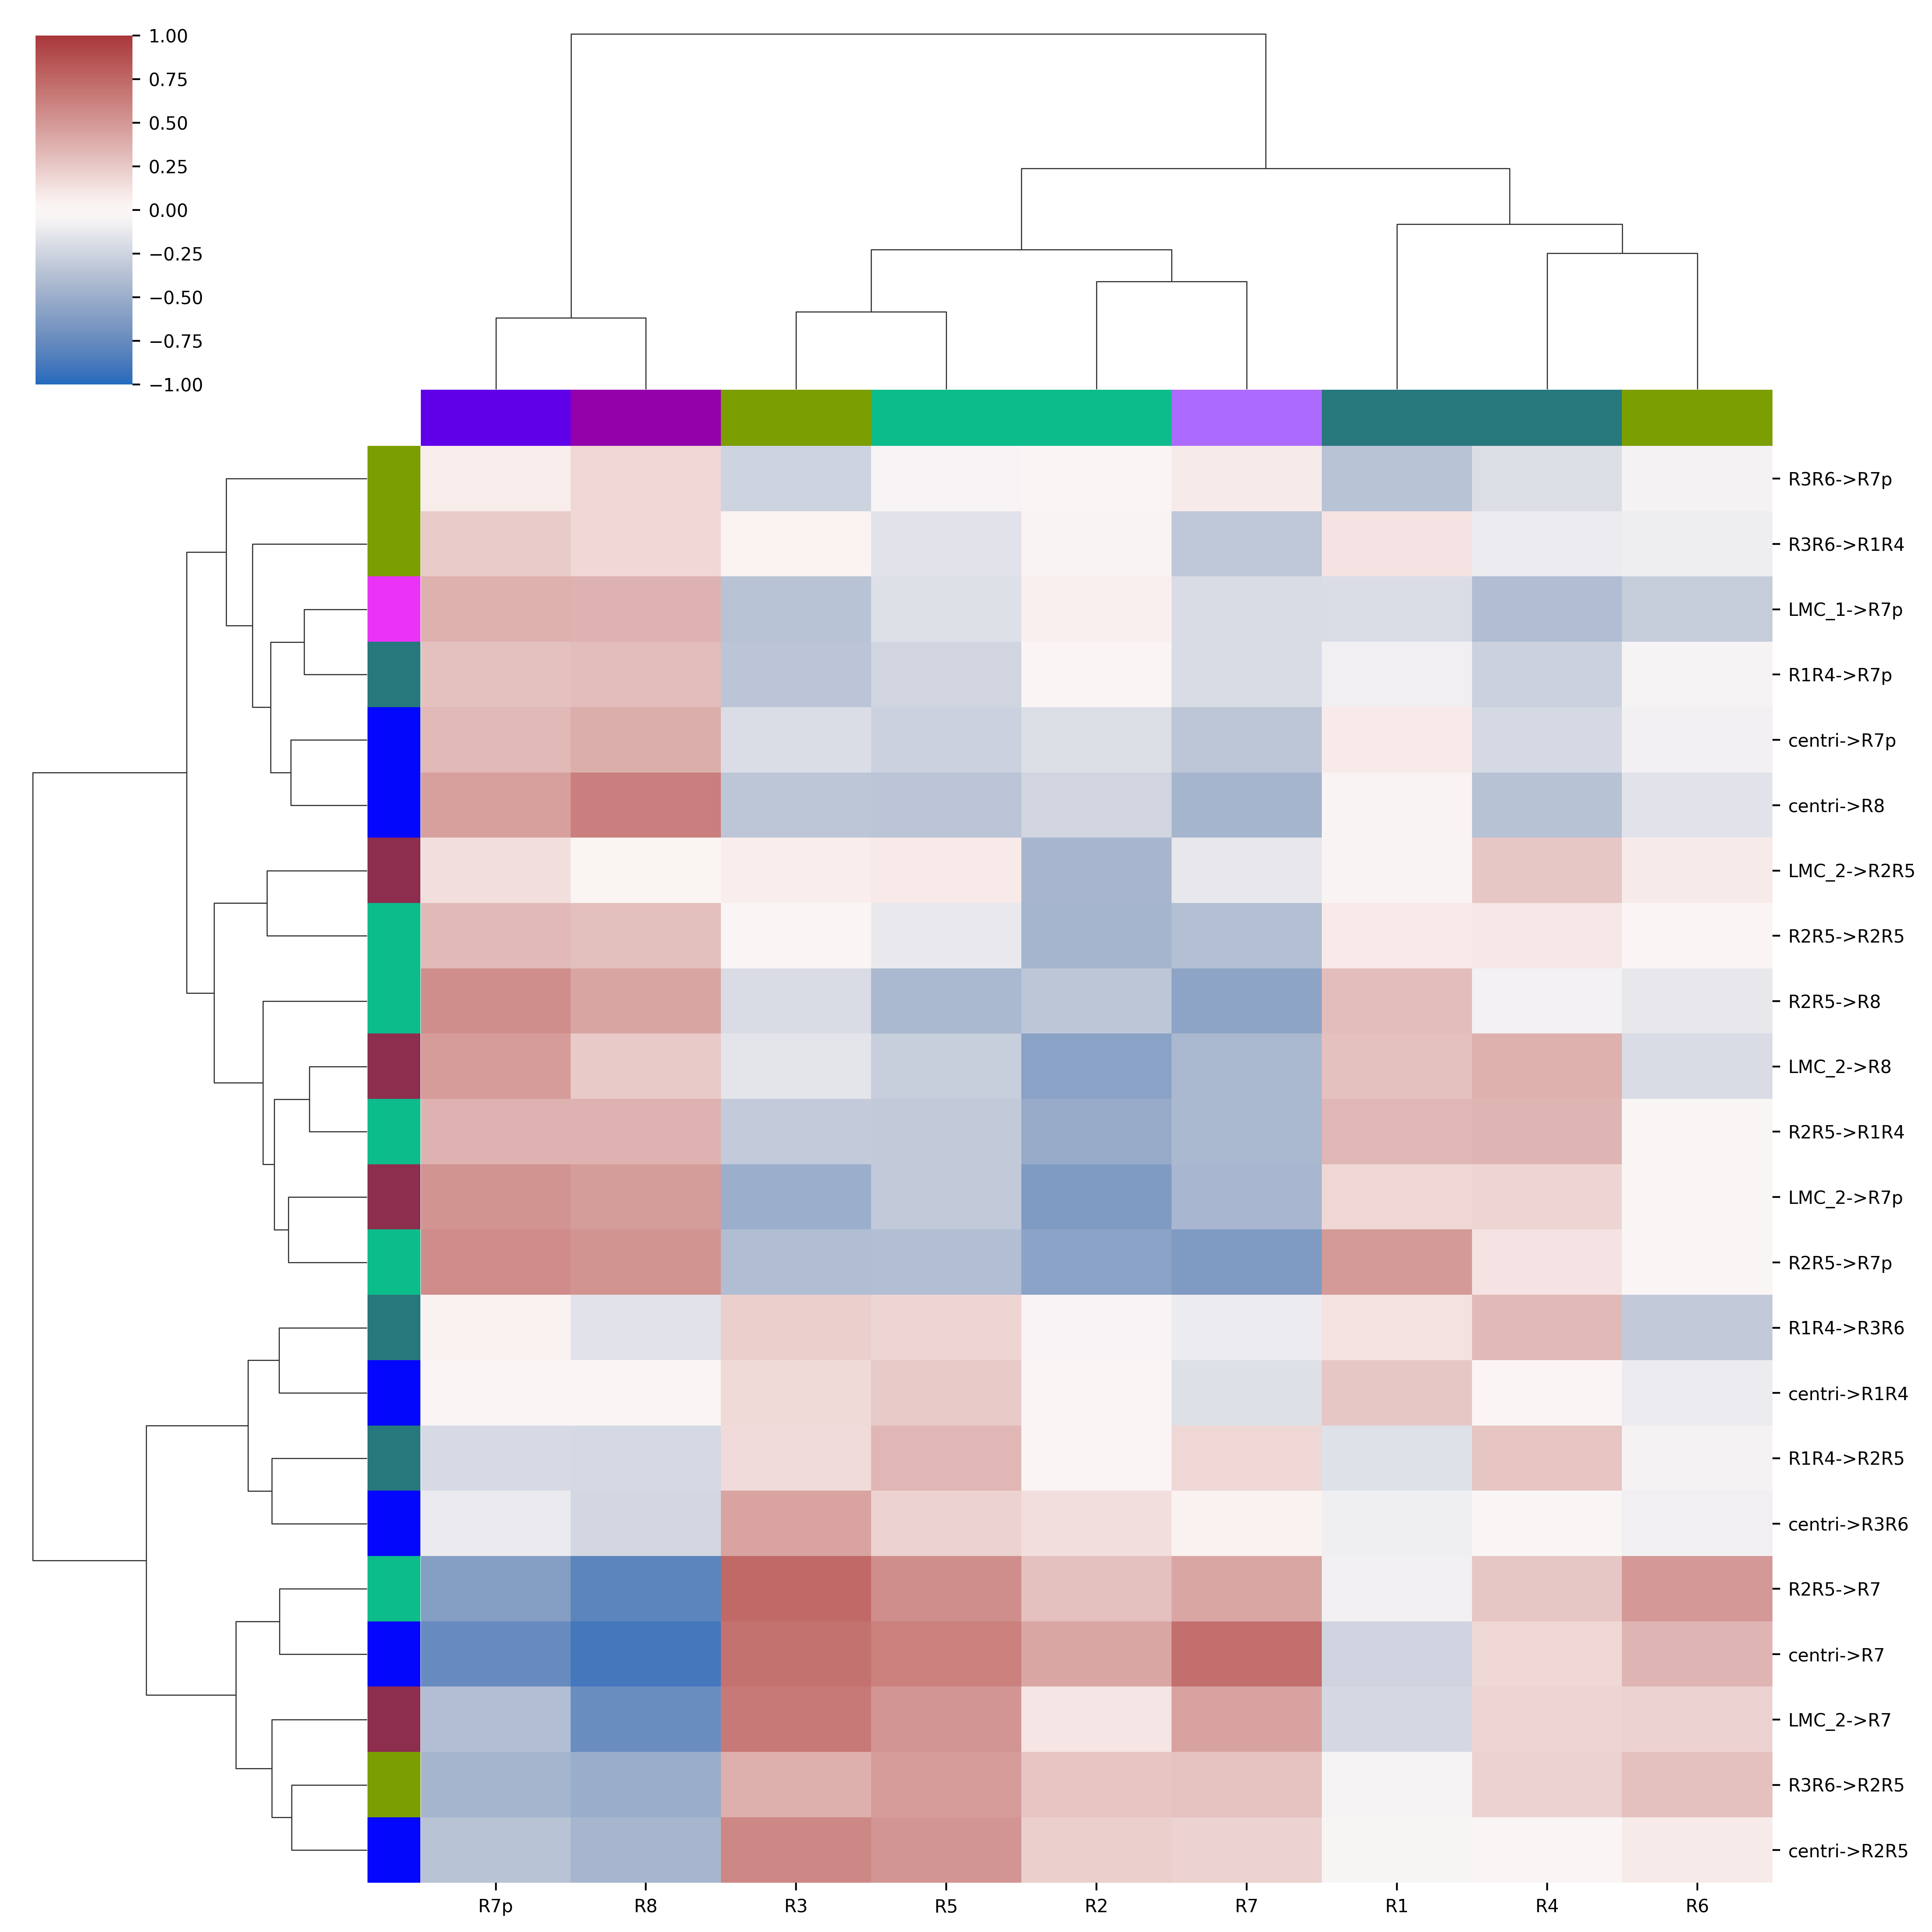

In [35]:
corr = frac_corr.filter(like='->R', axis=0)

row_colors = [st_cm[x.split('->')[0]] for x in corr.index]
col_colors = [st_cm[y.split('_')[0]] for y in corr.columns]

clus = sns.clustermap(corr, yticklabels=corr.index, figsize=[12, 12], vmin=-1.0, vmax=1.0,
                      cmap='vlag', row_colors=row_colors, col_colors=col_colors, method='average', metric='euclidean')

L2 outputs and fractional volumes

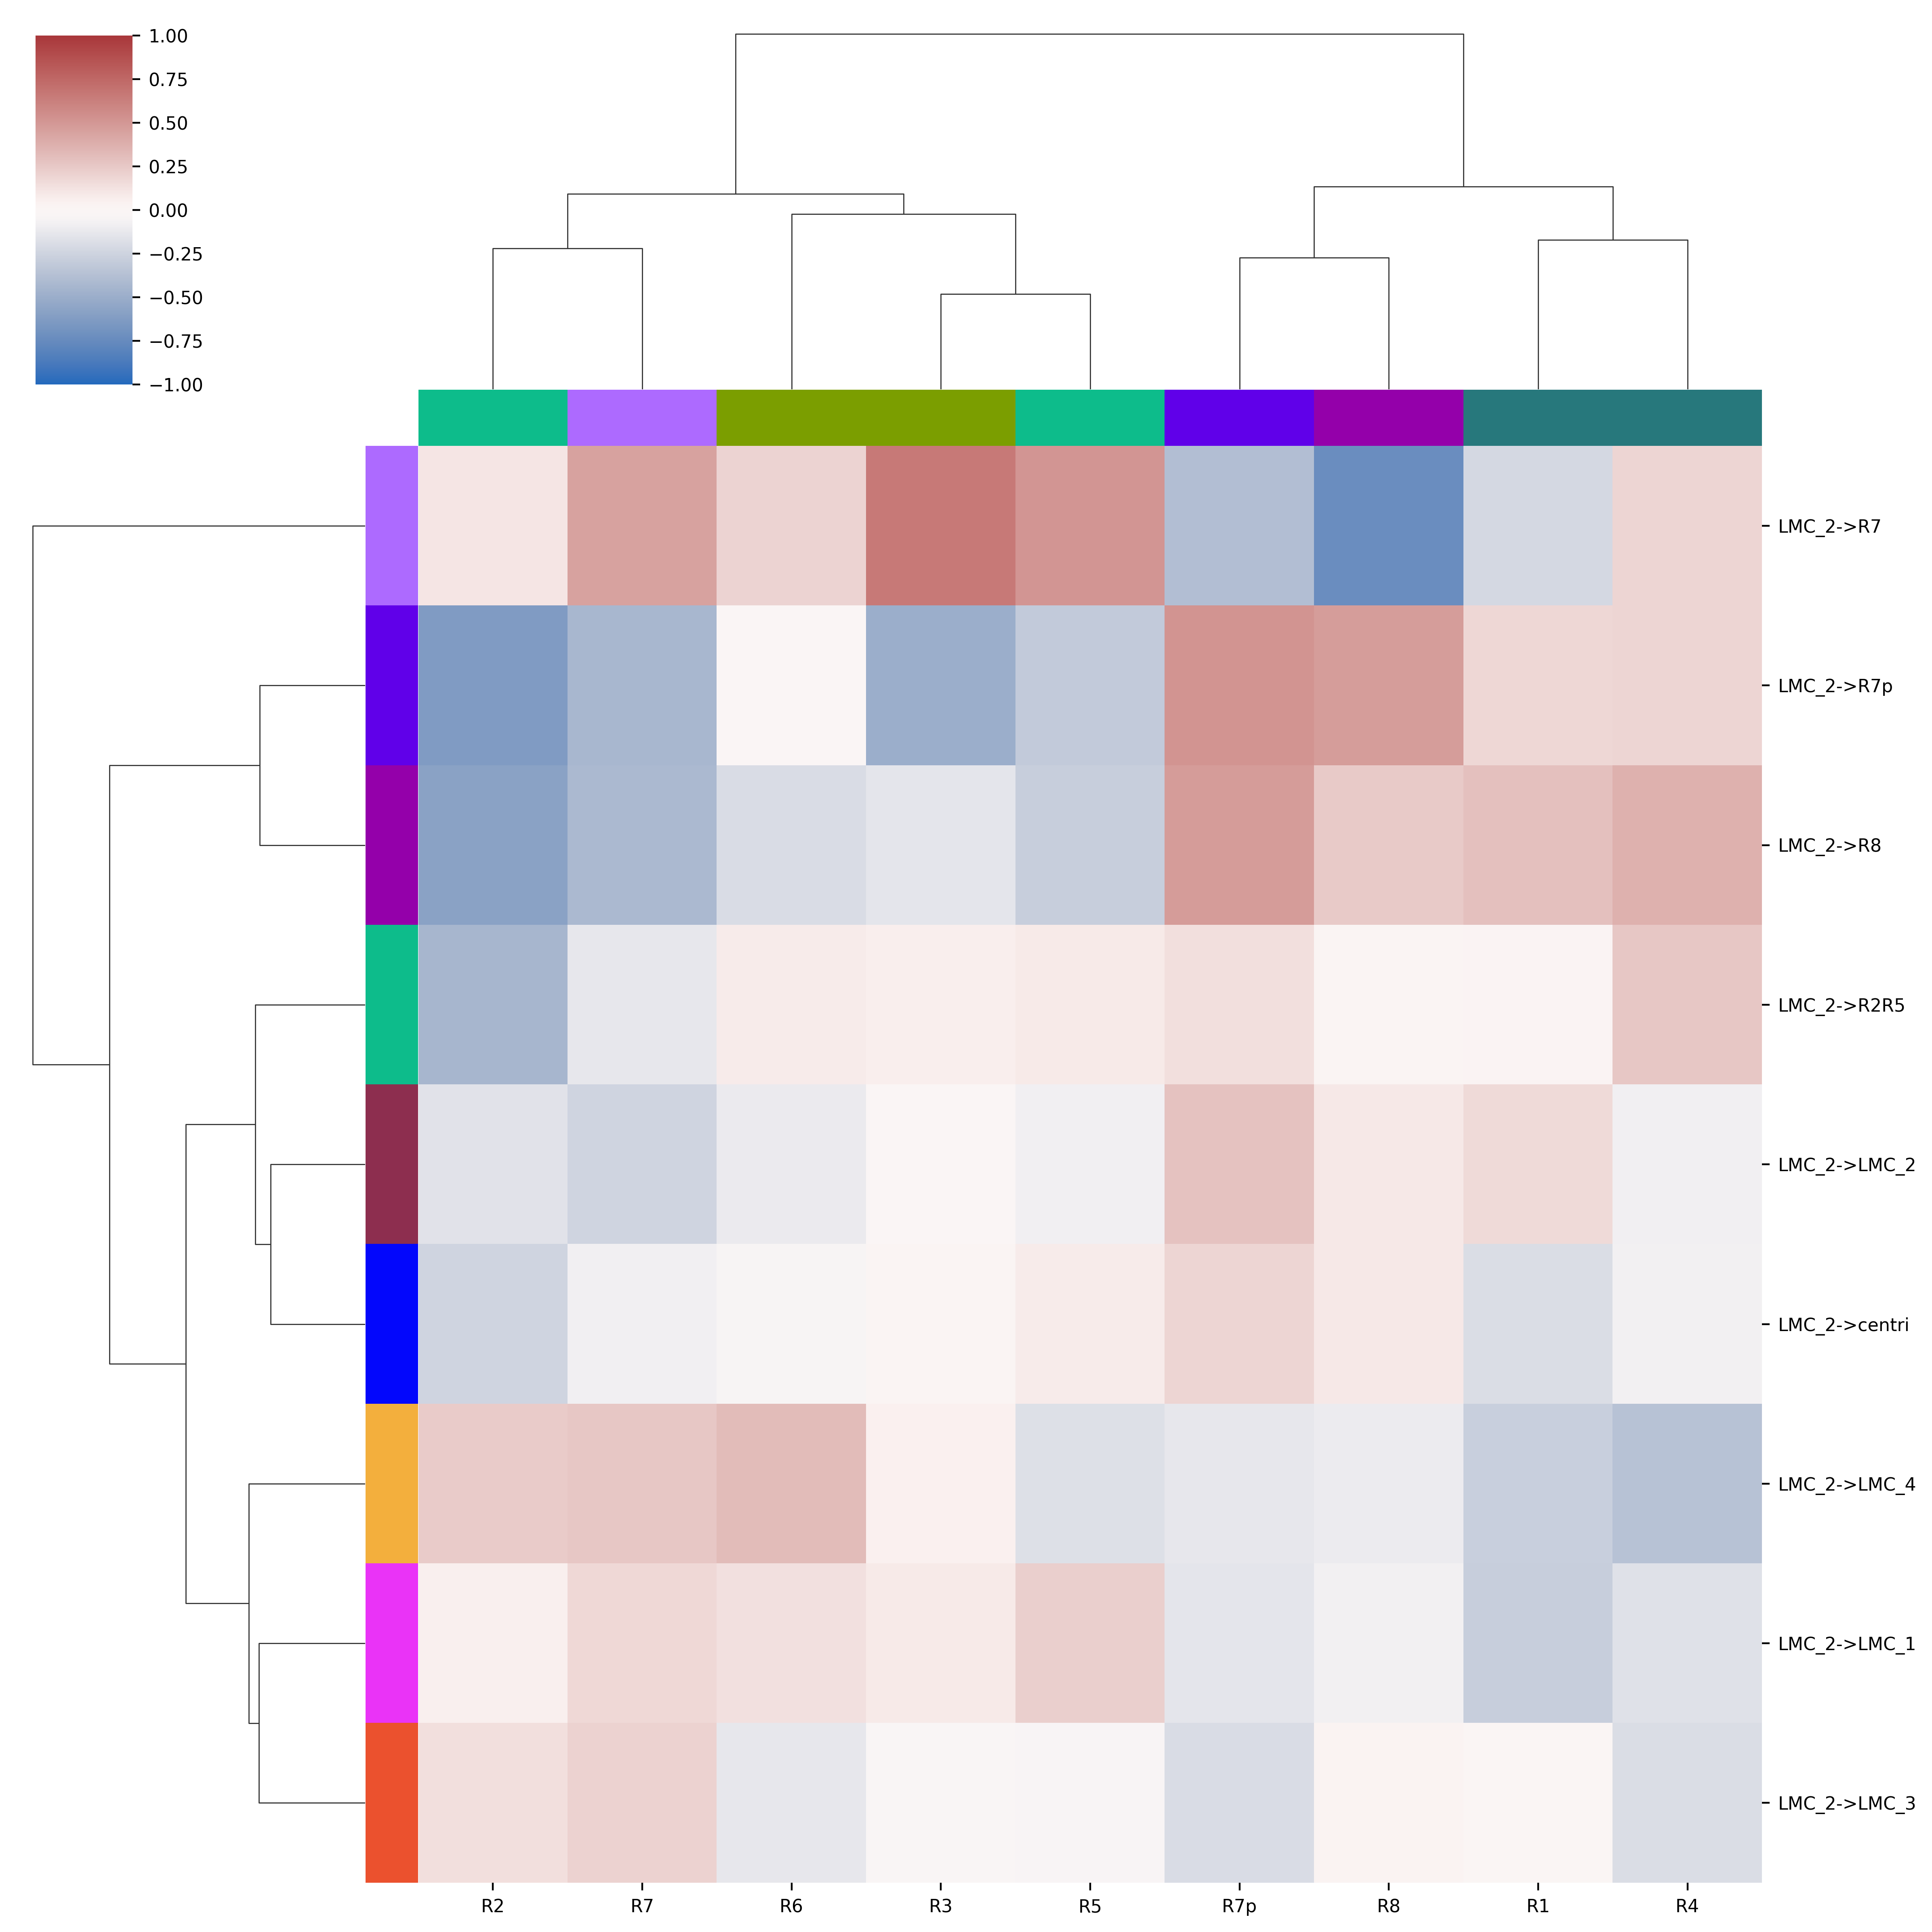

In [36]:
corr = frac_corr.loc[:, frac_vol.columns].filter(axis=0, like='LMC_2->')

row_colors = [st_cm[x.split('->')[1]] for x in corr.index]
col_colors = [st_cm[y.split('_')[0]] for y in corr.columns]

clus = sns.clustermap(corr, yticklabels=corr.index, figsize=[12, 12], vmin=-1.0, vmax=1.0,
                      cmap='vlag', row_colors=row_colors, col_colors=col_colors, method='average', metric='euclidean')

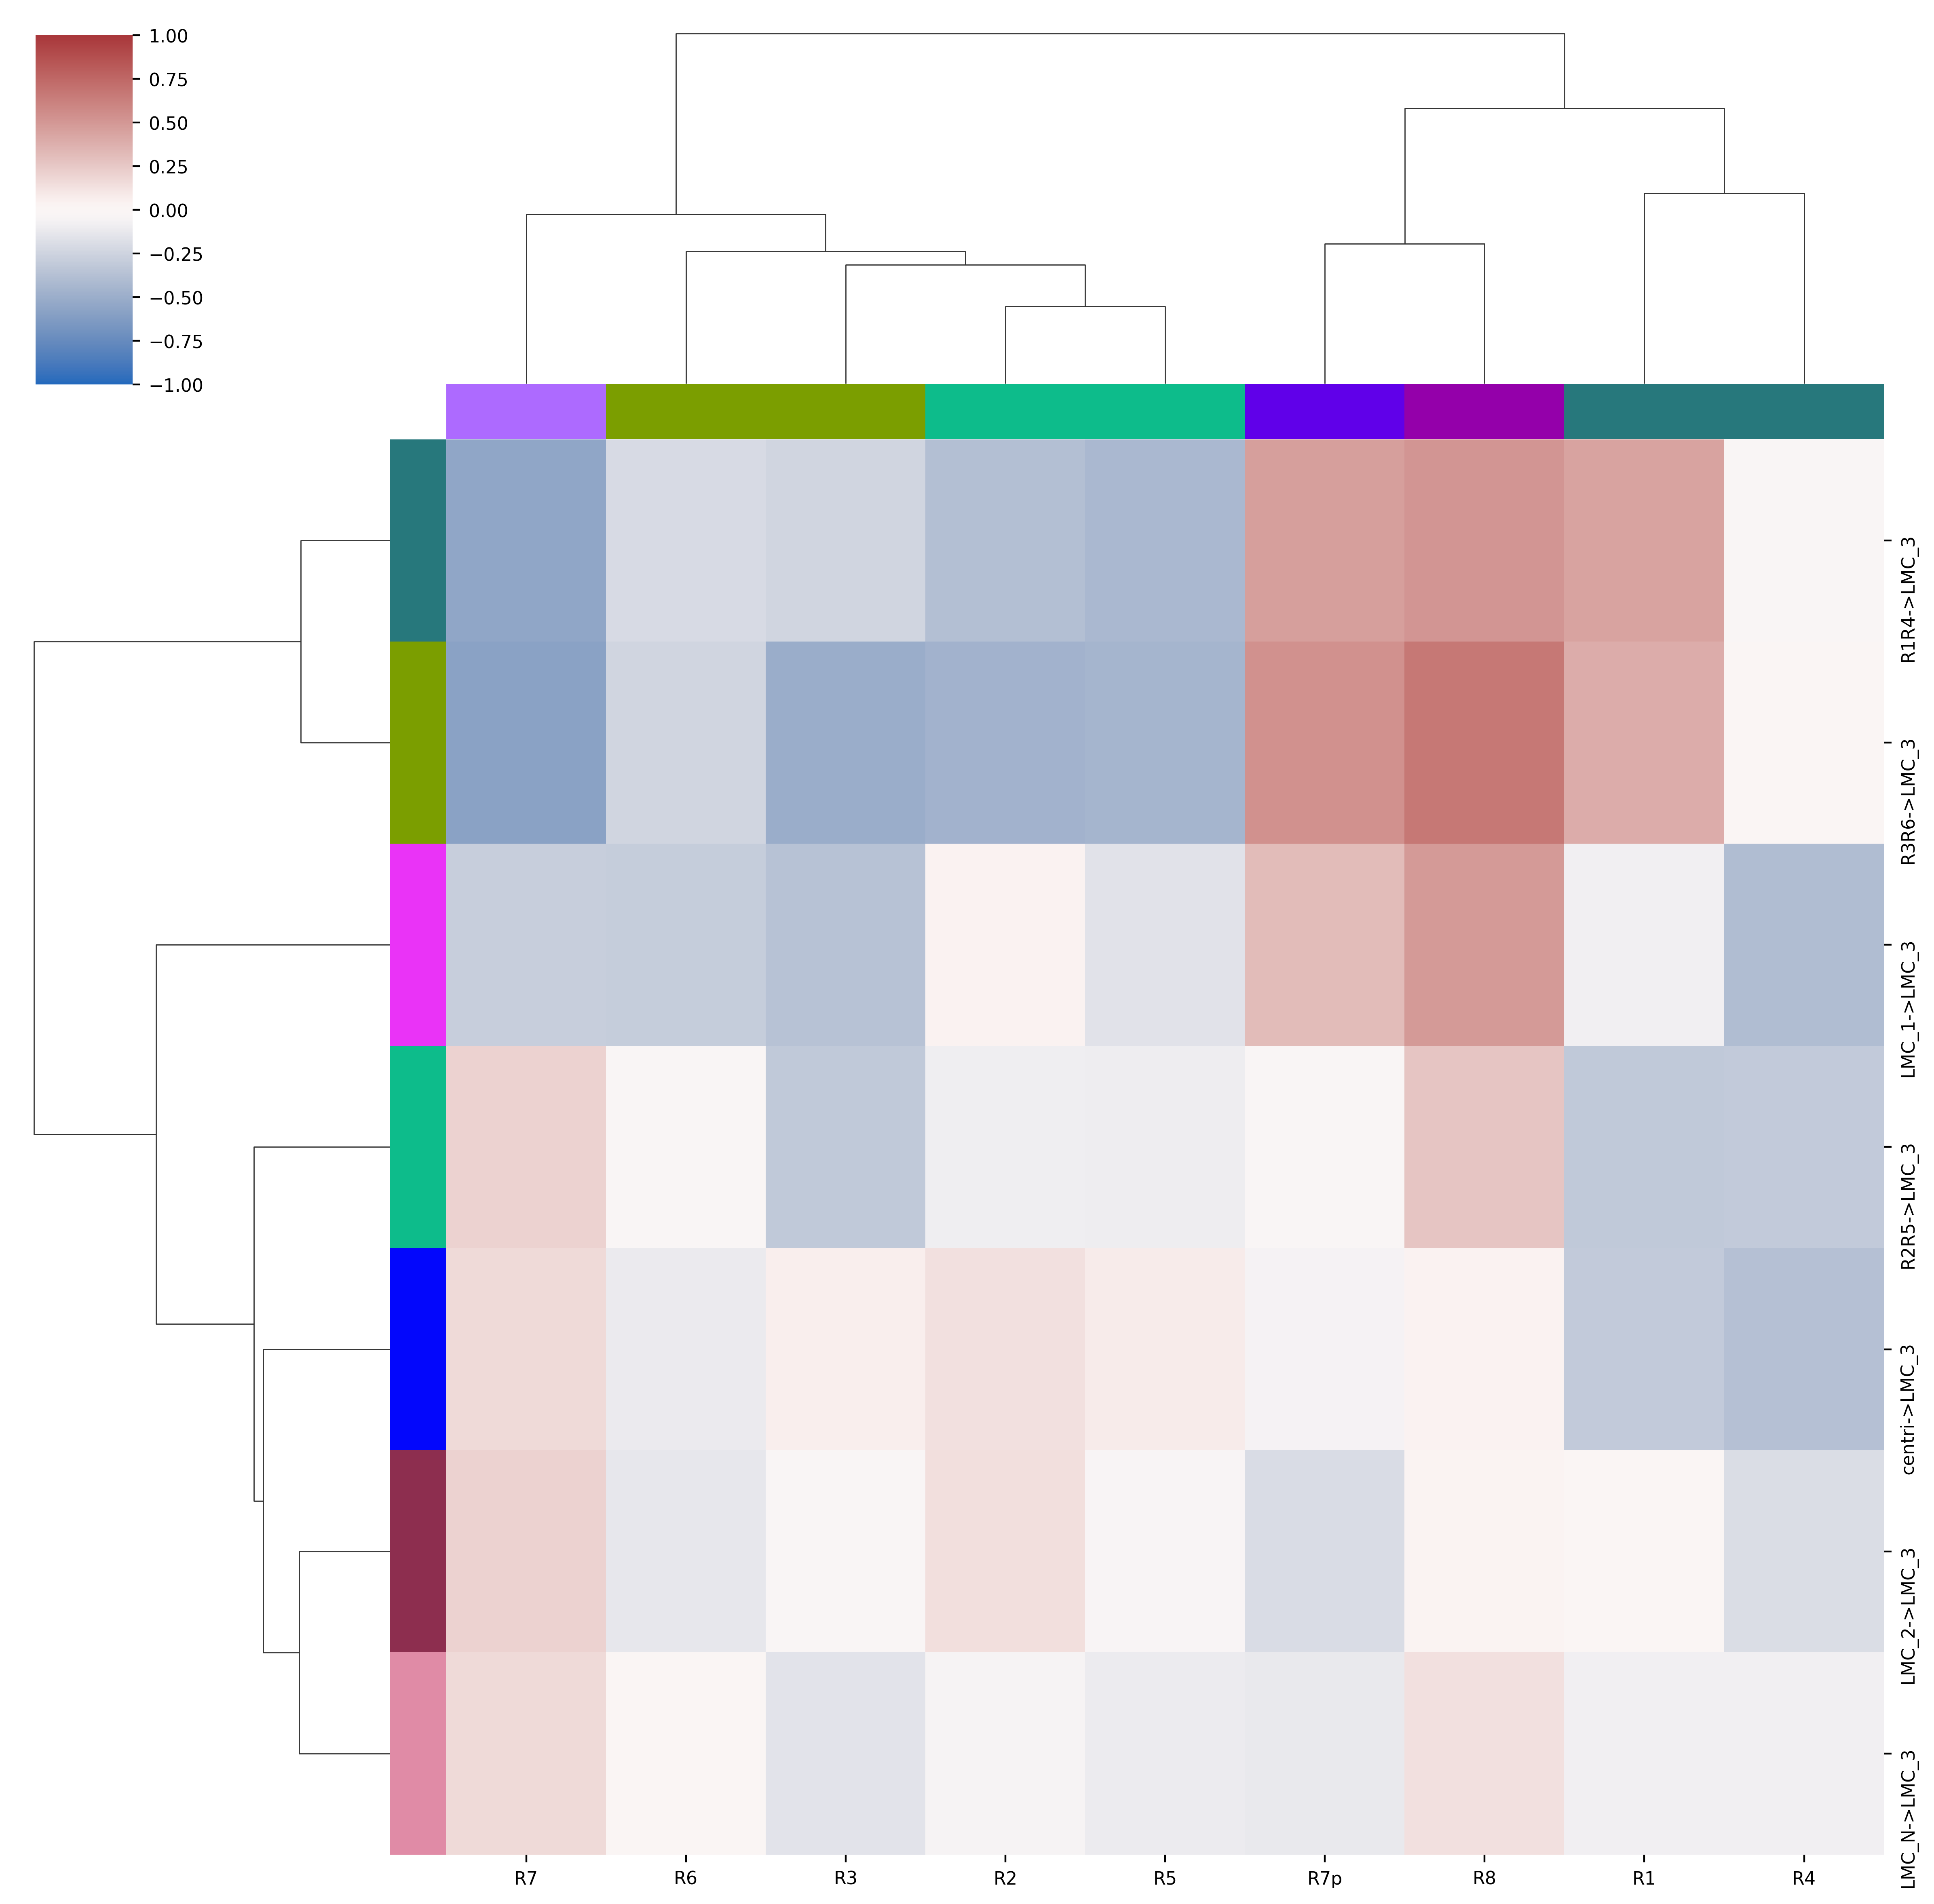

In [37]:
corr = frac_corr.loc[:, frac_vol.columns].filter(axis=0, like='LMC_3')

row_colors = [st_cm[x.split('->')[0]] for x in corr.index]
col_colors = [st_cm[y.split('_')[0]] for y in corr.columns]

clus = sns.clustermap(corr, yticklabels=corr.index, figsize=[12, 12], vmin=-1.0, vmax=1.0,
                      cmap='vlag', row_colors=row_colors, col_colors=col_colors, method='average', metric='euclidean')

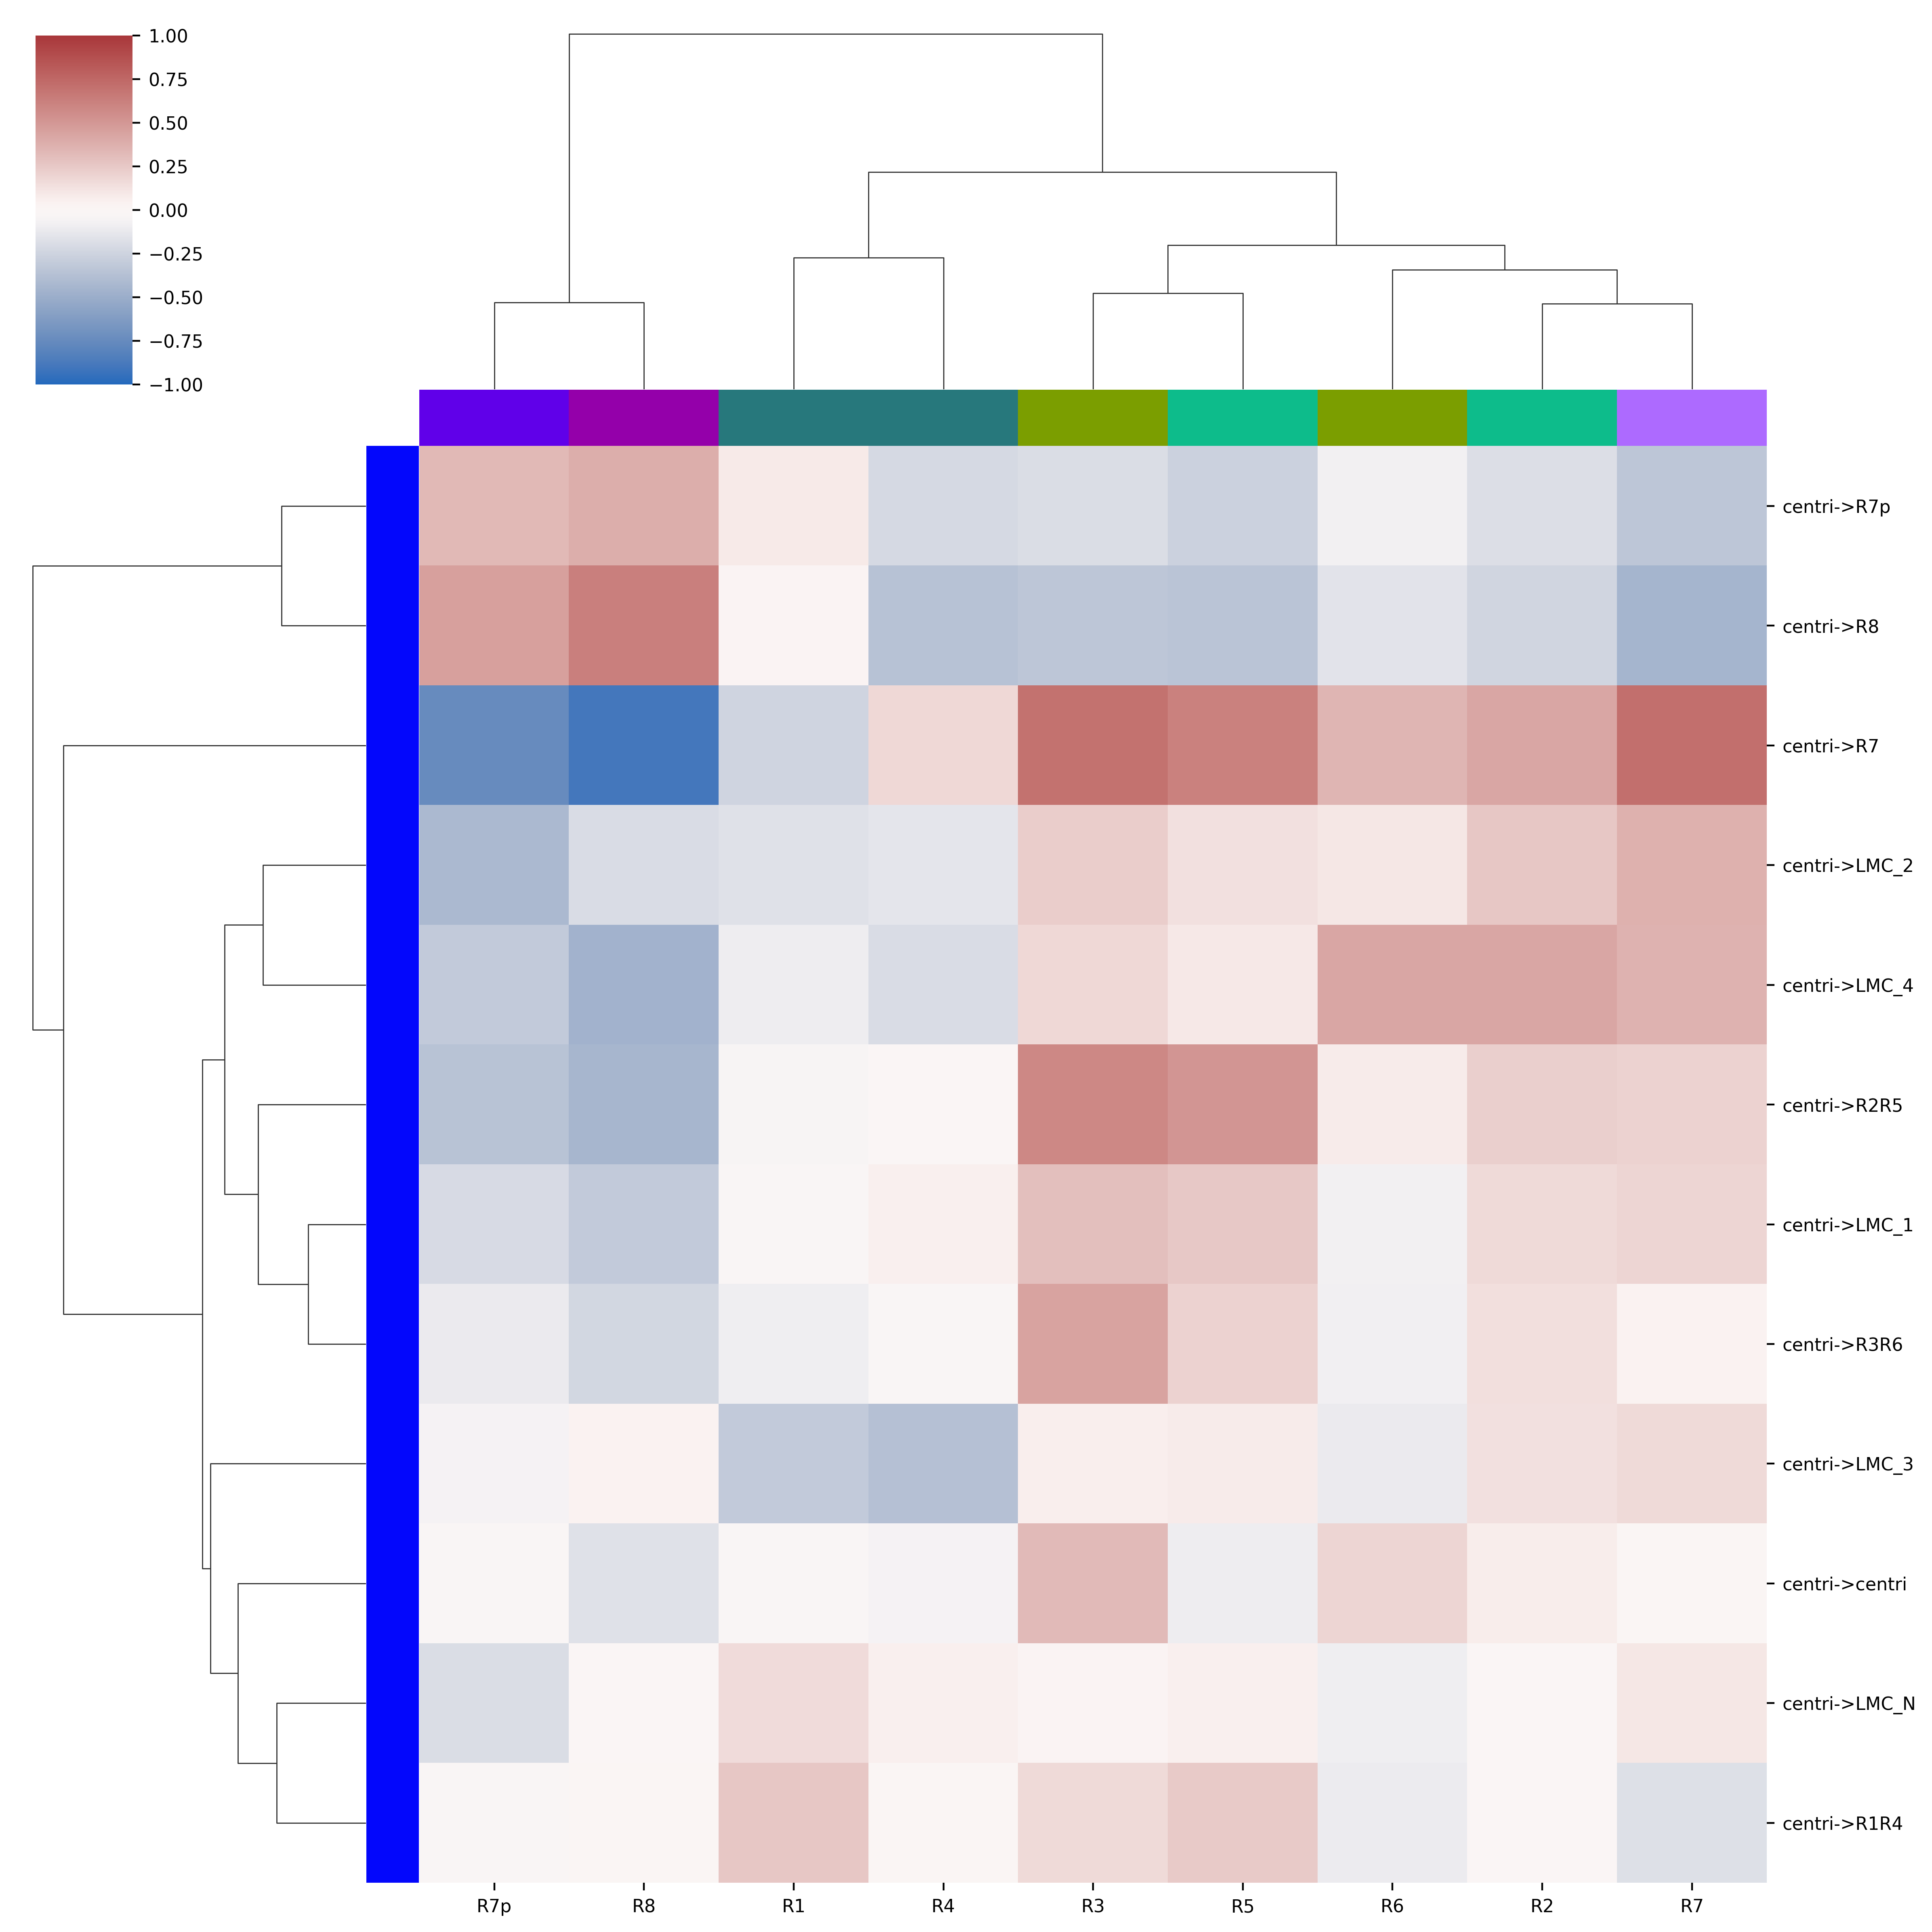

In [38]:
corr = frac_corr.loc[:, frac_vol.columns].filter(axis=0, like='centri->')

row_colors = [st_cm[x.split('->')[0]] for x in corr.index]
col_colors = [st_cm[y.split('_')[0]] for y in corr.columns]

clus = sns.clustermap(corr, yticklabels=corr.index, figsize=[12, 12], vmin=-1.0, vmax=1.0,
                      cmap='vlag', row_colors=row_colors, col_colors=col_colors, method='average', metric='euclidean')

In [39]:
# cx_cols = [cx for cx in cx_df.columns if '->LMC' in cx]
# vol_cols = list(vol_df.columns)
# cols = cx_cols + vol_cols

# data = frac_combined.loc[:, cols]
# corr = data.corr().dropna(axis=0).loc[cx_cols, vol_cols]

# row_colors = [st_cm[x.split('->')[0]] for x in corr.index]
# col_colors = [st_cm[y.split('_')[0]] for y in corr.columns]

# clus = sns.clustermap(corr, yticklabels=corr.index, figsize=[12, 12], vmin=-1.0, vmax=1.0,
#                       cmap='vlag', row_colors=row_colors, col_colors=col_colors, method='average', metric='euclidean')

## Hypothesis: Number of lamina inputs to long photoreceptors is correlated with their rhabdomere volume

In [40]:
combined.filter(items=['R7', 'R7p', 'R8'])

R7        R7p         R8
om                                
A0  8.727351  10.366335   6.358027
A1  4.226182  15.234699   7.634705
A2  7.185002  13.117198   5.454782
A3  8.222687   8.222411   5.430847
A4  5.860794   5.709287   1.063402
A5  2.927452   3.471102   0.650500
B0  4.478997  16.772216   8.823803
B1  3.220619  21.674195  10.050852
B2  4.478565  16.287313   8.157599
B3  6.744872  11.534464   7.138981
B4  9.391489   9.779426   5.243616
B5  4.000935   3.757599   0.761724
B6  3.421844   3.377645   0.699531
C1  2.852086  15.097979   7.133266
C2  3.302063  18.062004   9.605701
C3  4.109619  14.035053   7.067187
C4  8.742906   7.902018   5.716618
C5  5.907420   4.695171   1.476635
C6  4.001146   3.679855   0.769417
D2  3.770037  12.349030   6.793112
D3  3.445252  14.157979   7.001647
D4  5.568188  12.745985   4.728322
D5  6.885523   7.566630   5.052552
D6  4.107839   3.161156   0.813161
D7  3.771101   4.201112   0.730667
E4  3.854185   9.164296   5.207337
E5  4.741772   7.911690   4.661491
E6  5.354946   4.115075   0.924302
E7  3.101124   3.019713   0.718379

In [41]:
lpr_fvol_inputs = pd.DataFrame({'inputs->R7': frac_combined.filter(regex='->R7$').sum(axis=1), 
                                'inputs->R7p': frac_combined.filter(regex='->R7p$').sum(axis=1), 
                                'inputs->R8': frac_combined.filter(regex='->R8$').sum(axis=1)})
lpr_fvol_inputs = pd.concat([lpr_fvol_inputs, frac_combined.filter(items=['R7', 'R7p', 'R8'])], axis=1)

lpr_vol_inputs = pd.DataFrame({'inputs->R7': combined.filter(regex='->R7$').sum(axis=1), 
                                'inputs->R7p': combined.filter(regex='->R7p$').sum(axis=1), 
                                'inputs->R8': combined.filter(regex='->R8$').sum(axis=1)})
lpr_vol_inputs = pd.concat([lpr_vol_inputs, combined.filter(items=['R7', 'R7p', 'R8'])], axis=1)





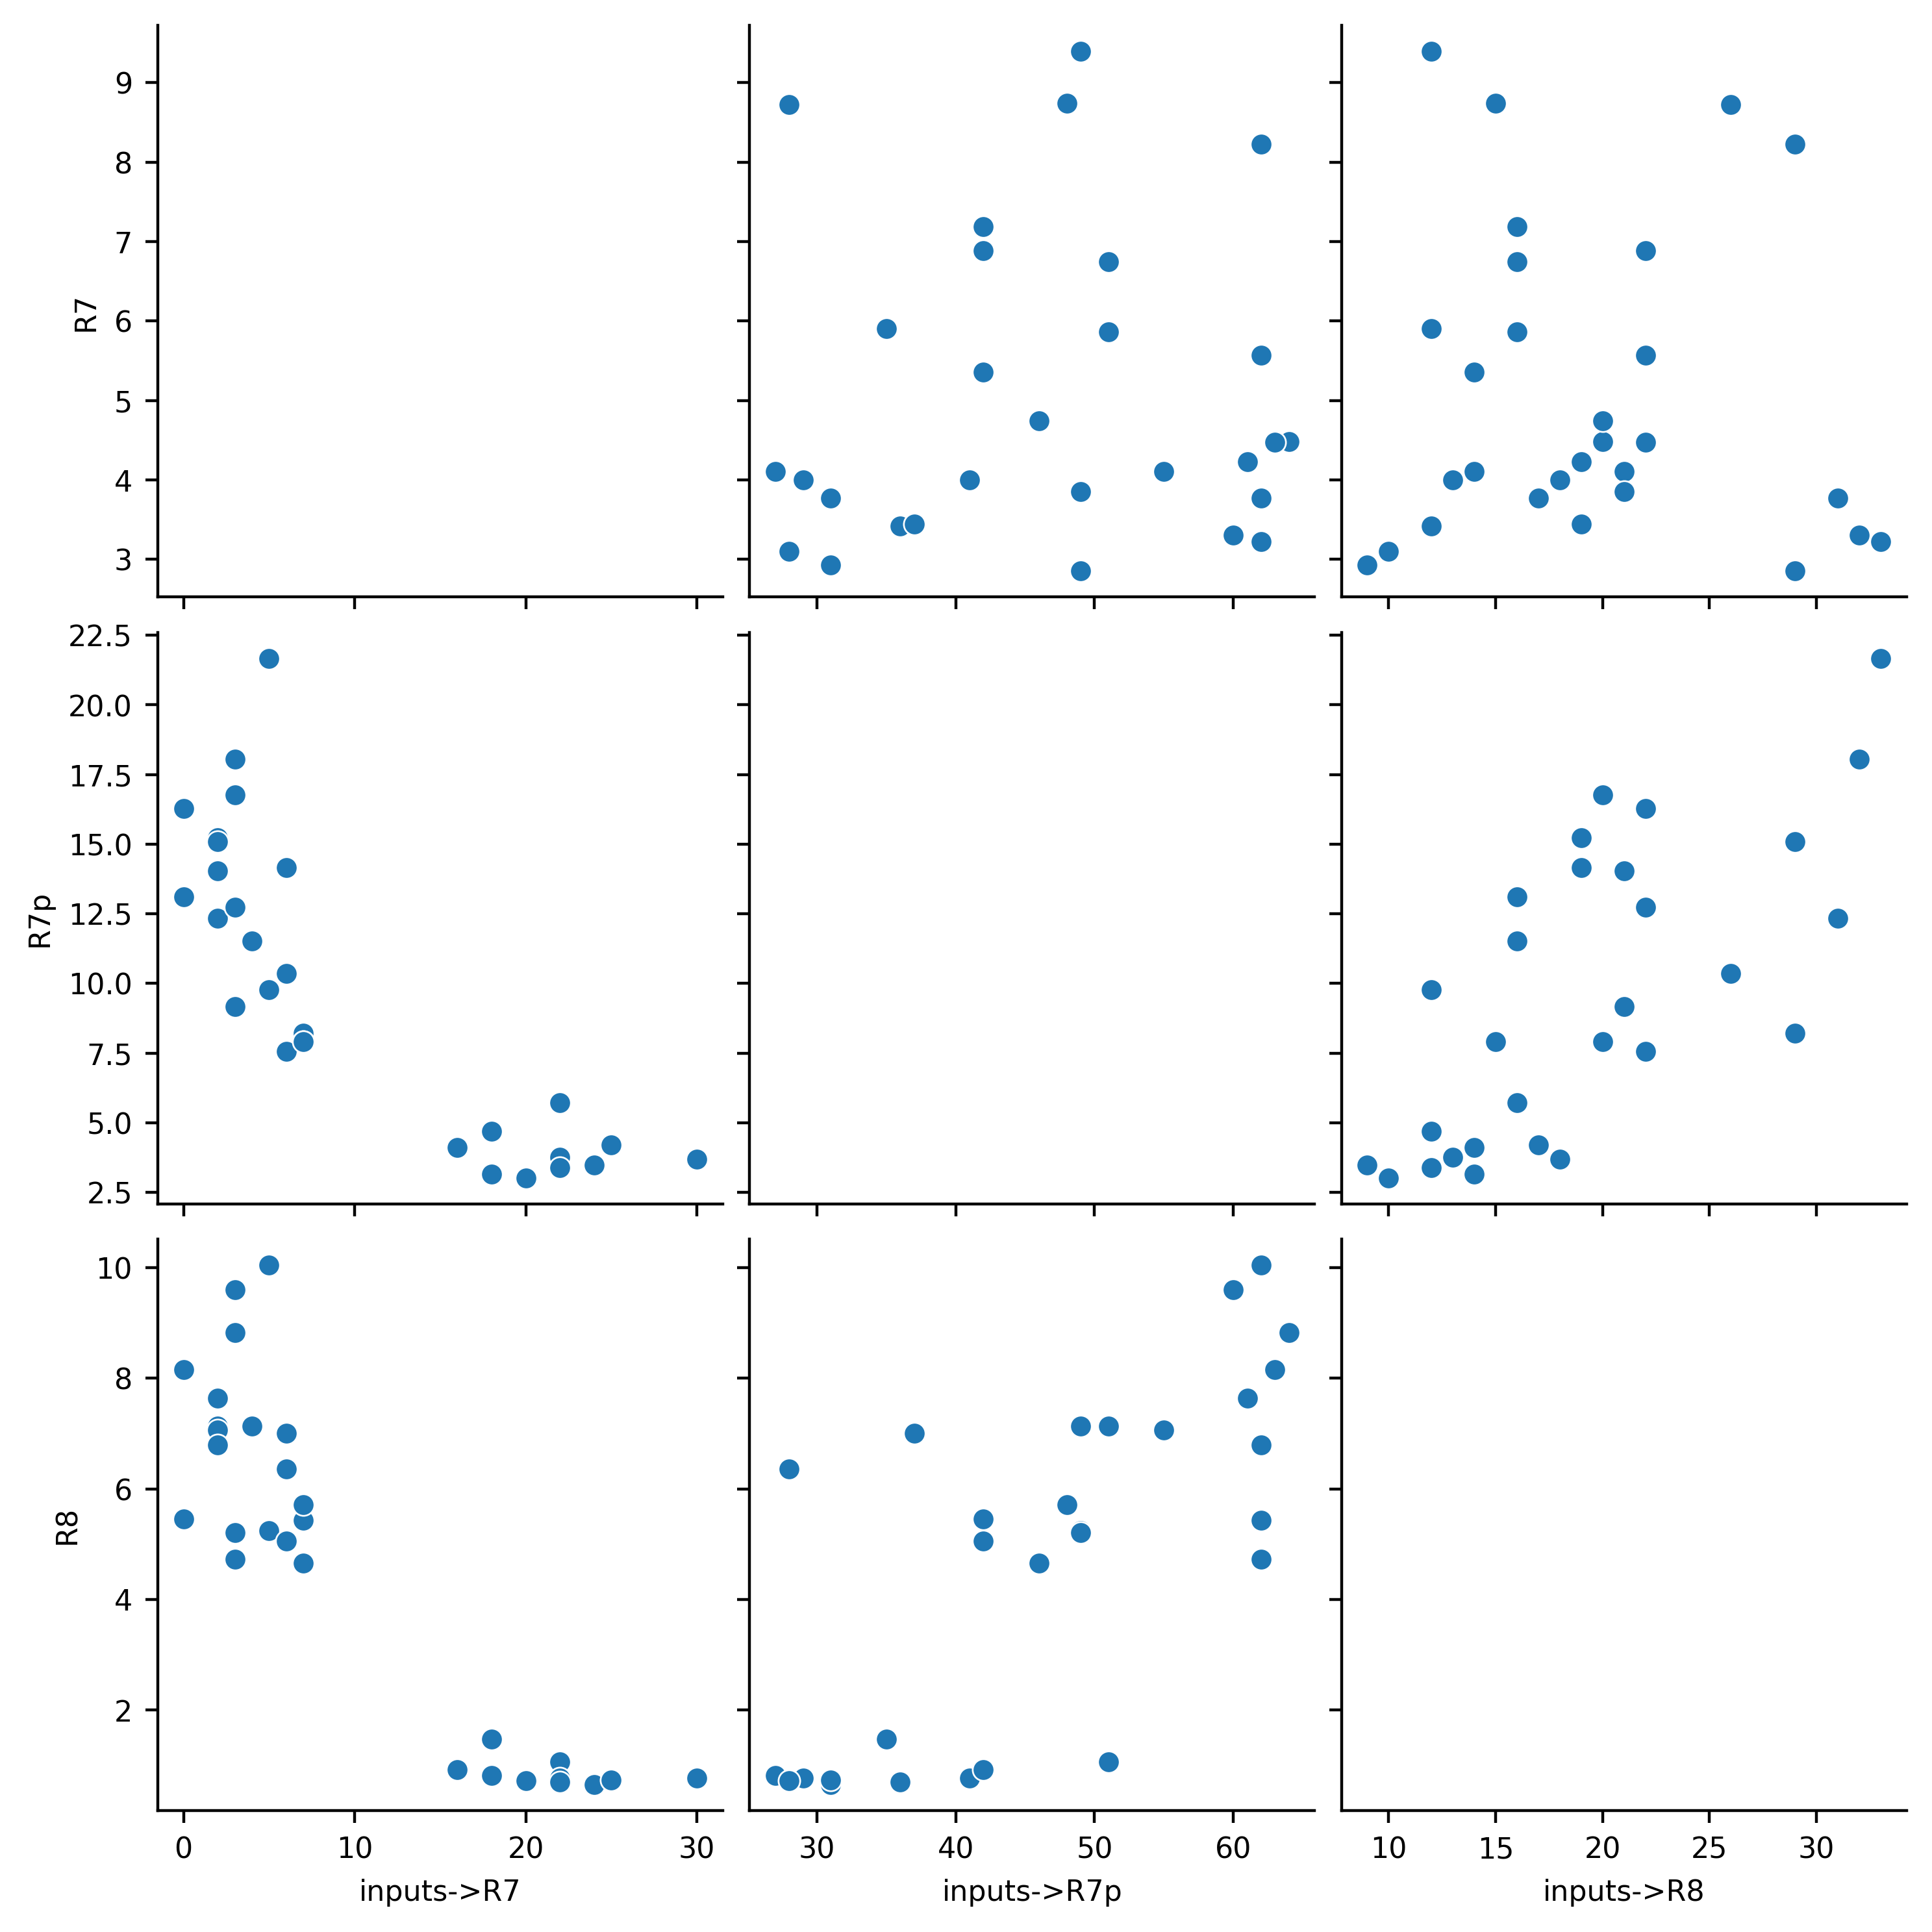

In [42]:
sns.pairplot(data = lpr_vol_inputs, x_vars=['inputs->R7', 'inputs->R7p', 'inputs->R8'], y_vars=['R7', 'R7p', 'R8'])

In [43]:
# lpr_inputs = pd.DataFrame({'inputs->R7': combined.filter(regex='->R7$').sum(axis=1), 
#                            'inputs->R7p': combined.filter(regex='->R7p$').sum(axis=1), 
#                            'inputs->R8': combined.filter(regex='->R8$').sum(axis=1)})
# lpr_inputs = pd.concat([lpr_inputs, combined.filter(items=['R7_vol', 'R7p_vol', 'R8_vol'])], axis=1)

In [44]:
lpr_fvol_inputs

inputs->R7  inputs->R7p  inputs->R8        R7       R7p        R8
om                                                                   
A0         6.0         28.0        26.0  0.176155  0.209237  0.128332
A1         2.0         61.0        19.0  0.073414  0.264646  0.132625
A2         0.0         42.0        16.0  0.128889  0.235304  0.097851
A3         7.0         62.0        29.0  0.183039  0.183033  0.120892
A4        22.0         51.0        16.0  0.179159  0.174527  0.032507
A5        24.0         31.0         9.0  0.140869  0.167030  0.031302
B0         3.0         64.0        20.0  0.076101  0.284969  0.149921
B1         5.0         62.0        33.0  0.047472  0.319478  0.148150
B2         0.0         63.0        22.0  0.074486  0.270884  0.135674
B3         4.0         51.0        16.0  0.133151  0.227702  0.140931
B4         5.0         49.0        12.0  0.199714  0.207963  0.111508
B5        22.0         29.0        13.0  0.179418  0.168506  0.034159
B6        22.0         36.0        12.0  0.197216  0.194668  0.040317
C1         2.0         49.0        29.0  0.053028  0.280712  0.132626
C2         3.0         60.0        32.0  0.050643  0.277013  0.147321
C3         2.0         55.0        21.0  0.080413  0.274624  0.138284
C4         7.0         48.0        15.0  0.201439  0.182064  0.131712
C5        18.0         35.0        12.0  0.211263  0.167910  0.052808
C6        30.0         41.0        18.0  0.194188  0.178595  0.037342
D2         2.0         62.0        31.0  0.078737  0.257910  0.141875
D3         6.0         37.0        19.0  0.071749  0.294847  0.145813
D4         3.0         62.0        22.0  0.132005  0.302168  0.112094
D5         6.0         42.0        22.0  0.170523  0.187391  0.125129
D6        18.0         27.0        14.0  0.192711  0.148299  0.038148
D7        25.0         31.0        17.0  0.195998  0.218347  0.037975
E4         3.0         49.0        21.0  0.090987  0.216346  0.122932
E5         7.0         46.0        20.0  0.142345  0.237504  0.139935
E6        16.0         42.0        14.0  0.193254  0.148508  0.033357
E7        20.0         28.0        10.0  0.162611  0.158342  0.037669

-5.071970477213399

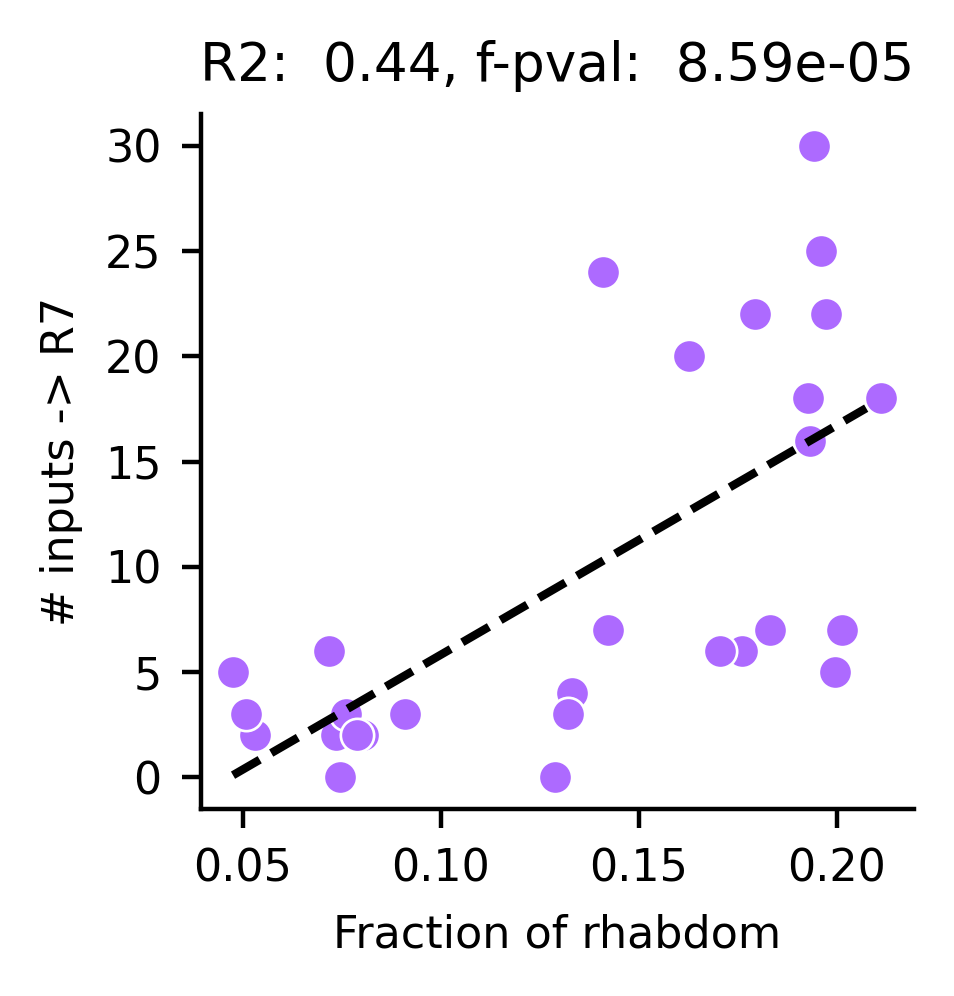

In [45]:
_x = lpr_fvol_inputs['R7']
X = sm.add_constant(_x)
Y = lpr_fvol_inputs['inputs->R7']

model = sm.OLS(Y, X)
results = model.fit()
params = results.params
display(params[0])

# Plot data/model
fig, ax = plt.subplots(1, figsize=[2.3, 2.3])
xx = np.arange(min(_x), max(_x), 0.01)

ax.plot(xx, params[0] + params[1] * xx, c='k', ls='--')
sns.scatterplot(x=lpr_fvol_inputs['R7'], y=lpr_fvol_inputs['inputs->R7'], color=st_cm['R7'], ax=ax)

ax.set_title(f"R2: {results.rsquared: .2f}, f-pval: {results.f_pvalue: .2e}")
ax.set_xlabel('Fraction of rhabdom')
ax.set_ylabel('# inputs -> R7')

plt.show()

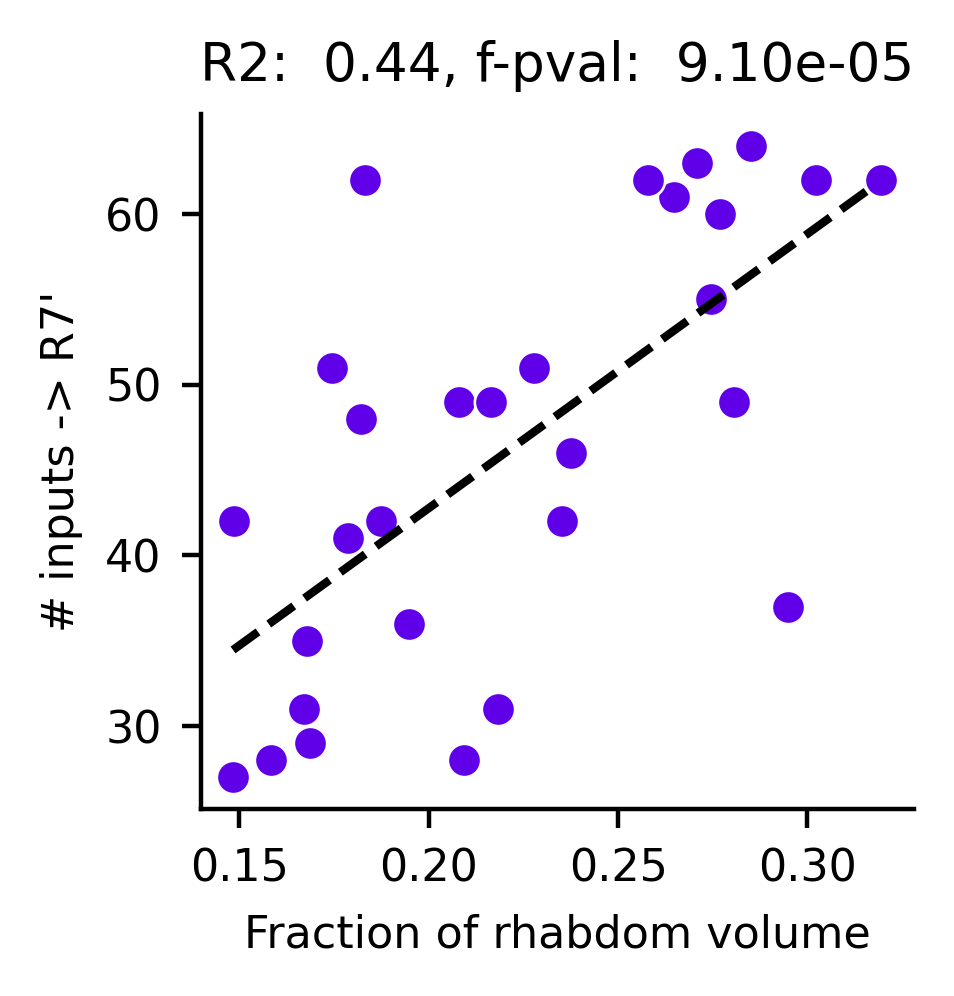

In [46]:
_x = lpr_fvol_inputs['R7p']
X = sm.add_constant(_x)
Y = lpr_fvol_inputs['inputs->R7p']

model = sm.OLS(Y, X)
results = model.fit()
params = results.params

# Plot data/model
fig, ax = plt.subplots(1, figsize=[2.3, 2.3])
xx = np.arange(min(_x), max(_x), 0.01)

ax.plot(xx, params[0] + params[1] * xx, c='k', ls='--')
sns.scatterplot(x=lpr_fvol_inputs['R7p'], y=lpr_fvol_inputs['inputs->R7p'], color=st_cm['R7p'], ax=ax)

ax.set_title(f"R2: {results.rsquared: .2f}, f-pval: {results.f_pvalue: .2e}")
ax.set_xlabel('Fraction of rhabdom volume')
ax.set_ylabel("# inputs -> R7'")

plt.show()

9.608807093276365

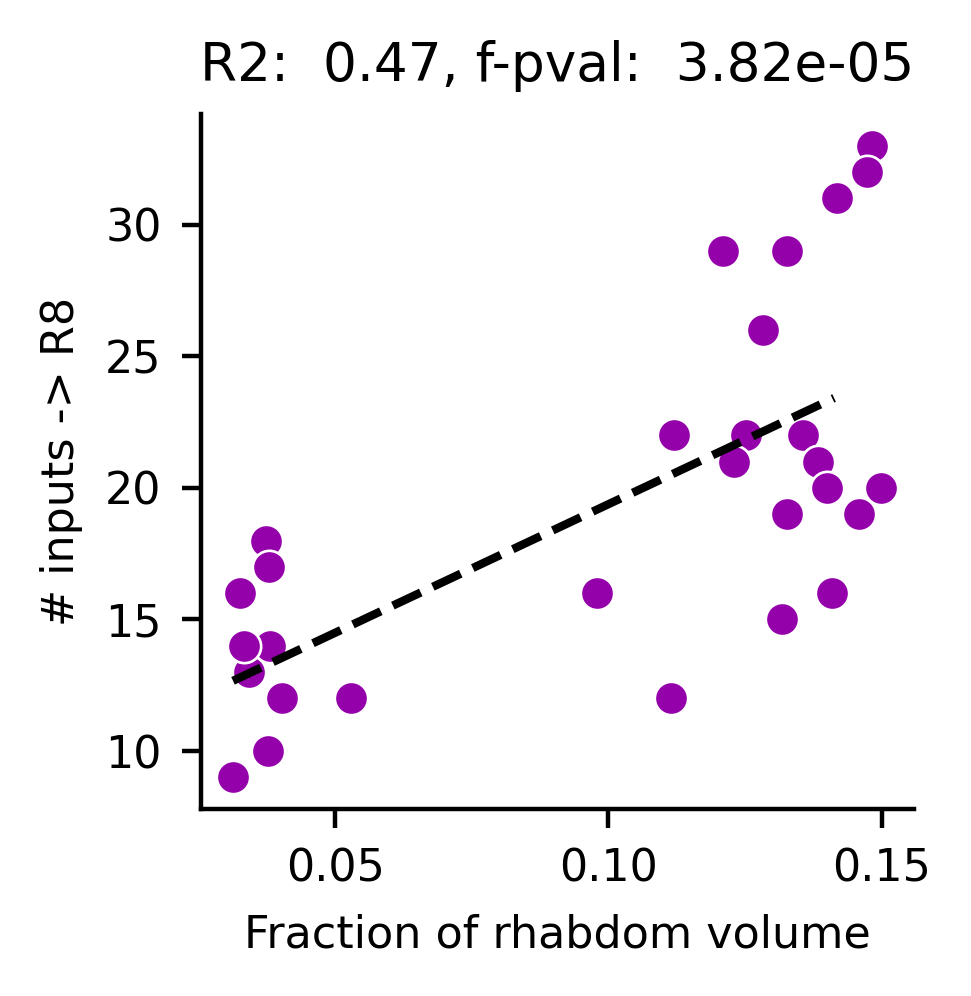

In [47]:
_x = lpr_fvol_inputs['R8']
X = sm.add_constant(_x)
Y = lpr_fvol_inputs['inputs->R8']

model = sm.OLS(Y, X)
results = model.fit()
params = results.params
display(params[0])

# Plot data/model
fig, ax = plt.subplots(1, figsize=[2.3, 2.3])
xx = np.arange(min(_x), max(_x), 0.01)

ax.plot(xx, params[0] + params[1] * xx, c='k', ls='--')
sns.scatterplot(x=lpr_fvol_inputs['R8'], y=lpr_fvol_inputs['inputs->R8'], color=st_cm['R8'], ax=ax)

ax.set_title(f"R2: {results.rsquared: .2f}, f-pval: {results.f_pvalue: .2e}")
ax.set_xlabel('Fraction of rhabdom volume')
ax.set_ylabel('# inputs -> R8')

plt.show()


## Multivariate regression
- Each connection type is its own predicting variable for volume

In [48]:
Y = combined.loc[:, 'R7_vol']
Y = Y
X = sm.add_constant(combined.filter(regex='->R7$'))

display(Y.shape)
display(X.shape)

model = sm.OLS(Y, X)
results = model.fit()

display(results.summary())

KeyError: 'R7_vol'

In [ ]:
Y = combined.loc[:, 'R7p_vol']
Y = Y
X = sm.add_constant(combined.filter(regex='->R7p$'))

display(Y.shape)
display(X.shape)

model = sm.OLS(Y, X)
results = model.fit()

display(results.summary())

In [ ]:
Y = combined.loc[:, 'R8_vol']
Y = Y.to_numpy()
X = sm.add_constant(combined.filter(like='->R8'))

display(Y.shape)
display(X.shape)

model = sm.OLS(Y, X)
results = model.fit()

display(results.summary())